In [1]:
# APPROACH TO ONLY TRAIN ON ONE AND TWO 

In [2]:
import datetime
import os
import pickle
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
from sklearn.inspection import PartialDependenceDisplay, partial_dependence
from sklearn.metrics import (ConfusionMatrixDisplay, accuracy_score, precision_recall_curve, roc_auc_score, roc_curve)
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import label_binarize
from xgboost import XGBClassifier

import shap

%config InlineBackend.figure_format = 'retina'

In [3]:
from notebook import notebookapp
import urllib
import json
import ipykernel
from shutil import copy2

def notebook_path():
    """Returns the absolute path of the Notebook or None if it cannot be determined
    NOTE: works only when the security is token-based or there is also no password
    """
    connection_file = os.path.basename(ipykernel.get_connection_file())
    kernel_id = connection_file.split('-', 1)[1].split('.')[0]

    for srv in notebookapp.list_running_servers():
        try:
            if srv['token']=='' and not srv['password']:  # No token and no password, ahem...
                req = urllib.request.urlopen(srv['url']+'api/sessions')
            else:
                req = urllib.request.urlopen(srv['url']+'api/sessions?token='+srv['token'])
            sessions = json.load(req)
            for sess in sessions:
                if sess['kernel']['id'] == kernel_id:
                    return os.path.join(srv['notebook_dir'],sess['notebook']['path'])
        except:
            pass  # There may be stale entries in the runtime directory 
    return None


def copy_current_nb(new_name):
    nb = notebook_path()
    if nb:
        new_path = os.path.join(os.path.dirname(nb), new_name+'.ipynb')
        copy2(nb, new_path)
    else:
        print("Current notebook path cannot be determined.")

In [4]:
df = pd.read_csv('Data/cover_type_engineered.csv')

In [16]:
df = df.loc[:, [col for col in df if not col.startswith('Cover_Type_')]]
df = df.loc[(df['Cover_Type'] == 1) | (df['Cover_Type'] == 2)]

X = df.drop(columns=['Cover_Type', 'Aspect_Sector'])
y = df['Cover_Type'] - 1

In [17]:
timestamp = datetime.datetime.now().strftime("%Y%m%d%H%M")

warnings.filterwarnings("ignore", category=FutureWarning, module="pandas.api.types")

# Assuming X and y are defined
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=42)

# Define the estimator
estimator = XGBClassifier(tree_method="hist")

# Define hyperparameters for tuning
hyperparameters = {
    "n_estimators": stats.randint(50, 150),  # Increased range
    "learning_rate": stats.uniform(0.05, 0.1),  # Adjusted range
    "colsample_bytree": stats.uniform(0.6, 0.4),
    "colsample_bylevel": stats.uniform(0.6, 0.4),
    "colsample_bynode": stats.uniform(0.6, 0.4),
    "max_depth": stats.randint(15, 50),  # Increased range
    "subsample": stats.uniform(0.6, 0.4),
    "gamma": stats.uniform(0, 2),  # Adjusted range
    "reg_lambda": stats.uniform(0, 2),  # Adjusted range
    "reg_alpha": stats.uniform(0, 2),  # Adjusted range
}

# Define the RandomizedSearchCV parameters
random_search = RandomizedSearchCV(estimator, 
                                   param_distributions=hyperparameters, 
                                   scoring='accuracy',
                                   return_train_score=True,
                                   n_iter=500, 
                                   cv=5, 
                                   verbose=10, 
                                   n_jobs=-1)

# Fit the RandomizedSearchCV
try:
    random_search.fit(X_train, y_train)  # Assuming X_train and y_train are defined
    print("Best parameters found:", random_search.best_params_)
    print("Best score found:", random_search.best_score_)

    
    # Save results
    results_path = f"./tuning_results/tuning_xgb/{timestamp}"
    if not os.path.exists(results_path):
        os.makedirs(results_path)
        
    # Saving cross-validation results
    cv_results = pd.DataFrame(random_search.cv_results_)
    cv_results_file = f"{timestamp}_results.csv"
    cv_results.to_csv(os.path.join(results_path, cv_results_file), index=False)
    
    # Save .ipynb
    copy_current_nb(os.path.join(results_path, 'Evaluation_Notebook'))
    
    # Save Model
    file_name = f"xgb_{timestamp}.pkl"
    pickle.dump(random_search, open(os.path.join(results_path, file_name), "wb"))
        

except Exception as e:
    print(f"An error occurred during model optimization: {e}")


Fitting 5 folds for each of 500 candidates, totalling 2500 fits
[CV 2/5; 2/500] START colsample_bylevel=0.6398760460621272, colsample_bynode=0.6604297339327864, colsample_bytree=0.8909285194831833, gamma=0.4561738017712562, learning_rate=0.07795562585902209, max_depth=24, n_estimators=86, reg_alpha=0.010790441341474333, reg_lambda=1.8140258781293448, subsample=0.8589472484759024
[CV 2/5; 2/500] END colsample_bylevel=0.6398760460621272, colsample_bynode=0.6604297339327864, colsample_bytree=0.8909285194831833, gamma=0.4561738017712562, learning_rate=0.07795562585902209, max_depth=24, n_estimators=86, reg_alpha=0.010790441341474333, reg_lambda=1.8140258781293448, subsample=0.8589472484759024;, score=(train=0.997, test=0.803) total time=   0.7s
[CV 4/5; 3/500] START colsample_bylevel=0.7847967251785161, colsample_bynode=0.6626516517825252, colsample_bytree=0.922542827216404, gamma=0.2575271803657049, learning_rate=0.08655512044711312, max_depth=39, n_estimators=140, reg_alpha=1.97621676248

[CV 1/5; 1/500] START colsample_bylevel=0.9568623721184107, colsample_bynode=0.9675192403964803, colsample_bytree=0.7438389587386695, gamma=1.850842060817991, learning_rate=0.07355647037225387, max_depth=30, n_estimators=65, reg_alpha=1.5015903556461276, reg_lambda=1.7995961878471345, subsample=0.9897003095921357
[CV 1/5; 1/500] END colsample_bylevel=0.9568623721184107, colsample_bynode=0.9675192403964803, colsample_bytree=0.7438389587386695, gamma=1.850842060817991, learning_rate=0.07355647037225387, max_depth=30, n_estimators=65, reg_alpha=1.5015903556461276, reg_lambda=1.7995961878471345, subsample=0.9897003095921357;, score=(train=0.905, test=0.798) total time=   0.4s
[CV 2/5; 3/500] START colsample_bylevel=0.7847967251785161, colsample_bynode=0.6626516517825252, colsample_bytree=0.922542827216404, gamma=0.2575271803657049, learning_rate=0.08655512044711312, max_depth=39, n_estimators=140, reg_alpha=1.9762167624875888, reg_lambda=0.06384409799692592, subsample=0.6868162676021907
[C

[CV 2/5; 1/500] START colsample_bylevel=0.9568623721184107, colsample_bynode=0.9675192403964803, colsample_bytree=0.7438389587386695, gamma=1.850842060817991, learning_rate=0.07355647037225387, max_depth=30, n_estimators=65, reg_alpha=1.5015903556461276, reg_lambda=1.7995961878471345, subsample=0.9897003095921357
[CV 2/5; 1/500] END colsample_bylevel=0.9568623721184107, colsample_bynode=0.9675192403964803, colsample_bytree=0.7438389587386695, gamma=1.850842060817991, learning_rate=0.07355647037225387, max_depth=30, n_estimators=65, reg_alpha=1.5015903556461276, reg_lambda=1.7995961878471345, subsample=0.9897003095921357;, score=(train=0.910, test=0.807) total time=   0.5s
[CV 3/5; 3/500] START colsample_bylevel=0.7847967251785161, colsample_bynode=0.6626516517825252, colsample_bytree=0.922542827216404, gamma=0.2575271803657049, learning_rate=0.08655512044711312, max_depth=39, n_estimators=140, reg_alpha=1.9762167624875888, reg_lambda=0.06384409799692592, subsample=0.6868162676021907
[C

[CV 1/5; 2/500] START colsample_bylevel=0.6398760460621272, colsample_bynode=0.6604297339327864, colsample_bytree=0.8909285194831833, gamma=0.4561738017712562, learning_rate=0.07795562585902209, max_depth=24, n_estimators=86, reg_alpha=0.010790441341474333, reg_lambda=1.8140258781293448, subsample=0.8589472484759024
[CV 1/5; 2/500] END colsample_bylevel=0.6398760460621272, colsample_bynode=0.6604297339327864, colsample_bytree=0.8909285194831833, gamma=0.4561738017712562, learning_rate=0.07795562585902209, max_depth=24, n_estimators=86, reg_alpha=0.010790441341474333, reg_lambda=1.8140258781293448, subsample=0.8589472484759024;, score=(train=0.999, test=0.808) total time=   0.8s
[CV 5/5; 3/500] START colsample_bylevel=0.7847967251785161, colsample_bynode=0.6626516517825252, colsample_bytree=0.922542827216404, gamma=0.2575271803657049, learning_rate=0.08655512044711312, max_depth=39, n_estimators=140, reg_alpha=1.9762167624875888, reg_lambda=0.06384409799692592, subsample=0.6868162676021

[CV 2/5; 36/500] START colsample_bylevel=0.7086150588478461, colsample_bynode=0.9341157407916101, colsample_bytree=0.7062256458235723, gamma=1.1258743160663542, learning_rate=0.08117478432038895, max_depth=44, n_estimators=124, reg_alpha=1.0353303115188224, reg_lambda=1.7544976288320286, subsample=0.9415046135965655
[CV 2/5; 36/500] END colsample_bylevel=0.7086150588478461, colsample_bynode=0.9341157407916101, colsample_bytree=0.7062256458235723, gamma=1.1258743160663542, learning_rate=0.08117478432038895, max_depth=44, n_estimators=124, reg_alpha=1.0353303115188224, reg_lambda=1.7544976288320286, subsample=0.9415046135965655;, score=(train=0.955, test=0.810) total time=   0.5s
[CV 5/5; 37/500] START colsample_bylevel=0.7429053327961056, colsample_bynode=0.7015250604611424, colsample_bytree=0.8187127049444709, gamma=1.9442478980963538, learning_rate=0.051764122594187736, max_depth=30, n_estimators=92, reg_alpha=0.04113185720171986, reg_lambda=1.9538137911947664, subsample=0.99745659672

[CV 4/5; 38/500] START colsample_bylevel=0.8533379974187558, colsample_bynode=0.7689041541199688, colsample_bytree=0.6139042603778949, gamma=0.329774285497058, learning_rate=0.08880491966245235, max_depth=30, n_estimators=105, reg_alpha=1.8740961107816287, reg_lambda=1.0504147487068114, subsample=0.7300579341940454
[CV 4/5; 38/500] END colsample_bylevel=0.8533379974187558, colsample_bynode=0.7689041541199688, colsample_bytree=0.6139042603778949, gamma=0.329774285497058, learning_rate=0.08880491966245235, max_depth=30, n_estimators=105, reg_alpha=1.8740961107816287, reg_lambda=1.0504147487068114, subsample=0.7300579341940454;, score=(train=0.969, test=0.798) total time=   0.5s
[CV 1/5; 41/500] START colsample_bylevel=0.9125865355137719, colsample_bynode=0.7443192905376471, colsample_bytree=0.9793143700413002, gamma=1.1390459061657412, learning_rate=0.14689321274281575, max_depth=18, n_estimators=117, reg_alpha=1.9313116156304864, reg_lambda=0.8996207683343165, subsample=0.67715319063129

[CV 4/5; 37/500] START colsample_bylevel=0.7429053327961056, colsample_bynode=0.7015250604611424, colsample_bytree=0.8187127049444709, gamma=1.9442478980963538, learning_rate=0.051764122594187736, max_depth=30, n_estimators=92, reg_alpha=0.04113185720171986, reg_lambda=1.9538137911947664, subsample=0.9974565967215258
[CV 4/5; 37/500] END colsample_bylevel=0.7429053327961056, colsample_bynode=0.7015250604611424, colsample_bytree=0.8187127049444709, gamma=1.9442478980963538, learning_rate=0.051764122594187736, max_depth=30, n_estimators=92, reg_alpha=0.04113185720171986, reg_lambda=1.9538137911947664, subsample=0.9974565967215258;, score=(train=0.933, test=0.793) total time=   0.5s
[CV 1/5; 39/500] START colsample_bylevel=0.9732768042025277, colsample_bynode=0.7314931684323632, colsample_bytree=0.9865004749894739, gamma=1.0774663350270328, learning_rate=0.13909528437301172, max_depth=27, n_estimators=73, reg_alpha=1.8748166206170567, reg_lambda=0.463704109390902, subsample=0.650380890941

[CV 5/5; 38/500] START colsample_bylevel=0.8533379974187558, colsample_bynode=0.7689041541199688, colsample_bytree=0.6139042603778949, gamma=0.329774285497058, learning_rate=0.08880491966245235, max_depth=30, n_estimators=105, reg_alpha=1.8740961107816287, reg_lambda=1.0504147487068114, subsample=0.7300579341940454
[CV 5/5; 38/500] END colsample_bylevel=0.8533379974187558, colsample_bynode=0.7689041541199688, colsample_bytree=0.6139042603778949, gamma=0.329774285497058, learning_rate=0.08880491966245235, max_depth=30, n_estimators=105, reg_alpha=1.8740961107816287, reg_lambda=1.0504147487068114, subsample=0.7300579341940454;, score=(train=0.976, test=0.792) total time=   0.5s
[CV 5/5; 40/500] START colsample_bylevel=0.6076533718280501, colsample_bynode=0.6068662927764096, colsample_bytree=0.9677582122884986, gamma=0.03396464289255552, learning_rate=0.11886911473090288, max_depth=29, n_estimators=109, reg_alpha=1.973545593828676, reg_lambda=0.8073748274819197, subsample=0.67533248361171

[CV 4/5; 39/500] START colsample_bylevel=0.9732768042025277, colsample_bynode=0.7314931684323632, colsample_bytree=0.9865004749894739, gamma=1.0774663350270328, learning_rate=0.13909528437301172, max_depth=27, n_estimators=73, reg_alpha=1.8748166206170567, reg_lambda=0.463704109390902, subsample=0.6503808909417246
[CV 4/5; 39/500] END colsample_bylevel=0.9732768042025277, colsample_bynode=0.7314931684323632, colsample_bytree=0.9865004749894739, gamma=1.0774663350270328, learning_rate=0.13909528437301172, max_depth=27, n_estimators=73, reg_alpha=1.8748166206170567, reg_lambda=0.463704109390902, subsample=0.6503808909417246;, score=(train=0.944, test=0.791) total time=   0.3s
[CV 2/5; 41/500] START colsample_bylevel=0.9125865355137719, colsample_bynode=0.7443192905376471, colsample_bytree=0.9793143700413002, gamma=1.1390459061657412, learning_rate=0.14689321274281575, max_depth=18, n_estimators=117, reg_alpha=1.9313116156304864, reg_lambda=0.8996207683343165, subsample=0.677153190631297


[CV 4/5; 40/500] START colsample_bylevel=0.6076533718280501, colsample_bynode=0.6068662927764096, colsample_bytree=0.9677582122884986, gamma=0.03396464289255552, learning_rate=0.11886911473090288, max_depth=29, n_estimators=109, reg_alpha=1.973545593828676, reg_lambda=0.8073748274819197, subsample=0.6753324836117197
[CV 4/5; 40/500] END colsample_bylevel=0.6076533718280501, colsample_bynode=0.6068662927764096, colsample_bytree=0.9677582122884986, gamma=0.03396464289255552, learning_rate=0.11886911473090288, max_depth=29, n_estimators=109, reg_alpha=1.973545593828676, reg_lambda=0.8073748274819197, subsample=0.6753324836117197;, score=(train=0.989, test=0.794) total time=   0.6s
[CV 4/5; 42/500] START colsample_bylevel=0.7533888965104223, colsample_bynode=0.9462174535287875, colsample_bytree=0.8537537449392676, gamma=0.26531258551254067, learning_rate=0.05470070254621831, max_depth=41, n_estimators=142, reg_alpha=1.365932159306721, reg_lambda=1.229136439464359, subsample=0.9035896797932

[CV 5/5; 69/500] START colsample_bylevel=0.7861507629284736, colsample_bynode=0.8402329078763715, colsample_bytree=0.8519767244243206, gamma=0.7681756461861258, learning_rate=0.09417131749406626, max_depth=36, n_estimators=138, reg_alpha=1.7200422194259717, reg_lambda=0.2106821831343173, subsample=0.991100210338206
[CV 5/5; 69/500] END colsample_bylevel=0.7861507629284736, colsample_bynode=0.8402329078763715, colsample_bytree=0.8519767244243206, gamma=0.7681756461861258, learning_rate=0.09417131749406626, max_depth=36, n_estimators=138, reg_alpha=1.7200422194259717, reg_lambda=0.2106821831343173, subsample=0.991100210338206;, score=(train=0.957, test=0.803) total time=   0.4s
[CV 3/5; 71/500] START colsample_bylevel=0.9402478069478089, colsample_bynode=0.7537226030466246, colsample_bytree=0.8016641392648811, gamma=1.5532811698510567, learning_rate=0.06462268813024839, max_depth=34, n_estimators=65, reg_alpha=0.9866422357696696, reg_lambda=0.57644817920697, subsample=0.7243332644154905


[CV 2/5; 74/500] START colsample_bylevel=0.816513274959898, colsample_bynode=0.7643205836044628, colsample_bytree=0.8116128206396764, gamma=1.5171111189816406, learning_rate=0.1163525065671689, max_depth=44, n_estimators=103, reg_alpha=1.907337332030161, reg_lambda=0.2642178295276385, subsample=0.7154348405102912
[CV 2/5; 74/500] END colsample_bylevel=0.816513274959898, colsample_bynode=0.7643205836044628, colsample_bytree=0.8116128206396764, gamma=1.5171111189816406, learning_rate=0.1163525065671689, max_depth=44, n_estimators=103, reg_alpha=1.907337332030161, reg_lambda=0.2642178295276385, subsample=0.7154348405102912;, score=(train=0.914, test=0.788) total time=   0.4s
[CV 1/5; 75/500] START colsample_bylevel=0.6432688173800886, colsample_bynode=0.9222519408660952, colsample_bytree=0.8609422606129813, gamma=0.07074917738186981, learning_rate=0.059621776929956585, max_depth=43, n_estimators=54, reg_alpha=0.6139589343152598, reg_lambda=0.6733521168393279, subsample=0.8618663268289417


[CV 4/5; 76/500] START colsample_bylevel=0.8903535536433689, colsample_bynode=0.7053059820811457, colsample_bytree=0.6328506262259835, gamma=1.2652945461333378, learning_rate=0.14545119572063453, max_depth=17, n_estimators=95, reg_alpha=1.6876822667219638, reg_lambda=1.1240628556909877, subsample=0.6882788931698155
[CV 4/5; 76/500] END colsample_bylevel=0.8903535536433689, colsample_bynode=0.7053059820811457, colsample_bytree=0.6328506262259835, gamma=1.2652945461333378, learning_rate=0.14545119572063453, max_depth=17, n_estimators=95, reg_alpha=1.6876822667219638, reg_lambda=1.1240628556909877, subsample=0.6882788931698155;, score=(train=0.921, test=0.803) total time=   0.3s
[CV 1/5; 78/500] START colsample_bylevel=0.9320796107045175, colsample_bynode=0.9058789130114927, colsample_bytree=0.6567012482889769, gamma=1.7897900633382504, learning_rate=0.08638260457862318, max_depth=20, n_estimators=78, reg_alpha=1.5066309140721104, reg_lambda=0.5949072388301382, subsample=0.857761604487618

[CV 3/5; 76/500] END colsample_bylevel=0.8903535536433689, colsample_bynode=0.7053059820811457, colsample_bytree=0.6328506262259835, gamma=1.2652945461333378, learning_rate=0.14545119572063453, max_depth=17, n_estimators=95, reg_alpha=1.6876822667219638, reg_lambda=1.1240628556909877, subsample=0.6882788931698155;, score=(train=0.915, test=0.848) total time=   0.3s
[CV 1/5; 77/500] START colsample_bylevel=0.6133323463489875, colsample_bynode=0.8299173729347484, colsample_bytree=0.743983933363942, gamma=0.3116804377567177, learning_rate=0.07445551834626589, max_depth=41, n_estimators=102, reg_alpha=1.66953856429376, reg_lambda=1.6143257296824394, subsample=0.7901203117900335
[CV 1/5; 77/500] END colsample_bylevel=0.6133323463489875, colsample_bynode=0.8299173729347484, colsample_bytree=0.743983933363942, gamma=0.3116804377567177, learning_rate=0.07445551834626589, max_depth=41, n_estimators=102, reg_alpha=1.66953856429376, reg_lambda=1.6143257296824394, subsample=0.7901203117900335;, sc

[CV 4/5; 75/500] START colsample_bylevel=0.6432688173800886, colsample_bynode=0.9222519408660952, colsample_bytree=0.8609422606129813, gamma=0.07074917738186981, learning_rate=0.059621776929956585, max_depth=43, n_estimators=54, reg_alpha=0.6139589343152598, reg_lambda=0.6733521168393279, subsample=0.8618663268289417
[CV 4/5; 75/500] END colsample_bylevel=0.6432688173800886, colsample_bynode=0.9222519408660952, colsample_bytree=0.8609422606129813, gamma=0.07074917738186981, learning_rate=0.059621776929956585, max_depth=43, n_estimators=54, reg_alpha=0.6139589343152598, reg_lambda=0.6733521168393279, subsample=0.8618663268289417;, score=(train=0.984, test=0.798) total time=   0.7s
[CV 2/5; 78/500] START colsample_bylevel=0.9320796107045175, colsample_bynode=0.9058789130114927, colsample_bytree=0.6567012482889769, gamma=1.7897900633382504, learning_rate=0.08638260457862318, max_depth=20, n_estimators=78, reg_alpha=1.5066309140721104, reg_lambda=0.5949072388301382, subsample=0.85776160448

[CV 5/5; 77/500] START colsample_bylevel=0.6133323463489875, colsample_bynode=0.8299173729347484, colsample_bytree=0.743983933363942, gamma=0.3116804377567177, learning_rate=0.07445551834626589, max_depth=41, n_estimators=102, reg_alpha=1.66953856429376, reg_lambda=1.6143257296824394, subsample=0.7901203117900335
[CV 5/5; 77/500] END colsample_bylevel=0.6133323463489875, colsample_bynode=0.8299173729347484, colsample_bytree=0.743983933363942, gamma=0.3116804377567177, learning_rate=0.07445551834626589, max_depth=41, n_estimators=102, reg_alpha=1.66953856429376, reg_lambda=1.6143257296824394, subsample=0.7901203117900335;, score=(train=0.971, test=0.791) total time=   0.6s
[CV 4/5; 79/500] START colsample_bylevel=0.8826411750613326, colsample_bynode=0.977100894680274, colsample_bytree=0.9582322732187195, gamma=0.32877862014063486, learning_rate=0.1130179124122629, max_depth=19, n_estimators=62, reg_alpha=1.607002884208785, reg_lambda=0.5658585704091323, subsample=0.9182910308678451
[CV 

[CV 3/5; 75/500] START colsample_bylevel=0.6432688173800886, colsample_bynode=0.9222519408660952, colsample_bytree=0.8609422606129813, gamma=0.07074917738186981, learning_rate=0.059621776929956585, max_depth=43, n_estimators=54, reg_alpha=0.6139589343152598, reg_lambda=0.6733521168393279, subsample=0.8618663268289417
[CV 3/5; 75/500] END colsample_bylevel=0.6432688173800886, colsample_bynode=0.9222519408660952, colsample_bytree=0.8609422606129813, gamma=0.07074917738186981, learning_rate=0.059621776929956585, max_depth=43, n_estimators=54, reg_alpha=0.6139589343152598, reg_lambda=0.6733521168393279, subsample=0.8618663268289417;, score=(train=0.986, test=0.872) total time=   0.8s
[CV 3/5; 78/500] START colsample_bylevel=0.9320796107045175, colsample_bynode=0.9058789130114927, colsample_bytree=0.6567012482889769, gamma=1.7897900633382504, learning_rate=0.08638260457862318, max_depth=20, n_estimators=78, reg_alpha=1.5066309140721104, reg_lambda=0.5949072388301382, subsample=0.85776160448

[CV 2/5; 79/500] START colsample_bylevel=0.8826411750613326, colsample_bynode=0.977100894680274, colsample_bytree=0.9582322732187195, gamma=0.32877862014063486, learning_rate=0.1130179124122629, max_depth=19, n_estimators=62, reg_alpha=1.607002884208785, reg_lambda=0.5658585704091323, subsample=0.9182910308678451
[CV 2/5; 79/500] END colsample_bylevel=0.8826411750613326, colsample_bynode=0.977100894680274, colsample_bytree=0.9582322732187195, gamma=0.32877862014063486, learning_rate=0.1130179124122629, max_depth=19, n_estimators=62, reg_alpha=1.607002884208785, reg_lambda=0.5658585704091323, subsample=0.9182910308678451;, score=(train=0.989, test=0.826) total time=   0.6s
[CV 5/5; 80/500] START colsample_bylevel=0.6565090876939432, colsample_bynode=0.7861097787732053, colsample_bytree=0.8929703715099165, gamma=0.12570170590298702, learning_rate=0.09772771236756976, max_depth=37, n_estimators=72, reg_alpha=1.051036609441931, reg_lambda=1.4999332335139017, subsample=0.6841430481699251
[C

[CV 1/5; 111/500] START colsample_bylevel=0.6526929425861245, colsample_bynode=0.8087437276152152, colsample_bytree=0.8970005268703023, gamma=0.3994919930097731, learning_rate=0.11932554159823328, max_depth=24, n_estimators=76, reg_alpha=1.8778363988103959, reg_lambda=0.9879823726424515, subsample=0.6987083786537416
[CV 1/5; 111/500] END colsample_bylevel=0.6526929425861245, colsample_bynode=0.8087437276152152, colsample_bytree=0.8970005268703023, gamma=0.3994919930097731, learning_rate=0.11932554159823328, max_depth=24, n_estimators=76, reg_alpha=1.8778363988103959, reg_lambda=0.9879823726424515, subsample=0.6987083786537416;, score=(train=0.968, test=0.808) total time=   0.5s
[CV 1/5; 112/500] START colsample_bylevel=0.9865461065387513, colsample_bynode=0.9040759294639148, colsample_bytree=0.848613148841141, gamma=0.9125505517512384, learning_rate=0.1375535926819279, max_depth=40, n_estimators=116, reg_alpha=0.6301721474565924, reg_lambda=1.321488244662644, subsample=0.62703657657643

[CV 5/5; 110/500] START colsample_bylevel=0.8749334853040864, colsample_bynode=0.8321099170790713, colsample_bytree=0.9808834670017592, gamma=0.5717571625684303, learning_rate=0.08077677738430511, max_depth=25, n_estimators=75, reg_alpha=0.5223356002590851, reg_lambda=1.6989808747557944, subsample=0.8508108359120189
[CV 5/5; 110/500] END colsample_bylevel=0.8749334853040864, colsample_bynode=0.8321099170790713, colsample_bytree=0.9808834670017592, gamma=0.5717571625684303, learning_rate=0.08077677738430511, max_depth=25, n_estimators=75, reg_alpha=0.5223356002590851, reg_lambda=1.6989808747557944, subsample=0.8508108359120189;, score=(train=0.991, test=0.804) total time=   0.7s
[CV 4/5; 112/500] START colsample_bylevel=0.9865461065387513, colsample_bynode=0.9040759294639148, colsample_bytree=0.848613148841141, gamma=0.9125505517512384, learning_rate=0.1375535926819279, max_depth=40, n_estimators=116, reg_alpha=0.6301721474565924, reg_lambda=1.321488244662644, subsample=0.62703657657643

[CV 5/5; 111/500] START colsample_bylevel=0.6526929425861245, colsample_bynode=0.8087437276152152, colsample_bytree=0.8970005268703023, gamma=0.3994919930097731, learning_rate=0.11932554159823328, max_depth=24, n_estimators=76, reg_alpha=1.8778363988103959, reg_lambda=0.9879823726424515, subsample=0.6987083786537416
[CV 5/5; 111/500] END colsample_bylevel=0.6526929425861245, colsample_bynode=0.8087437276152152, colsample_bytree=0.8970005268703023, gamma=0.3994919930097731, learning_rate=0.11932554159823328, max_depth=24, n_estimators=76, reg_alpha=1.8778363988103959, reg_lambda=0.9879823726424515, subsample=0.6987083786537416;, score=(train=0.964, test=0.796) total time=   0.4s
[CV 3/5; 113/500] START colsample_bylevel=0.8063831730297228, colsample_bynode=0.8615401338759308, colsample_bytree=0.7377615258886423, gamma=0.15187009712020072, learning_rate=0.13671859056098, max_depth=47, n_estimators=71, reg_alpha=0.20019564664296352, reg_lambda=1.444314164963072, subsample=0.93318323355910

[CV 2/5; 113/500] END colsample_bylevel=0.8063831730297228, colsample_bynode=0.8615401338759308, colsample_bytree=0.7377615258886423, gamma=0.15187009712020072, learning_rate=0.13671859056098, max_depth=47, n_estimators=71, reg_alpha=0.20019564664296352, reg_lambda=1.444314164963072, subsample=0.9331832335591065;, score=(train=1.000, test=0.820) total time=   0.7s
[CV 1/5; 115/500] START colsample_bylevel=0.6800193110659308, colsample_bynode=0.815955478321755, colsample_bytree=0.9245299980193984, gamma=1.2610909199252818, learning_rate=0.12842311842297177, max_depth=30, n_estimators=82, reg_alpha=1.8742913918420754, reg_lambda=0.556439832330893, subsample=0.6508114997148012
[CV 1/5; 115/500] END colsample_bylevel=0.6800193110659308, colsample_bynode=0.815955478321755, colsample_bytree=0.9245299980193984, gamma=1.2610909199252818, learning_rate=0.12842311842297177, max_depth=30, n_estimators=82, reg_alpha=1.8742913918420754, reg_lambda=0.556439832330893, subsample=0.6508114997148012;, s

[CV 5/5; 112/500] START colsample_bylevel=0.9865461065387513, colsample_bynode=0.9040759294639148, colsample_bytree=0.848613148841141, gamma=0.9125505517512384, learning_rate=0.1375535926819279, max_depth=40, n_estimators=116, reg_alpha=0.6301721474565924, reg_lambda=1.321488244662644, subsample=0.6270365765764355
[CV 5/5; 112/500] END colsample_bylevel=0.9865461065387513, colsample_bynode=0.9040759294639148, colsample_bytree=0.848613148841141, gamma=0.9125505517512384, learning_rate=0.1375535926819279, max_depth=40, n_estimators=116, reg_alpha=0.6301721474565924, reg_lambda=1.321488244662644, subsample=0.6270365765764355;, score=(train=0.984, test=0.804) total time=   0.5s
[CV 3/5; 114/500] START colsample_bylevel=0.9853545158181803, colsample_bynode=0.8231630697300159, colsample_bytree=0.9571361144089734, gamma=0.9462390514323729, learning_rate=0.088130992414501, max_depth=46, n_estimators=80, reg_alpha=1.9446100698134519, reg_lambda=0.9379540576173735, subsample=0.7351985807590454
[

[CV 2/5; 120/500] START colsample_bylevel=0.916702932254086, colsample_bynode=0.7342209862786098, colsample_bytree=0.7447280002158199, gamma=0.7156543927283554, learning_rate=0.14008846098139324, max_depth=44, n_estimators=115, reg_alpha=1.6415506394478245, reg_lambda=0.03668023636495077, subsample=0.8978936663363877
[CV 2/5; 120/500] END colsample_bylevel=0.916702932254086, colsample_bynode=0.7342209862786098, colsample_bytree=0.7447280002158199, gamma=0.7156543927283554, learning_rate=0.14008846098139324, max_depth=44, n_estimators=115, reg_alpha=1.6415506394478245, reg_lambda=0.03668023636495077, subsample=0.8978936663363877;, score=(train=0.973, test=0.819) total time=   0.4s
[CV 1/5; 122/500] START colsample_bylevel=0.6133774079150762, colsample_bynode=0.7431368085367506, colsample_bytree=0.9848302193948584, gamma=1.620808407481306, learning_rate=0.12296086524994283, max_depth=39, n_estimators=62, reg_alpha=1.3428843388137093, reg_lambda=1.7485380798032848, subsample=0.79284215617

[CV 5/5; 113/500] START colsample_bylevel=0.8063831730297228, colsample_bynode=0.8615401338759308, colsample_bytree=0.7377615258886423, gamma=0.15187009712020072, learning_rate=0.13671859056098, max_depth=47, n_estimators=71, reg_alpha=0.20019564664296352, reg_lambda=1.444314164963072, subsample=0.9331832335591065
[CV 5/5; 113/500] END colsample_bylevel=0.8063831730297228, colsample_bynode=0.8615401338759308, colsample_bytree=0.7377615258886423, gamma=0.15187009712020072, learning_rate=0.13671859056098, max_depth=47, n_estimators=71, reg_alpha=0.20019564664296352, reg_lambda=1.444314164963072, subsample=0.9331832335591065;, score=(train=1.000, test=0.815) total time=   0.7s
[CV 5/5; 115/500] START colsample_bylevel=0.6800193110659308, colsample_bynode=0.815955478321755, colsample_bytree=0.9245299980193984, gamma=1.2610909199252818, learning_rate=0.12842311842297177, max_depth=30, n_estimators=82, reg_alpha=1.8742913918420754, reg_lambda=0.556439832330893, subsample=0.6508114997148012
[

[CV 3/5; 143/500] START colsample_bylevel=0.6570016620023355, colsample_bynode=0.8299915546111754, colsample_bytree=0.6645444945466868, gamma=0.3551396133888678, learning_rate=0.06773278948032882, max_depth=21, n_estimators=115, reg_alpha=0.5848349274222098, reg_lambda=0.9850477102622979, subsample=0.8773485165910452
[CV 3/5; 143/500] END colsample_bylevel=0.6570016620023355, colsample_bynode=0.8299915546111754, colsample_bytree=0.6645444945466868, gamma=0.3551396133888678, learning_rate=0.06773278948032882, max_depth=21, n_estimators=115, reg_alpha=0.5848349274222098, reg_lambda=0.9850477102622979, subsample=0.8773485165910452;, score=(train=0.997, test=0.864) total time=   0.7s
[CV 4/5; 145/500] START colsample_bylevel=0.8712711218593014, colsample_bynode=0.7045822290357917, colsample_bytree=0.8132805635934726, gamma=0.2840123251644795, learning_rate=0.11272604544173793, max_depth=27, n_estimators=123, reg_alpha=1.3947216938644549, reg_lambda=1.1900890707280667, subsample=0.944342826

[CV 2/5; 144/500] START colsample_bylevel=0.7271547058236041, colsample_bynode=0.9423863948431693, colsample_bytree=0.901825468102549, gamma=1.2471620778444616, learning_rate=0.08813465789670241, max_depth=45, n_estimators=147, reg_alpha=1.7269895654175473, reg_lambda=0.7850395898644076, subsample=0.8464749564338466
[CV 2/5; 144/500] END colsample_bylevel=0.7271547058236041, colsample_bynode=0.9423863948431693, colsample_bytree=0.901825468102549, gamma=1.2471620778444616, learning_rate=0.08813465789670241, max_depth=45, n_estimators=147, reg_alpha=1.7269895654175473, reg_lambda=0.7850395898644076, subsample=0.8464749564338466;, score=(train=0.941, test=0.817) total time=   0.5s
[CV 1/5; 145/500] START colsample_bylevel=0.8712711218593014, colsample_bynode=0.7045822290357917, colsample_bytree=0.8132805635934726, gamma=0.2840123251644795, learning_rate=0.11272604544173793, max_depth=27, n_estimators=123, reg_alpha=1.3947216938644549, reg_lambda=1.1900890707280667, subsample=0.94434282627

[CV 3/5; 151/500] START colsample_bylevel=0.7791791082765237, colsample_bynode=0.988489496807271, colsample_bytree=0.7149855273526661, gamma=0.5093366172966134, learning_rate=0.09370710880896604, max_depth=30, n_estimators=80, reg_alpha=0.17772480164434734, reg_lambda=1.9268576969267042, subsample=0.7960597047015683
[CV 3/5; 151/500] END colsample_bylevel=0.7791791082765237, colsample_bynode=0.988489496807271, colsample_bytree=0.7149855273526661, gamma=0.5093366172966134, learning_rate=0.09370710880896604, max_depth=30, n_estimators=80, reg_alpha=0.17772480164434734, reg_lambda=1.9268576969267042, subsample=0.7960597047015683;, score=(train=0.997, test=0.853) total time=   0.6s
[CV 1/5; 153/500] START colsample_bylevel=0.6630124279373604, colsample_bynode=0.8777497007641897, colsample_bytree=0.7246685035902694, gamma=0.6465660362095078, learning_rate=0.1245411042045488, max_depth=26, n_estimators=68, reg_alpha=1.0305871589550804, reg_lambda=1.9596415185143026, subsample=0.6121452742372

[CV 1/5; 147/500] START colsample_bylevel=0.6894728472099472, colsample_bynode=0.8620730544564424, colsample_bytree=0.8278940349416486, gamma=1.7575942720879016, learning_rate=0.12100213077774147, max_depth=28, n_estimators=137, reg_alpha=1.28270788019452, reg_lambda=1.191333308545089, subsample=0.6221402572210699
[CV 1/5; 147/500] END colsample_bylevel=0.6894728472099472, colsample_bynode=0.8620730544564424, colsample_bytree=0.8278940349416486, gamma=1.7575942720879016, learning_rate=0.12100213077774147, max_depth=28, n_estimators=137, reg_alpha=1.28270788019452, reg_lambda=1.191333308545089, subsample=0.6221402572210699;, score=(train=0.921, test=0.796) total time=   0.3s
[CV 1/5; 148/500] START colsample_bylevel=0.7572520821352974, colsample_bynode=0.6546631118486762, colsample_bytree=0.6093434971172785, gamma=0.9548414060590678, learning_rate=0.08871172463112575, max_depth=22, n_estimators=133, reg_alpha=0.3069789387022035, reg_lambda=0.7956252698005124, subsample=0.670331748393967

[CV 3/5; 150/500] END colsample_bylevel=0.6271672394339626, colsample_bynode=0.6685836471630136, colsample_bytree=0.9329400580481438, gamma=0.308324211087474, learning_rate=0.11005225388222703, max_depth=22, n_estimators=109, reg_alpha=1.4729545966288518, reg_lambda=1.273474134812241, subsample=0.7098758768418946;, score=(train=0.985, test=0.843) total time=   0.6s
[CV 2/5; 152/500] START colsample_bylevel=0.9407536556835913, colsample_bynode=0.8739428878675626, colsample_bytree=0.6286682209237492, gamma=0.8895799070999872, learning_rate=0.05429517688999516, max_depth=26, n_estimators=144, reg_alpha=0.8139697681771352, reg_lambda=1.4317213742717871, subsample=0.7008422164975224
[CV 2/5; 152/500] END colsample_bylevel=0.9407536556835913, colsample_bynode=0.8739428878675626, colsample_bytree=0.6286682209237492, gamma=0.8895799070999872, learning_rate=0.05429517688999516, max_depth=26, n_estimators=144, reg_alpha=0.8139697681771352, reg_lambda=1.4317213742717871, subsample=0.7008422164975

[CV 4/5; 152/500] START colsample_bylevel=0.9407536556835913, colsample_bynode=0.8739428878675626, colsample_bytree=0.6286682209237492, gamma=0.8895799070999872, learning_rate=0.05429517688999516, max_depth=26, n_estimators=144, reg_alpha=0.8139697681771352, reg_lambda=1.4317213742717871, subsample=0.7008422164975224
[CV 4/5; 152/500] END colsample_bylevel=0.9407536556835913, colsample_bynode=0.8739428878675626, colsample_bytree=0.6286682209237492, gamma=0.8895799070999872, learning_rate=0.05429517688999516, max_depth=26, n_estimators=144, reg_alpha=0.8139697681771352, reg_lambda=1.4317213742717871, subsample=0.7008422164975224;, score=(train=0.966, test=0.798) total time=   0.7s
[CV 2/5; 155/500] START colsample_bylevel=0.7895765652253706, colsample_bynode=0.8104976838265809, colsample_bytree=0.8850406615814057, gamma=1.0605609250951016, learning_rate=0.12891906277076692, max_depth=43, n_estimators=52, reg_alpha=0.883479460797552, reg_lambda=1.880981027576238, subsample=0.901492059369

[CV 2/5; 154/500] START colsample_bylevel=0.9226925573979037, colsample_bynode=0.724042526661451, colsample_bytree=0.726371814691965, gamma=1.7273635123679978, learning_rate=0.054520784884717954, max_depth=46, n_estimators=140, reg_alpha=0.6183867572449455, reg_lambda=1.2764056551635303, subsample=0.8080725877517597
[CV 2/5; 154/500] END colsample_bylevel=0.9226925573979037, colsample_bynode=0.724042526661451, colsample_bytree=0.726371814691965, gamma=1.7273635123679978, learning_rate=0.054520784884717954, max_depth=46, n_estimators=140, reg_alpha=0.6183867572449455, reg_lambda=1.2764056551635303, subsample=0.8080725877517597;, score=(train=0.940, test=0.810) total time=   0.6s
[CV 1/5; 156/500] START colsample_bylevel=0.7808854287060637, colsample_bynode=0.7949739104206494, colsample_bytree=0.7905287184298329, gamma=0.5221002017067107, learning_rate=0.1154475335028413, max_depth=15, n_estimators=136, reg_alpha=0.7534325573425025, reg_lambda=1.8648927372010733, subsample=0.841051105730

[CV 2/5; 179/500] START colsample_bylevel=0.9313541510585166, colsample_bynode=0.989615383367197, colsample_bytree=0.6917735828476701, gamma=1.3122953541901665, learning_rate=0.119205760263678, max_depth=29, n_estimators=69, reg_alpha=0.5193680845243374, reg_lambda=1.8175105647850247, subsample=0.9643145496234462
[CV 2/5; 179/500] END colsample_bylevel=0.9313541510585166, colsample_bynode=0.989615383367197, colsample_bytree=0.6917735828476701, gamma=1.3122953541901665, learning_rate=0.119205760263678, max_depth=29, n_estimators=69, reg_alpha=0.5193680845243374, reg_lambda=1.8175105647850247, subsample=0.9643145496234462;, score=(train=0.962, test=0.800) total time=   0.4s
[CV 2/5; 180/500] START colsample_bylevel=0.8418779163708849, colsample_bynode=0.9492707412962511, colsample_bytree=0.6004761927565422, gamma=0.665231297708192, learning_rate=0.09219934446016165, max_depth=36, n_estimators=143, reg_alpha=1.7707096402508509, reg_lambda=1.1290272556919185, subsample=0.8958387704991233
[

[CV 3/5; 180/500] START colsample_bylevel=0.8418779163708849, colsample_bynode=0.9492707412962511, colsample_bytree=0.6004761927565422, gamma=0.665231297708192, learning_rate=0.09219934446016165, max_depth=36, n_estimators=143, reg_alpha=1.7707096402508509, reg_lambda=1.1290272556919185, subsample=0.8958387704991233
[CV 3/5; 180/500] END colsample_bylevel=0.8418779163708849, colsample_bynode=0.9492707412962511, colsample_bytree=0.6004761927565422, gamma=0.665231297708192, learning_rate=0.09219934446016165, max_depth=36, n_estimators=143, reg_alpha=1.7707096402508509, reg_lambda=1.1290272556919185, subsample=0.8958387704991233;, score=(train=0.960, test=0.865) total time=   0.5s
[CV 1/5; 182/500] START colsample_bylevel=0.7864717139644052, colsample_bynode=0.6342106670750735, colsample_bytree=0.6535033289457751, gamma=1.379800615309562, learning_rate=0.07533539068960743, max_depth=38, n_estimators=129, reg_alpha=1.7523663783889547, reg_lambda=0.49346934787958596, subsample=0.90366074607

[CV 1/5; 186/500] END colsample_bylevel=0.638771506921351, colsample_bynode=0.9878044389084039, colsample_bytree=0.972443613061869, gamma=0.9864108040321056, learning_rate=0.07627093478516055, max_depth=38, n_estimators=61, reg_alpha=0.8060054128554563, reg_lambda=0.8419833997044317, subsample=0.6301949998061146;, score=(train=0.952, test=0.789) total time=   0.4s
[CV 4/5; 187/500] START colsample_bylevel=0.9060107643152893, colsample_bynode=0.7105637582095913, colsample_bytree=0.8374436658149662, gamma=0.8683895591105961, learning_rate=0.05950687082797343, max_depth=38, n_estimators=78, reg_alpha=1.163160148024224, reg_lambda=1.477713896496085, subsample=0.8466550289591769
[CV 4/5; 187/500] END colsample_bylevel=0.9060107643152893, colsample_bynode=0.7105637582095913, colsample_bytree=0.8374436658149662, gamma=0.8683895591105961, learning_rate=0.05950687082797343, max_depth=38, n_estimators=78, reg_alpha=1.163160148024224, reg_lambda=1.477713896496085, subsample=0.8466550289591769;, s

[CV 4/5; 186/500] START colsample_bylevel=0.638771506921351, colsample_bynode=0.9878044389084039, colsample_bytree=0.972443613061869, gamma=0.9864108040321056, learning_rate=0.07627093478516055, max_depth=38, n_estimators=61, reg_alpha=0.8060054128554563, reg_lambda=0.8419833997044317, subsample=0.6301949998061146
[CV 4/5; 186/500] END colsample_bylevel=0.638771506921351, colsample_bynode=0.9878044389084039, colsample_bytree=0.972443613061869, gamma=0.9864108040321056, learning_rate=0.07627093478516055, max_depth=38, n_estimators=61, reg_alpha=0.8060054128554563, reg_lambda=0.8419833997044317, subsample=0.6301949998061146;, score=(train=0.950, test=0.798) total time=   0.5s
[CV 2/5; 188/500] START colsample_bylevel=0.627838789807344, colsample_bynode=0.9994265349331235, colsample_bytree=0.6373510690481731, gamma=1.585457967192495, learning_rate=0.08217566751414102, max_depth=49, n_estimators=105, reg_alpha=0.01445109240177711, reg_lambda=0.8017715255778679, subsample=0.9944037836918367

[CV 2/5; 185/500] START colsample_bylevel=0.6552297264328412, colsample_bynode=0.7603335670280968, colsample_bytree=0.6922365703255811, gamma=1.150620950056974, learning_rate=0.09382494647471123, max_depth=38, n_estimators=87, reg_alpha=1.681725832266658, reg_lambda=0.129575434604843, subsample=0.9712539383979314
[CV 2/5; 185/500] END colsample_bylevel=0.6552297264328412, colsample_bynode=0.7603335670280968, colsample_bytree=0.6922365703255811, gamma=1.150620950056974, learning_rate=0.09382494647471123, max_depth=38, n_estimators=87, reg_alpha=1.681725832266658, reg_lambda=0.129575434604843, subsample=0.9712539383979314;, score=(train=0.939, test=0.807) total time=   0.3s
[CV 4/5; 185/500] START colsample_bylevel=0.6552297264328412, colsample_bynode=0.7603335670280968, colsample_bytree=0.6922365703255811, gamma=1.150620950056974, learning_rate=0.09382494647471123, max_depth=38, n_estimators=87, reg_alpha=1.681725832266658, reg_lambda=0.129575434604843, subsample=0.9712539383979314
[CV 

[CV 1/5; 189/500] START colsample_bylevel=0.8345613993604226, colsample_bynode=0.8096305249022304, colsample_bytree=0.7510366471125143, gamma=1.8593882749077053, learning_rate=0.11164953481454304, max_depth=22, n_estimators=127, reg_alpha=1.1039273297862957, reg_lambda=0.8080214252295805, subsample=0.6476557906123913
[CV 1/5; 189/500] END colsample_bylevel=0.8345613993604226, colsample_bynode=0.8096305249022304, colsample_bytree=0.7510366471125143, gamma=1.8593882749077053, learning_rate=0.11164953481454304, max_depth=22, n_estimators=127, reg_alpha=1.1039273297862957, reg_lambda=0.8080214252295805, subsample=0.6476557906123913;, score=(train=0.922, test=0.801) total time=   0.3s
[CV 1/5; 190/500] START colsample_bylevel=0.8651412035031776, colsample_bynode=0.9302956095071913, colsample_bytree=0.8200195071390025, gamma=0.018222869660705854, learning_rate=0.06044526574719425, max_depth=48, n_estimators=93, reg_alpha=1.4020227662549396, reg_lambda=1.331596231155463, subsample=0.845753961

[CV 4/5; 196/500] START colsample_bylevel=0.7109853581744507, colsample_bynode=0.9312965466490705, colsample_bytree=0.796231204260654, gamma=0.08081361160693534, learning_rate=0.12594150431659068, max_depth=22, n_estimators=111, reg_alpha=1.3496357608509193, reg_lambda=0.5364449084498131, subsample=0.7409446000193893
[CV 4/5; 196/500] END colsample_bylevel=0.7109853581744507, colsample_bynode=0.9312965466490705, colsample_bytree=0.796231204260654, gamma=0.08081361160693534, learning_rate=0.12594150431659068, max_depth=22, n_estimators=111, reg_alpha=1.3496357608509193, reg_lambda=0.5364449084498131, subsample=0.7409446000193893;, score=(train=0.999, test=0.812) total time=   0.7s
[CV 2/5; 198/500] START colsample_bylevel=0.8605834021941485, colsample_bynode=0.8957093582406279, colsample_bytree=0.6379183668561506, gamma=0.4342237799221911, learning_rate=0.12401643739024117, max_depth=35, n_estimators=126, reg_alpha=0.871363091296854, reg_lambda=0.5356387162808967, subsample=0.6948648076

[CV 1/5; 214/500] START colsample_bylevel=0.8166465378109093, colsample_bynode=0.9837508268661346, colsample_bytree=0.6620375252740901, gamma=1.8289099197213137, learning_rate=0.05694269151936361, max_depth=29, n_estimators=67, reg_alpha=1.9370969621087823, reg_lambda=1.580373397689285, subsample=0.7507489700846953
[CV 1/5; 214/500] END colsample_bylevel=0.8166465378109093, colsample_bynode=0.9837508268661346, colsample_bytree=0.6620375252740901, gamma=1.8289099197213137, learning_rate=0.05694269151936361, max_depth=29, n_estimators=67, reg_alpha=1.9370969621087823, reg_lambda=1.580373397689285, subsample=0.7507489700846953;, score=(train=0.872, test=0.788) total time=   0.3s
[CV 2/5; 215/500] START colsample_bylevel=0.7084686710705975, colsample_bynode=0.7979719691913985, colsample_bytree=0.9427460361606853, gamma=0.6704680507560701, learning_rate=0.07931353422670898, max_depth=23, n_estimators=78, reg_alpha=1.1076177345391596, reg_lambda=0.08452083361964235, subsample=0.8834982965124

[CV 1/5; 222/500] START colsample_bylevel=0.789519282903391, colsample_bynode=0.9860619157610009, colsample_bytree=0.9432325457675206, gamma=0.18086680731914506, learning_rate=0.08196497100723008, max_depth=18, n_estimators=131, reg_alpha=0.6810798064407062, reg_lambda=0.5096186961999354, subsample=0.7586114859609143
[CV 1/5; 222/500] END colsample_bylevel=0.789519282903391, colsample_bynode=0.9860619157610009, colsample_bytree=0.9432325457675206, gamma=0.18086680731914506, learning_rate=0.08196497100723008, max_depth=18, n_estimators=131, reg_alpha=0.6810798064407062, reg_lambda=0.5096186961999354, subsample=0.7586114859609143;, score=(train=1.000, test=0.817) total time=   1.0s
[CV 4/5; 224/500] START colsample_bylevel=0.6370365248151689, colsample_bynode=0.8234080630604463, colsample_bytree=0.9801809042228118, gamma=1.282563672292442, learning_rate=0.05681233856542903, max_depth=34, n_estimators=69, reg_alpha=0.7955288589705536, reg_lambda=0.8374381073738517, subsample=0.69671073925

[CV 5/5; 220/500] START colsample_bylevel=0.7538009808204149, colsample_bynode=0.646305329577331, colsample_bytree=0.8867019213842998, gamma=0.2875520165320953, learning_rate=0.0657561078557509, max_depth=38, n_estimators=138, reg_alpha=0.6287176219693409, reg_lambda=1.3701552353502562, subsample=0.82208578523078
[CV 5/5; 220/500] END colsample_bylevel=0.7538009808204149, colsample_bynode=0.646305329577331, colsample_bytree=0.8867019213842998, gamma=0.2875520165320953, learning_rate=0.0657561078557509, max_depth=38, n_estimators=138, reg_alpha=0.6287176219693409, reg_lambda=1.3701552353502562, subsample=0.82208578523078;, score=(train=0.999, test=0.792) total time=   0.9s
[CV 4/5; 222/500] START colsample_bylevel=0.789519282903391, colsample_bynode=0.9860619157610009, colsample_bytree=0.9432325457675206, gamma=0.18086680731914506, learning_rate=0.08196497100723008, max_depth=18, n_estimators=131, reg_alpha=0.6810798064407062, reg_lambda=0.5096186961999354, subsample=0.7586114859609143


[CV 2/5; 222/500] START colsample_bylevel=0.789519282903391, colsample_bynode=0.9860619157610009, colsample_bytree=0.9432325457675206, gamma=0.18086680731914506, learning_rate=0.08196497100723008, max_depth=18, n_estimators=131, reg_alpha=0.6810798064407062, reg_lambda=0.5096186961999354, subsample=0.7586114859609143
[CV 2/5; 222/500] END colsample_bylevel=0.789519282903391, colsample_bynode=0.9860619157610009, colsample_bytree=0.9432325457675206, gamma=0.18086680731914506, learning_rate=0.08196497100723008, max_depth=18, n_estimators=131, reg_alpha=0.6810798064407062, reg_lambda=0.5096186961999354, subsample=0.7586114859609143;, score=(train=1.000, test=0.817) total time=   1.1s
[CV 1/5; 225/500] START colsample_bylevel=0.6126973381390891, colsample_bynode=0.6737684272580434, colsample_bytree=0.9214818334223605, gamma=1.3528503693304395, learning_rate=0.0668201177887645, max_depth=24, n_estimators=140, reg_alpha=0.47256735221576807, reg_lambda=1.2632121557563354, subsample=0.697513536

[CV 2/5; 225/500] START colsample_bylevel=0.6126973381390891, colsample_bynode=0.6737684272580434, colsample_bytree=0.9214818334223605, gamma=1.3528503693304395, learning_rate=0.0668201177887645, max_depth=24, n_estimators=140, reg_alpha=0.47256735221576807, reg_lambda=1.2632121557563354, subsample=0.6975135361914839
[CV 2/5; 225/500] END colsample_bylevel=0.6126973381390891, colsample_bynode=0.6737684272580434, colsample_bytree=0.9214818334223605, gamma=1.3528503693304395, learning_rate=0.0668201177887645, max_depth=24, n_estimators=140, reg_alpha=0.47256735221576807, reg_lambda=1.2632121557563354, subsample=0.6975135361914839;, score=(train=0.949, test=0.796) total time=   0.5s
[CV 5/5; 226/500] START colsample_bylevel=0.8151452182096213, colsample_bynode=0.6013513963707152, colsample_bytree=0.8984063823320023, gamma=0.2061050051364628, learning_rate=0.07165568143023154, max_depth=23, n_estimators=82, reg_alpha=1.4593763381085305, reg_lambda=0.7649038059855489, subsample=0.6112124661

[CV 2/5; 235/500] START colsample_bylevel=0.982158487363823, colsample_bynode=0.8543604272948102, colsample_bytree=0.6727048631499998, gamma=1.7276011109280551, learning_rate=0.07237701572558555, max_depth=44, n_estimators=125, reg_alpha=1.4007495268211434, reg_lambda=0.7335977777922063, subsample=0.6175106607761954
[CV 2/5; 235/500] END colsample_bylevel=0.982158487363823, colsample_bynode=0.8543604272948102, colsample_bytree=0.6727048631499998, gamma=1.7276011109280551, learning_rate=0.07237701572558555, max_depth=44, n_estimators=125, reg_alpha=1.4007495268211434, reg_lambda=0.7335977777922063, subsample=0.6175106607761954;, score=(train=0.911, test=0.782) total time=   0.5s
[CV 4/5; 236/500] START colsample_bylevel=0.7790084201539755, colsample_bynode=0.6483645019828589, colsample_bytree=0.9399407089157017, gamma=0.4983985419032728, learning_rate=0.06542682367008204, max_depth=25, n_estimators=111, reg_alpha=1.7703746775109241, reg_lambda=0.5132117862992585, subsample=0.77685803196

[CV 1/5; 248/500] START colsample_bylevel=0.6801436137376511, colsample_bynode=0.7387826765660163, colsample_bytree=0.9470842235932072, gamma=1.9140671458004515, learning_rate=0.13339985959487266, max_depth=21, n_estimators=133, reg_alpha=1.6750695705744953, reg_lambda=1.2487689771532844, subsample=0.9391561089933385
[CV 1/5; 248/500] END colsample_bylevel=0.6801436137376511, colsample_bynode=0.7387826765660163, colsample_bytree=0.9470842235932072, gamma=1.9140671458004515, learning_rate=0.13339985959487266, max_depth=21, n_estimators=133, reg_alpha=1.6750695705744953, reg_lambda=1.2487689771532844, subsample=0.9391561089933385;, score=(train=0.899, test=0.798) total time=   0.3s
[CV 1/5; 249/500] START colsample_bylevel=0.7350480476219179, colsample_bynode=0.8240219508279741, colsample_bytree=0.7487885085342431, gamma=0.6449192583755408, learning_rate=0.06125086215942878, max_depth=20, n_estimators=100, reg_alpha=0.18890264409032764, reg_lambda=0.9796779570091079, subsample=0.96845317

[CV 5/5; 260/500] START colsample_bylevel=0.8179410073507467, colsample_bynode=0.847910121508777, colsample_bytree=0.6659859534475386, gamma=1.8222420464965672, learning_rate=0.06979516072145985, max_depth=16, n_estimators=86, reg_alpha=1.8537877994510499, reg_lambda=0.4323832686267075, subsample=0.7689842006212486
[CV 5/5; 260/500] END colsample_bylevel=0.8179410073507467, colsample_bynode=0.847910121508777, colsample_bytree=0.6659859534475386, gamma=1.8222420464965672, learning_rate=0.06979516072145985, max_depth=16, n_estimators=86, reg_alpha=1.8537877994510499, reg_lambda=0.4323832686267075, subsample=0.7689842006212486;, score=(train=0.893, test=0.787) total time=   0.3s
[CV 3/5; 262/500] START colsample_bylevel=0.7772310821461799, colsample_bynode=0.6856110423672606, colsample_bytree=0.7714171031487624, gamma=1.5098368755814449, learning_rate=0.13218870963789925, max_depth=45, n_estimators=144, reg_alpha=0.6837089051176324, reg_lambda=1.0420735895014854, subsample=0.9895239150011

[CV 3/5; 258/500] START colsample_bylevel=0.9893659616212197, colsample_bynode=0.9143726786401455, colsample_bytree=0.8381390681491253, gamma=0.7989824752023638, learning_rate=0.1477155174663935, max_depth=36, n_estimators=107, reg_alpha=0.9518862285462648, reg_lambda=1.5089555107189894, subsample=0.9679319898860437
[CV 3/5; 258/500] END colsample_bylevel=0.9893659616212197, colsample_bynode=0.9143726786401455, colsample_bytree=0.8381390681491253, gamma=0.7989824752023638, learning_rate=0.1477155174663935, max_depth=36, n_estimators=107, reg_alpha=0.9518862285462648, reg_lambda=1.5089555107189894, subsample=0.9679319898860437;, score=(train=0.976, test=0.872) total time=   0.5s
[CV 1/5; 260/500] START colsample_bylevel=0.8179410073507467, colsample_bynode=0.847910121508777, colsample_bytree=0.6659859534475386, gamma=1.8222420464965672, learning_rate=0.06979516072145985, max_depth=16, n_estimators=86, reg_alpha=1.8537877994510499, reg_lambda=0.4323832686267075, subsample=0.7689842006212

[CV 1/5; 259/500] END colsample_bylevel=0.755247169450176, colsample_bynode=0.8852061773518969, colsample_bytree=0.847597890172952, gamma=0.49296115398860274, learning_rate=0.08629634937933889, max_depth=22, n_estimators=123, reg_alpha=1.5702452142773309, reg_lambda=1.8453299466384914, subsample=0.6423399596264852;, score=(train=0.968, test=0.782) total time=   0.7s
[CV 4/5; 260/500] START colsample_bylevel=0.8179410073507467, colsample_bynode=0.847910121508777, colsample_bytree=0.6659859534475386, gamma=1.8222420464965672, learning_rate=0.06979516072145985, max_depth=16, n_estimators=86, reg_alpha=1.8537877994510499, reg_lambda=0.4323832686267075, subsample=0.7689842006212486
[CV 4/5; 260/500] END colsample_bylevel=0.8179410073507467, colsample_bynode=0.847910121508777, colsample_bytree=0.6659859534475386, gamma=1.8222420464965672, learning_rate=0.06979516072145985, max_depth=16, n_estimators=86, reg_alpha=1.8537877994510499, reg_lambda=0.4323832686267075, subsample=0.7689842006212486

[CV 2/5; 256/500] START colsample_bylevel=0.9565844121170161, colsample_bynode=0.737698228133242, colsample_bytree=0.9719955759634922, gamma=0.625108375895528, learning_rate=0.08525129609347196, max_depth=42, n_estimators=107, reg_alpha=0.0998307039539783, reg_lambda=1.1424936085244919, subsample=0.7743387607732055
[CV 2/5; 256/500] END colsample_bylevel=0.9565844121170161, colsample_bynode=0.737698228133242, colsample_bytree=0.9719955759634922, gamma=0.625108375895528, learning_rate=0.08525129609347196, max_depth=42, n_estimators=107, reg_alpha=0.0998307039539783, reg_lambda=1.1424936085244919, subsample=0.7743387607732055;, score=(train=0.999, test=0.801) total time=   0.8s
[CV 2/5; 258/500] START colsample_bylevel=0.9893659616212197, colsample_bynode=0.9143726786401455, colsample_bytree=0.8381390681491253, gamma=0.7989824752023638, learning_rate=0.1477155174663935, max_depth=36, n_estimators=107, reg_alpha=0.9518862285462648, reg_lambda=1.5089555107189894, subsample=0.96793198988604

[CV 3/5; 261/500] START colsample_bylevel=0.7918541744573171, colsample_bynode=0.6820381592509216, colsample_bytree=0.9198279698783174, gamma=0.03686765981764051, learning_rate=0.05068235688209102, max_depth=19, n_estimators=58, reg_alpha=1.5542608350299727, reg_lambda=1.9597916462375027, subsample=0.6106721504035008
[CV 3/5; 261/500] END colsample_bylevel=0.7918541744573171, colsample_bynode=0.6820381592509216, colsample_bytree=0.9198279698783174, gamma=0.03686765981764051, learning_rate=0.05068235688209102, max_depth=19, n_estimators=58, reg_alpha=1.5542608350299727, reg_lambda=1.9597916462375027, subsample=0.6106721504035008;, score=(train=0.905, test=0.864) total time=   0.5s
[CV 5/5; 263/500] START colsample_bylevel=0.8549460219743783, colsample_bynode=0.9223678506771276, colsample_bytree=0.6067637567030981, gamma=0.37002600322169643, learning_rate=0.13142387922993287, max_depth=16, n_estimators=94, reg_alpha=0.07915567761267672, reg_lambda=0.11070900266226968, subsample=0.6340530

[CV 4/5; 270/500] START colsample_bylevel=0.9451118180347907, colsample_bynode=0.8766168499421616, colsample_bytree=0.8286157048998227, gamma=0.4009953880847501, learning_rate=0.13114079791005645, max_depth=15, n_estimators=139, reg_alpha=0.7467842148632062, reg_lambda=1.4852055455175517, subsample=0.9558611653611535
[CV 4/5; 270/500] END colsample_bylevel=0.9451118180347907, colsample_bynode=0.8766168499421616, colsample_bytree=0.8286157048998227, gamma=0.4009953880847501, learning_rate=0.13114079791005645, max_depth=15, n_estimators=139, reg_alpha=0.7467842148632062, reg_lambda=1.4852055455175517, subsample=0.9558611653611535;, score=(train=0.995, test=0.810) total time=   0.8s
[CV 2/5; 272/500] START colsample_bylevel=0.8801155671047232, colsample_bynode=0.9163486858195148, colsample_bytree=0.8567277690012836, gamma=1.7969026890833741, learning_rate=0.12541822768090372, max_depth=48, n_estimators=81, reg_alpha=1.814600017590997, reg_lambda=0.9337012160727538, subsample=0.61341952060

[CV 3/5; 287/500] START colsample_bylevel=0.6420270637027033, colsample_bynode=0.8099114320074536, colsample_bytree=0.7080401875714054, gamma=1.7508821448860252, learning_rate=0.1257224426554252, max_depth=15, n_estimators=108, reg_alpha=0.4240218932869957, reg_lambda=1.7615120171294223, subsample=0.9664815785239934
[CV 3/5; 287/500] END colsample_bylevel=0.6420270637027033, colsample_bynode=0.8099114320074536, colsample_bytree=0.7080401875714054, gamma=1.7508821448860252, learning_rate=0.1257224426554252, max_depth=15, n_estimators=108, reg_alpha=0.4240218932869957, reg_lambda=1.7615120171294223, subsample=0.9664815785239934;, score=(train=0.935, test=0.874) total time=   0.3s
[CV 5/5; 288/500] START colsample_bylevel=0.9317543466969371, colsample_bynode=0.7136466964487387, colsample_bytree=0.9045873917128913, gamma=0.4155578693542341, learning_rate=0.14276805915441843, max_depth=25, n_estimators=119, reg_alpha=1.836046214471935, reg_lambda=1.6432364145391434, subsample=0.683647923915

[CV 3/5; 293/500] START colsample_bylevel=0.6749938956032699, colsample_bynode=0.9955633422277538, colsample_bytree=0.7795621893304945, gamma=1.7045462375573388, learning_rate=0.08545025490751687, max_depth=26, n_estimators=149, reg_alpha=0.6472192190111785, reg_lambda=0.16926181689298847, subsample=0.6393722037814283
[CV 3/5; 293/500] END colsample_bylevel=0.6749938956032699, colsample_bynode=0.9955633422277538, colsample_bytree=0.7795621893304945, gamma=1.7045462375573388, learning_rate=0.08545025490751687, max_depth=26, n_estimators=149, reg_alpha=0.6472192190111785, reg_lambda=0.16926181689298847, subsample=0.6393722037814283;, score=(train=0.955, test=0.867) total time=   0.5s
[CV 2/5; 295/500] START colsample_bylevel=0.6570941376056301, colsample_bynode=0.6902250198941514, colsample_bytree=0.6532885746198753, gamma=0.057119453035870515, learning_rate=0.07601007573735075, max_depth=26, n_estimators=72, reg_alpha=0.2294055476236414, reg_lambda=1.4882599176950633, subsample=0.719129

[CV 1/5; 297/500] START colsample_bylevel=0.7134568455958474, colsample_bynode=0.7856033357807978, colsample_bytree=0.7759436739445109, gamma=0.34387269633378725, learning_rate=0.0804514338185617, max_depth=48, n_estimators=119, reg_alpha=1.321791459258231, reg_lambda=1.544665276228935, subsample=0.7761403085755995
[CV 1/5; 297/500] END colsample_bylevel=0.7134568455958474, colsample_bynode=0.7856033357807978, colsample_bytree=0.7759436739445109, gamma=0.34387269633378725, learning_rate=0.0804514338185617, max_depth=48, n_estimators=119, reg_alpha=1.321791459258231, reg_lambda=1.544665276228935, subsample=0.7761403085755995;, score=(train=0.981, test=0.800) total time=   0.8s
[CV 5/5; 298/500] START colsample_bylevel=0.7566310460704887, colsample_bynode=0.9273817941891764, colsample_bytree=0.7582233122848858, gamma=0.8785485732020004, learning_rate=0.10754980639846651, max_depth=42, n_estimators=120, reg_alpha=0.802369309819416, reg_lambda=0.07107558792810909, subsample=0.9090175648143

[CV 5/5; 293/500] START colsample_bylevel=0.6749938956032699, colsample_bynode=0.9955633422277538, colsample_bytree=0.7795621893304945, gamma=1.7045462375573388, learning_rate=0.08545025490751687, max_depth=26, n_estimators=149, reg_alpha=0.6472192190111785, reg_lambda=0.16926181689298847, subsample=0.6393722037814283
[CV 5/5; 293/500] END colsample_bylevel=0.6749938956032699, colsample_bynode=0.9955633422277538, colsample_bytree=0.7795621893304945, gamma=1.7045462375573388, learning_rate=0.08545025490751687, max_depth=26, n_estimators=149, reg_alpha=0.6472192190111785, reg_lambda=0.16926181689298847, subsample=0.6393722037814283;, score=(train=0.950, test=0.794) total time=   0.5s
[CV 5/5; 295/500] START colsample_bylevel=0.6570941376056301, colsample_bynode=0.6902250198941514, colsample_bytree=0.6532885746198753, gamma=0.057119453035870515, learning_rate=0.07601007573735075, max_depth=26, n_estimators=72, reg_alpha=0.2294055476236414, reg_lambda=1.4882599176950633, subsample=0.719129

[CV 1/5; 296/500] START colsample_bylevel=0.7390124055311076, colsample_bynode=0.7383842835487011, colsample_bytree=0.7464939137195477, gamma=0.2627321081930809, learning_rate=0.1312217914959969, max_depth=38, n_estimators=146, reg_alpha=0.03503184963716377, reg_lambda=0.8169307829730903, subsample=0.8092446706827571
[CV 1/5; 296/500] END colsample_bylevel=0.7390124055311076, colsample_bynode=0.7383842835487011, colsample_bytree=0.7464939137195477, gamma=0.2627321081930809, learning_rate=0.1312217914959969, max_depth=38, n_estimators=146, reg_alpha=0.03503184963716377, reg_lambda=0.8169307829730903, subsample=0.8092446706827571;, score=(train=1.000, test=0.822) total time=   0.8s
[CV 4/5; 297/500] START colsample_bylevel=0.7134568455958474, colsample_bynode=0.7856033357807978, colsample_bytree=0.7759436739445109, gamma=0.34387269633378725, learning_rate=0.0804514338185617, max_depth=48, n_estimators=119, reg_alpha=1.321791459258231, reg_lambda=1.544665276228935, subsample=0.77614030857

[CV 2/5; 296/500] END colsample_bylevel=0.7390124055311076, colsample_bynode=0.7383842835487011, colsample_bytree=0.7464939137195477, gamma=0.2627321081930809, learning_rate=0.1312217914959969, max_depth=38, n_estimators=146, reg_alpha=0.03503184963716377, reg_lambda=0.8169307829730903, subsample=0.8092446706827571;, score=(train=1.000, test=0.808) total time=   0.7s
[CV 5/5; 297/500] START colsample_bylevel=0.7134568455958474, colsample_bynode=0.7856033357807978, colsample_bytree=0.7759436739445109, gamma=0.34387269633378725, learning_rate=0.0804514338185617, max_depth=48, n_estimators=119, reg_alpha=1.321791459258231, reg_lambda=1.544665276228935, subsample=0.7761403085755995
[CV 5/5; 297/500] END colsample_bylevel=0.7134568455958474, colsample_bynode=0.7856033357807978, colsample_bytree=0.7759436739445109, gamma=0.34387269633378725, learning_rate=0.0804514338185617, max_depth=48, n_estimators=119, reg_alpha=1.321791459258231, reg_lambda=1.544665276228935, subsample=0.776140308575599

[CV 1/5; 301/500] START colsample_bylevel=0.7638671997216485, colsample_bynode=0.7776344889443303, colsample_bytree=0.7649181694574582, gamma=0.6094504506437557, learning_rate=0.1209121862925986, max_depth=46, n_estimators=63, reg_alpha=1.2071055903266372, reg_lambda=1.7252360561322604, subsample=0.6302750689012007
[CV 1/5; 301/500] END colsample_bylevel=0.7638671997216485, colsample_bynode=0.7776344889443303, colsample_bytree=0.7649181694574582, gamma=0.6094504506437557, learning_rate=0.1209121862925986, max_depth=46, n_estimators=63, reg_alpha=1.2071055903266372, reg_lambda=1.7252360561322604, subsample=0.6302750689012007;, score=(train=0.956, test=0.803) total time=   0.8s
[CV 3/5; 302/500] START colsample_bylevel=0.9415442517386279, colsample_bynode=0.8967185925961199, colsample_bytree=0.9667609786350642, gamma=1.158106653667827, learning_rate=0.0740134715037621, max_depth=26, n_estimators=123, reg_alpha=1.6008218898821869, reg_lambda=0.8427609449844071, subsample=0.856822458752579

[CV 4/5; 304/500] START colsample_bylevel=0.8368224735656971, colsample_bynode=0.8459621005715883, colsample_bytree=0.6959910075742229, gamma=0.034363273802468175, learning_rate=0.10840303262387713, max_depth=26, n_estimators=69, reg_alpha=0.5979821067388524, reg_lambda=0.3696608982106768, subsample=0.776737183606911
[CV 4/5; 304/500] END colsample_bylevel=0.8368224735656971, colsample_bynode=0.8459621005715883, colsample_bytree=0.6959910075742229, gamma=0.034363273802468175, learning_rate=0.10840303262387713, max_depth=26, n_estimators=69, reg_alpha=0.5979821067388524, reg_lambda=0.3696608982106768, subsample=0.776737183606911;, score=(train=1.000, test=0.791) total time=   1.7s
[CV 1/5; 306/500] START colsample_bylevel=0.9267755061500731, colsample_bynode=0.8374406223239026, colsample_bytree=0.6987200555631887, gamma=1.1446326209252238, learning_rate=0.09491056062999637, max_depth=20, n_estimators=80, reg_alpha=0.5215174157205797, reg_lambda=0.4538618170460582, subsample=0.6563941289

[CV 1/5; 330/500] START colsample_bylevel=0.8920248546832565, colsample_bynode=0.8392344268924236, colsample_bytree=0.9036590284623633, gamma=0.30579146650285227, learning_rate=0.10978513612880304, max_depth=48, n_estimators=121, reg_alpha=0.6244326785847325, reg_lambda=0.039406679382395504, subsample=0.9355850102692143
[CV 1/5; 330/500] END colsample_bylevel=0.8920248546832565, colsample_bynode=0.8392344268924236, colsample_bytree=0.9036590284623633, gamma=0.30579146650285227, learning_rate=0.10978513612880304, max_depth=48, n_estimators=121, reg_alpha=0.6244326785847325, reg_lambda=0.039406679382395504, subsample=0.9355850102692143;, score=(train=1.000, test=0.817) total time=   0.8s
[CV 5/5; 331/500] START colsample_bylevel=0.7187339115350595, colsample_bynode=0.6605286029938995, colsample_bytree=0.9738264685055444, gamma=0.6574223681434161, learning_rate=0.10199226484471352, max_depth=48, n_estimators=125, reg_alpha=0.3757838881482969, reg_lambda=0.4587046593054571, subsample=0.718

[CV 3/5; 333/500] START colsample_bylevel=0.6897466608764651, colsample_bynode=0.9800690904415829, colsample_bytree=0.6732330883155316, gamma=1.5446878291247284, learning_rate=0.11968971740698661, max_depth=39, n_estimators=67, reg_alpha=0.8462902541776607, reg_lambda=0.014744122364679146, subsample=0.7760928857829265
[CV 3/5; 333/500] END colsample_bylevel=0.6897466608764651, colsample_bynode=0.9800690904415829, colsample_bytree=0.6732330883155316, gamma=1.5446878291247284, learning_rate=0.11968971740698661, max_depth=39, n_estimators=67, reg_alpha=0.8462902541776607, reg_lambda=0.014744122364679146, subsample=0.7760928857829265;, score=(train=0.953, test=0.846) total time=   0.3s
[CV 5/5; 334/500] START colsample_bylevel=0.8044039263786897, colsample_bynode=0.7481111423035043, colsample_bytree=0.6477145002242207, gamma=1.5261318689700403, learning_rate=0.07903783854226312, max_depth=21, n_estimators=119, reg_alpha=1.2880093806543715, reg_lambda=1.2799744008465899, subsample=0.8873428

[CV 4/5; 342/500] START colsample_bylevel=0.6398948707566853, colsample_bynode=0.9735083601994483, colsample_bytree=0.6982649045026499, gamma=0.9204517515155881, learning_rate=0.07964879785751196, max_depth=35, n_estimators=148, reg_alpha=0.6271024059733439, reg_lambda=1.4922382751118421, subsample=0.9166550541885645
[CV 4/5; 342/500] END colsample_bylevel=0.6398948707566853, colsample_bynode=0.9735083601994483, colsample_bytree=0.6982649045026499, gamma=0.9204517515155881, learning_rate=0.07964879785751196, max_depth=35, n_estimators=148, reg_alpha=0.6271024059733439, reg_lambda=1.4922382751118421, subsample=0.9166550541885645;, score=(train=0.973, test=0.796) total time=   0.6s
[CV 4/5; 344/500] START colsample_bylevel=0.7319092940757971, colsample_bynode=0.8475943692294252, colsample_bytree=0.7299548572433863, gamma=0.02721121846712138, learning_rate=0.07253028484783601, max_depth=30, n_estimators=116, reg_alpha=1.6601012926026855, reg_lambda=1.2535261210024955, subsample=0.99960869

[CV 5/5; 333/500] END colsample_bylevel=0.6897466608764651, colsample_bynode=0.9800690904415829, colsample_bytree=0.6732330883155316, gamma=1.5446878291247284, learning_rate=0.11968971740698661, max_depth=39, n_estimators=67, reg_alpha=0.8462902541776607, reg_lambda=0.014744122364679146, subsample=0.7760928857829265;, score=(train=0.950, test=0.791) total time=   0.3s
[CV 3/5; 335/500] START colsample_bylevel=0.6327141664080029, colsample_bynode=0.8196350099242558, colsample_bytree=0.6484506244723721, gamma=0.7946699439287241, learning_rate=0.12918337159599297, max_depth=42, n_estimators=70, reg_alpha=1.5692639737258538, reg_lambda=1.4498129888361717, subsample=0.7590983269316565
[CV 3/5; 335/500] END colsample_bylevel=0.6327141664080029, colsample_bynode=0.8196350099242558, colsample_bytree=0.6484506244723721, gamma=0.7946699439287241, learning_rate=0.12918337159599297, max_depth=42, n_estimators=70, reg_alpha=1.5692639737258538, reg_lambda=1.4498129888361717, subsample=0.759098326931

[CV 2/5; 337/500] START colsample_bylevel=0.8269581125150225, colsample_bynode=0.7050394404529418, colsample_bytree=0.9991790887791229, gamma=0.286668040083752, learning_rate=0.059326271039473445, max_depth=39, n_estimators=108, reg_alpha=0.7168251094153768, reg_lambda=0.3794899920425667, subsample=0.8783940548088265
[CV 2/5; 337/500] END colsample_bylevel=0.8269581125150225, colsample_bynode=0.7050394404529418, colsample_bytree=0.9991790887791229, gamma=0.286668040083752, learning_rate=0.059326271039473445, max_depth=39, n_estimators=108, reg_alpha=0.7168251094153768, reg_lambda=0.3794899920425667, subsample=0.8783940548088265;, score=(train=0.999, test=0.808) total time=   1.2s
[CV 3/5; 340/500] START colsample_bylevel=0.9421996631420887, colsample_bynode=0.6574619618890284, colsample_bytree=0.8576372018135011, gamma=0.5885736567859754, learning_rate=0.13091549390714372, max_depth=26, n_estimators=145, reg_alpha=1.73247086312309, reg_lambda=1.8723708206579042, subsample=0.66267483438

[CV 2/5; 343/500] START colsample_bylevel=0.8865866628526208, colsample_bynode=0.7842246020198668, colsample_bytree=0.8667367353442168, gamma=1.906588502902859, learning_rate=0.13349989257966413, max_depth=38, n_estimators=81, reg_alpha=1.8804454829561263, reg_lambda=1.324401663456771, subsample=0.6633511276137724
[CV 2/5; 343/500] END colsample_bylevel=0.8865866628526208, colsample_bynode=0.7842246020198668, colsample_bytree=0.8667367353442168, gamma=1.906588502902859, learning_rate=0.13349989257966413, max_depth=38, n_estimators=81, reg_alpha=1.8804454829561263, reg_lambda=1.324401663456771, subsample=0.6633511276137724;, score=(train=0.897, test=0.805) total time=   0.3s
[CV 2/5; 344/500] START colsample_bylevel=0.7319092940757971, colsample_bynode=0.8475943692294252, colsample_bytree=0.7299548572433863, gamma=0.02721121846712138, learning_rate=0.07253028484783601, max_depth=30, n_estimators=116, reg_alpha=1.6601012926026855, reg_lambda=1.2535261210024955, subsample=0.99960869618280

[CV 3/5; 362/500] START colsample_bylevel=0.883421708175671, colsample_bynode=0.6604640947785724, colsample_bytree=0.9226892510542125, gamma=1.8222275011784326, learning_rate=0.05299253908514119, max_depth=37, n_estimators=124, reg_alpha=0.3309579352974763, reg_lambda=0.5826540893275447, subsample=0.8595050188273194
[CV 3/5; 362/500] END colsample_bylevel=0.883421708175671, colsample_bynode=0.6604640947785724, colsample_bytree=0.9226892510542125, gamma=1.8222275011784326, learning_rate=0.05299253908514119, max_depth=37, n_estimators=124, reg_alpha=0.3309579352974763, reg_lambda=0.5826540893275447, subsample=0.8595050188273194;, score=(train=0.955, test=0.860) total time=   0.6s
[CV 3/5; 364/500] START colsample_bylevel=0.6482630344334592, colsample_bynode=0.6078721829268475, colsample_bytree=0.6148651978051746, gamma=1.2155697739338653, learning_rate=0.13740467259851025, max_depth=22, n_estimators=143, reg_alpha=1.9609651187547326, reg_lambda=1.5909312848017225, subsample=0.78954772613

[CV 4/5; 364/500] START colsample_bylevel=0.6482630344334592, colsample_bynode=0.6078721829268475, colsample_bytree=0.6148651978051746, gamma=1.2155697739338653, learning_rate=0.13740467259851025, max_depth=22, n_estimators=143, reg_alpha=1.9609651187547326, reg_lambda=1.5909312848017225, subsample=0.7895477261357355
[CV 4/5; 364/500] END colsample_bylevel=0.6482630344334592, colsample_bynode=0.6078721829268475, colsample_bytree=0.6148651978051746, gamma=1.2155697739338653, learning_rate=0.13740467259851025, max_depth=22, n_estimators=143, reg_alpha=1.9609651187547326, reg_lambda=1.5909312848017225, subsample=0.7895477261357355;, score=(train=0.905, test=0.786) total time=   0.3s
[CV 1/5; 366/500] START colsample_bylevel=0.8963405905265611, colsample_bynode=0.9720171248540979, colsample_bytree=0.8787451566887877, gamma=0.1618169445017139, learning_rate=0.0680036470859175, max_depth=45, n_estimators=86, reg_alpha=0.24955858355557847, reg_lambda=0.10618477071484245, subsample=0.786040230

[CV 2/5; 369/500] START colsample_bylevel=0.7611067997328865, colsample_bynode=0.6865521419477781, colsample_bytree=0.7728159506254785, gamma=1.3074156154436725, learning_rate=0.10585405149788849, max_depth=49, n_estimators=92, reg_alpha=0.2815232100634324, reg_lambda=1.2903064927630319, subsample=0.6344071660489851
[CV 2/5; 369/500] END colsample_bylevel=0.7611067997328865, colsample_bynode=0.6865521419477781, colsample_bytree=0.7728159506254785, gamma=1.3074156154436725, learning_rate=0.10585405149788849, max_depth=49, n_estimators=92, reg_alpha=0.2815232100634324, reg_lambda=1.2903064927630319, subsample=0.6344071660489851;, score=(train=0.960, test=0.803) total time=   0.4s
[CV 5/5; 370/500] START colsample_bylevel=0.9413693450098414, colsample_bynode=0.9172967699019955, colsample_bytree=0.8348652575095693, gamma=1.5920751610652075, learning_rate=0.1117808288690465, max_depth=35, n_estimators=71, reg_alpha=1.5800874866820713, reg_lambda=1.5355078494307823, subsample=0.6774373492101

[CV 1/5; 371/500] END colsample_bylevel=0.942593772832886, colsample_bynode=0.9301490307829821, colsample_bytree=0.7112058961472304, gamma=1.5589682339726918, learning_rate=0.14856629519127912, max_depth=15, n_estimators=85, reg_alpha=0.13210970677770573, reg_lambda=0.26588052374497084, subsample=0.8119066309127985;, score=(train=0.979, test=0.805) total time=   0.3s
[CV 4/5; 372/500] START colsample_bylevel=0.9949367678567491, colsample_bynode=0.8737612985587897, colsample_bytree=0.972743893887606, gamma=1.7038843493756766, learning_rate=0.13916604177624112, max_depth=27, n_estimators=63, reg_alpha=0.1857158959841836, reg_lambda=1.8586808775073116, subsample=0.8547718141931571
[CV 4/5; 372/500] END colsample_bylevel=0.9949367678567491, colsample_bynode=0.8737612985587897, colsample_bytree=0.972743893887606, gamma=1.7038843493756766, learning_rate=0.13916604177624112, max_depth=27, n_estimators=63, reg_alpha=0.1857158959841836, reg_lambda=1.8586808775073116, subsample=0.854771814193157

[CV 2/5; 367/500] START colsample_bylevel=0.9394667824066267, colsample_bynode=0.6237890090579522, colsample_bytree=0.7757526268321854, gamma=0.010530642436408666, learning_rate=0.1476387274700694, max_depth=29, n_estimators=145, reg_alpha=0.4493396112053838, reg_lambda=1.6832136389310035, subsample=0.8118238546057275
[CV 2/5; 367/500] END colsample_bylevel=0.9394667824066267, colsample_bynode=0.6237890090579522, colsample_bytree=0.7757526268321854, gamma=0.010530642436408666, learning_rate=0.1476387274700694, max_depth=29, n_estimators=145, reg_alpha=0.4493396112053838, reg_lambda=1.6832136389310035, subsample=0.8118238546057275;, score=(train=1.000, test=0.803) total time=   1.0s
[CV 5/5; 368/500] START colsample_bylevel=0.9013269380291893, colsample_bynode=0.9404703519559146, colsample_bytree=0.6789367361694871, gamma=1.452553527161559, learning_rate=0.06286943964999347, max_depth=36, n_estimators=71, reg_alpha=0.7115384469473416, reg_lambda=0.024604272354701973, subsample=0.9276167

[CV 1/5; 376/500] START colsample_bylevel=0.9305607696453044, colsample_bynode=0.6774857437209884, colsample_bytree=0.9842579115850769, gamma=1.6161031944851285, learning_rate=0.08959864224140834, max_depth=38, n_estimators=115, reg_alpha=1.5675614913370053, reg_lambda=1.2872625755967766, subsample=0.8626084084406578
[CV 1/5; 376/500] END colsample_bylevel=0.9305607696453044, colsample_bynode=0.6774857437209884, colsample_bytree=0.9842579115850769, gamma=1.6161031944851285, learning_rate=0.08959864224140834, max_depth=38, n_estimators=115, reg_alpha=1.5675614913370053, reg_lambda=1.2872625755967766, subsample=0.8626084084406578;, score=(train=0.924, test=0.798) total time=   0.5s
[CV 4/5; 377/500] START colsample_bylevel=0.765757325644865, colsample_bynode=0.9817208396404398, colsample_bytree=0.9197384493670078, gamma=0.7438074900684046, learning_rate=0.12655580039182657, max_depth=49, n_estimators=144, reg_alpha=1.319868849911002, reg_lambda=0.3948474521048244, subsample=0.86377673462

[CV 3/5; 379/500] START colsample_bylevel=0.9842631404736543, colsample_bynode=0.8743238446917767, colsample_bytree=0.9982918827294118, gamma=0.7481320095356716, learning_rate=0.10413745657048137, max_depth=22, n_estimators=98, reg_alpha=0.2125113255011657, reg_lambda=0.38719577282624096, subsample=0.8065292200704105
[CV 3/5; 379/500] END colsample_bylevel=0.9842631404736543, colsample_bynode=0.8743238446917767, colsample_bytree=0.9982918827294118, gamma=0.7481320095356716, learning_rate=0.10413745657048137, max_depth=22, n_estimators=98, reg_alpha=0.2125113255011657, reg_lambda=0.38719577282624096, subsample=0.8065292200704105;, score=(train=0.997, test=0.851) total time=   0.7s
[CV 1/5; 381/500] START colsample_bylevel=0.7116794438541302, colsample_bynode=0.9563078554851515, colsample_bytree=0.6279096550460992, gamma=0.2545016114864824, learning_rate=0.09807293245656021, max_depth=43, n_estimators=135, reg_alpha=1.8012313010823182, reg_lambda=1.2166199304726113, subsample=0.975102837

[CV 1/5; 399/500] START colsample_bylevel=0.8837747917420584, colsample_bynode=0.608981821217825, colsample_bytree=0.8457341382821174, gamma=1.6429583397662646, learning_rate=0.0555968831678551, max_depth=30, n_estimators=145, reg_alpha=1.6599233376589062, reg_lambda=1.0567699177063279, subsample=0.832262171858377
[CV 1/5; 399/500] END colsample_bylevel=0.8837747917420584, colsample_bynode=0.608981821217825, colsample_bytree=0.8457341382821174, gamma=1.6429583397662646, learning_rate=0.0555968831678551, max_depth=30, n_estimators=145, reg_alpha=1.6599233376589062, reg_lambda=1.0567699177063279, subsample=0.832262171858377;, score=(train=0.908, test=0.789) total time=   0.5s
[CV 3/5; 400/500] START colsample_bylevel=0.9604483238309628, colsample_bynode=0.6210032547296488, colsample_bytree=0.7059840060354584, gamma=1.9926115910812503, learning_rate=0.08495781889523085, max_depth=31, n_estimators=64, reg_alpha=0.10825283614695858, reg_lambda=0.9742118378782021, subsample=0.604564057405402

[CV 4/5; 426/500] END colsample_bylevel=0.8553342831591015, colsample_bynode=0.7743388326217604, colsample_bytree=0.9728478261754913, gamma=1.3637291178217976, learning_rate=0.10140353787248946, max_depth=26, n_estimators=50, reg_alpha=0.32533162891470613, reg_lambda=0.7823003100130956, subsample=0.6355398759544709;, score=(train=0.958, test=0.786) total time=   0.4s
[CV 2/5; 428/500] START colsample_bylevel=0.9764677659249876, colsample_bynode=0.734456808661256, colsample_bytree=0.8199841799853091, gamma=1.6398805038576716, learning_rate=0.07561316751308103, max_depth=48, n_estimators=57, reg_alpha=0.15821496340555896, reg_lambda=0.22709755501493434, subsample=0.6343430118473463
[CV 2/5; 428/500] END colsample_bylevel=0.9764677659249876, colsample_bynode=0.734456808661256, colsample_bytree=0.8199841799853091, gamma=1.6398805038576716, learning_rate=0.07561316751308103, max_depth=48, n_estimators=57, reg_alpha=0.15821496340555896, reg_lambda=0.22709755501493434, subsample=0.63434301184

[CV 1/5; 404/500] START colsample_bylevel=0.7972519653938763, colsample_bynode=0.6952249589994424, colsample_bytree=0.6727316436422704, gamma=0.3228075064366025, learning_rate=0.07824741664507155, max_depth=21, n_estimators=140, reg_alpha=1.5568937322370566, reg_lambda=0.7372871759147654, subsample=0.7183622909066774
[CV 1/5; 404/500] END colsample_bylevel=0.7972519653938763, colsample_bynode=0.6952249589994424, colsample_bytree=0.6727316436422704, gamma=0.3228075064366025, learning_rate=0.07824741664507155, max_depth=21, n_estimators=140, reg_alpha=1.5568937322370566, reg_lambda=0.7372871759147654, subsample=0.7183622909066774;, score=(train=0.981, test=0.798) total time=   0.8s
[CV 5/5; 405/500] START colsample_bylevel=0.839213828202882, colsample_bynode=0.9627937996211441, colsample_bytree=0.7020979389197148, gamma=0.0009229647326225443, learning_rate=0.1394438311521328, max_depth=39, n_estimators=61, reg_alpha=0.9359601672042106, reg_lambda=1.9005297021635417, subsample=0.735895014

[CV 1/5; 406/500] START colsample_bylevel=0.6397253007771013, colsample_bynode=0.9822010436170919, colsample_bytree=0.8272357207445313, gamma=1.9908643901019114, learning_rate=0.12274550963976033, max_depth=27, n_estimators=85, reg_alpha=0.8685766664119126, reg_lambda=1.9115729944742637, subsample=0.6714946243235166
[CV 1/5; 406/500] END colsample_bylevel=0.6397253007771013, colsample_bynode=0.9822010436170919, colsample_bytree=0.8272357207445313, gamma=1.9908643901019114, learning_rate=0.12274550963976033, max_depth=27, n_estimators=85, reg_alpha=0.8685766664119126, reg_lambda=1.9115729944742637, subsample=0.6714946243235166;, score=(train=0.907, test=0.786) total time=   0.3s
[CV 3/5; 407/500] START colsample_bylevel=0.8563027605958147, colsample_bynode=0.991675518203346, colsample_bytree=0.638292735969309, gamma=0.6333285192790605, learning_rate=0.08147869561933768, max_depth=22, n_estimators=143, reg_alpha=1.2121396241701419, reg_lambda=0.7697884963108919, subsample=0.9868329789958

[CV 5/5; 407/500] END colsample_bylevel=0.8563027605958147, colsample_bynode=0.991675518203346, colsample_bytree=0.638292735969309, gamma=0.6333285192790605, learning_rate=0.08147869561933768, max_depth=22, n_estimators=143, reg_alpha=1.2121396241701419, reg_lambda=0.7697884963108919, subsample=0.9868329789958181;, score=(train=0.982, test=0.806) total time=   0.7s
[CV 1/5; 410/500] START colsample_bylevel=0.6431231696295386, colsample_bynode=0.9420939668134175, colsample_bytree=0.7793923176594253, gamma=0.9751791918363313, learning_rate=0.13362902409906968, max_depth=19, n_estimators=147, reg_alpha=1.4804655236062692, reg_lambda=0.07370928558262624, subsample=0.7387510214184725
[CV 1/5; 410/500] END colsample_bylevel=0.6431231696295386, colsample_bynode=0.9420939668134175, colsample_bytree=0.7793923176594253, gamma=0.9751791918363313, learning_rate=0.13362902409906968, max_depth=19, n_estimators=147, reg_alpha=1.4804655236062692, reg_lambda=0.07370928558262624, subsample=0.73875102141

[CV 5/5; 414/500] START colsample_bylevel=0.6862184909707542, colsample_bynode=0.8553194602909437, colsample_bytree=0.8436370024004507, gamma=0.9957766960390217, learning_rate=0.11654658959168934, max_depth=45, n_estimators=65, reg_alpha=0.4524399063518949, reg_lambda=1.8363169379221187, subsample=0.6590382975684337
[CV 5/5; 414/500] END colsample_bylevel=0.6862184909707542, colsample_bynode=0.8553194602909437, colsample_bytree=0.8436370024004507, gamma=0.9957766960390217, learning_rate=0.11654658959168934, max_depth=45, n_estimators=65, reg_alpha=0.4524399063518949, reg_lambda=1.8363169379221187, subsample=0.6590382975684337;, score=(train=0.960, test=0.785) total time=   0.4s
[CV 3/5; 416/500] START colsample_bylevel=0.6419252551183352, colsample_bynode=0.7905019117343802, colsample_bytree=0.8644577223146481, gamma=0.7884845590978233, learning_rate=0.1463287898067666, max_depth=33, n_estimators=129, reg_alpha=0.025304827261718232, reg_lambda=1.9357182887703699, subsample=0.7120389496

[CV 4/5; 418/500] START colsample_bylevel=0.8170191487028217, colsample_bynode=0.9880569001755501, colsample_bytree=0.8507986803826535, gamma=0.2325284109202701, learning_rate=0.11988656752535437, max_depth=46, n_estimators=126, reg_alpha=1.6282173681830625, reg_lambda=1.0298441230357867, subsample=0.9343215758814016
[CV 4/5; 418/500] END colsample_bylevel=0.8170191487028217, colsample_bynode=0.9880569001755501, colsample_bytree=0.8507986803826535, gamma=0.2325284109202701, learning_rate=0.11988656752535437, max_depth=46, n_estimators=126, reg_alpha=1.6282173681830625, reg_lambda=1.0298441230357867, subsample=0.9343215758814016;, score=(train=0.994, test=0.807) total time=   0.8s
[CV 5/5; 420/500] START colsample_bylevel=0.8723266721082692, colsample_bynode=0.8684713915829791, colsample_bytree=0.6502163360268235, gamma=0.005270632027238209, learning_rate=0.1281630839096644, max_depth=17, n_estimators=120, reg_alpha=1.8250569844336433, reg_lambda=0.716494964815962, subsample=0.683457083

[CV 2/5; 434/500] START colsample_bylevel=0.9004401628889477, colsample_bynode=0.8868818121245474, colsample_bytree=0.9735050488065335, gamma=1.9989387428255256, learning_rate=0.14114535619755325, max_depth=38, n_estimators=120, reg_alpha=0.9848072054605972, reg_lambda=0.9233563472505419, subsample=0.7435849273760325
[CV 2/5; 434/500] END colsample_bylevel=0.9004401628889477, colsample_bynode=0.8868818121245474, colsample_bytree=0.9735050488065335, gamma=1.9989387428255256, learning_rate=0.14114535619755325, max_depth=38, n_estimators=120, reg_alpha=0.9848072054605972, reg_lambda=0.9233563472505419, subsample=0.7435849273760325;, score=(train=0.932, test=0.782) total time=   0.4s
[CV 5/5; 434/500] START colsample_bylevel=0.9004401628889477, colsample_bynode=0.8868818121245474, colsample_bytree=0.9735050488065335, gamma=1.9989387428255256, learning_rate=0.14114535619755325, max_depth=38, n_estimators=120, reg_alpha=0.9848072054605972, reg_lambda=0.9233563472505419, subsample=0.743584927

[CV 1/5; 434/500] START colsample_bylevel=0.9004401628889477, colsample_bynode=0.8868818121245474, colsample_bytree=0.9735050488065335, gamma=1.9989387428255256, learning_rate=0.14114535619755325, max_depth=38, n_estimators=120, reg_alpha=0.9848072054605972, reg_lambda=0.9233563472505419, subsample=0.7435849273760325
[CV 1/5; 434/500] END colsample_bylevel=0.9004401628889477, colsample_bynode=0.8868818121245474, colsample_bytree=0.9735050488065335, gamma=1.9989387428255256, learning_rate=0.14114535619755325, max_depth=38, n_estimators=120, reg_alpha=0.9848072054605972, reg_lambda=0.9233563472505419, subsample=0.7435849273760325;, score=(train=0.935, test=0.813) total time=   0.4s
[CV 4/5; 434/500] START colsample_bylevel=0.9004401628889477, colsample_bynode=0.8868818121245474, colsample_bytree=0.9735050488065335, gamma=1.9989387428255256, learning_rate=0.14114535619755325, max_depth=38, n_estimators=120, reg_alpha=0.9848072054605972, reg_lambda=0.9233563472505419, subsample=0.743584927

[CV 1/5; 442/500] START colsample_bylevel=0.8993127547163153, colsample_bynode=0.7350716483559184, colsample_bytree=0.8566171437396327, gamma=0.3537317951304173, learning_rate=0.1414401913196765, max_depth=43, n_estimators=110, reg_alpha=0.32560176506359895, reg_lambda=1.060131063720403, subsample=0.733466712711641
[CV 1/5; 442/500] END colsample_bylevel=0.8993127547163153, colsample_bynode=0.7350716483559184, colsample_bytree=0.8566171437396327, gamma=0.3537317951304173, learning_rate=0.1414401913196765, max_depth=43, n_estimators=110, reg_alpha=0.32560176506359895, reg_lambda=1.060131063720403, subsample=0.733466712711641;, score=(train=1.000, test=0.798) total time=   0.8s
[CV 3/5; 443/500] START colsample_bylevel=0.630526287868623, colsample_bynode=0.8863100629215767, colsample_bytree=0.7329684022107482, gamma=0.09352664714801073, learning_rate=0.09501196752795811, max_depth=23, n_estimators=82, reg_alpha=0.8419067639357165, reg_lambda=0.8954618385028223, subsample=0.87122372239696

[CV 1/5; 441/500] START colsample_bylevel=0.735495419807706, colsample_bynode=0.7543062626189124, colsample_bytree=0.7685131419126753, gamma=0.3172612776927066, learning_rate=0.14054731779013957, max_depth=24, n_estimators=142, reg_alpha=0.21356259383790777, reg_lambda=1.3469984475630798, subsample=0.6327772610569669
[CV 1/5; 441/500] END colsample_bylevel=0.735495419807706, colsample_bynode=0.7543062626189124, colsample_bytree=0.7685131419126753, gamma=0.3172612776927066, learning_rate=0.14054731779013957, max_depth=24, n_estimators=142, reg_alpha=0.21356259383790777, reg_lambda=1.3469984475630798, subsample=0.6327772610569669;, score=(train=1.000, test=0.812) total time=   0.9s
[CV 4/5; 442/500] START colsample_bylevel=0.8993127547163153, colsample_bynode=0.7350716483559184, colsample_bytree=0.8566171437396327, gamma=0.3537317951304173, learning_rate=0.1414401913196765, max_depth=43, n_estimators=110, reg_alpha=0.32560176506359895, reg_lambda=1.060131063720403, subsample=0.7334667127

[CV 2/5; 446/500] START colsample_bylevel=0.9505255109836834, colsample_bynode=0.8409524914328663, colsample_bytree=0.6963758518347628, gamma=1.2802049169818228, learning_rate=0.10686221568159435, max_depth=24, n_estimators=50, reg_alpha=0.32625040006446393, reg_lambda=0.09902103208333135, subsample=0.967325119400112
[CV 2/5; 446/500] END colsample_bylevel=0.9505255109836834, colsample_bynode=0.8409524914328663, colsample_bytree=0.6963758518347628, gamma=1.2802049169818228, learning_rate=0.10686221568159435, max_depth=24, n_estimators=50, reg_alpha=0.32625040006446393, reg_lambda=0.09902103208333135, subsample=0.967325119400112;, score=(train=0.984, test=0.803) total time=   0.4s
[CV 5/5; 446/500] START colsample_bylevel=0.9505255109836834, colsample_bynode=0.8409524914328663, colsample_bytree=0.6963758518347628, gamma=1.2802049169818228, learning_rate=0.10686221568159435, max_depth=24, n_estimators=50, reg_alpha=0.32625040006446393, reg_lambda=0.09902103208333135, subsample=0.96732511

Best parameters found: {'colsample_bylevel': 0.7781946922328838, 'colsample_bynode': 0.9485869274168872, 'colsample_bytree': 0.993679754354971, 'gamma': 0.33444839259514736, 'learning_rate': 0.1263213425036918, 'max_depth': 41, 'n_estimators': 73, 'reg_alpha': 0.3588785167582127, 'reg_lambda': 0.7874709848670378, 'subsample': 0.9401720502123629}
Best score found: 0.8275699063532759


In [18]:
cv_results.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.420284      0.017839         0.019735        0.005937   
1       0.760286      0.062245         0.029847        0.007751   
2       0.801865      0.044134         0.025569        0.011516   
3       0.780528      0.021724         0.024324        0.007376   
4       0.435367      0.058331         0.020433        0.008446   

  param_colsample_bylevel param_colsample_bynode param_colsample_bytree  \
0                0.956862               0.967519               0.743839   
1                0.639876                0.66043               0.890929   
2                0.784797               0.662652               0.922543   
3                0.882032               0.682806               0.699538   
4                0.639963               0.830044               0.985983   

  param_gamma param_learning_rate param_max_depth  ... mean_test_score  \
0    1.850842            0.073556              30  ...        0.809252   
1    0.456174            0.077956              24  ...        0.814094   
2    0.257527            0.086555              39  ...        0.815130   
3    0.638212            0.053303              18  ...        0.815130   
4    1.536161            0.092489              44  ...        0.807528   

  std_test_score rank_test_score split0_train_score split1_train_score  \
0       0.028010             315           0.905400           0.910151   
1       0.019695             165           0.998704           0.997408   
2       0.026338             135           0.986609           0.988769   
3       0.025303             136           0.975378           0.977538   
4       0.022975             348           0.959827           0.963715   

   split2_train_score  split3_train_score  split4_train_score  \
0            0.906263            0.902808            0.907168   
1            0.997840            0.994816            0.997841   
2            0.986609            0.983153            0.985751   
3            0.973650            0.973218            0.974525   
4            0.957235            0.960691            0.960276   

   mean_train_score  std_train_score  
0          0.906358         0.002391  
1          0.997322         0.001322  
2          0.986178         0.001812  
3          0.974862         0.001530  
4          0.960349         0.002070  

[5 rows x 30 columns]

In [19]:
results_path = f"./tuning_results/tuning_xgb/{timestamp}/Assets"
if not os.path.exists(results_path):
    os.makedirs(results_path)

# CV Evaluation

In [20]:
cv_results.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_colsample_bylevel', 'param_colsample_bynode',
       'param_colsample_bytree', 'param_gamma', 'param_learning_rate',
       'param_max_depth', 'param_n_estimators', 'param_reg_alpha',
       'param_reg_lambda', 'param_subsample', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score', 'split0_train_score', 'split1_train_score',
       'split2_train_score', 'split3_train_score', 'split4_train_score',
       'mean_train_score', 'std_train_score'],
      dtype='object')

In [21]:
cv_results.sort_values(by='rank_test_score', ascending=True).head(5)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
401       0.723390      0.021891         0.020569        0.003093   
437       1.001496      0.037665         0.025466        0.006738   
325       1.593410      0.051201         0.030024        0.003545   
482       0.796658      0.016649         0.019807        0.003762   
358       0.726434      0.036092         0.021847        0.004045   

    param_colsample_bylevel param_colsample_bynode param_colsample_bytree  \
401                0.778195               0.948587                0.99368   
437                0.957013               0.879283               0.875269   
325                0.994305               0.910439               0.789551   
482                 0.88193               0.903059               0.764858   
358                0.888507               0.932692               0.787691   

    param_gamma param_learning_rate param_max_depth  ... mean_test_score  \
401    0.334448            0.126321              41  ...        0.827570   
437    0.439624            0.088536              15  ...        0.826185   
325     0.30719            0.051158              39  ...        0.825500   
482    0.861102            0.070722              24  ...        0.825153   
358    0.551827            0.092042              19  ...        0.825148   

    std_test_score rank_test_score split0_train_score split1_train_score  \
401       0.022618               1           1.000000           1.000000   
437       0.019868               2           0.999136           0.999568   
325       0.020063               3           0.998272           0.996976   
482       0.025573               4           0.984449           0.986177   
358       0.018269               5           0.998272           0.998704   

     split2_train_score  split3_train_score  split4_train_score  \
401            1.000000            0.999568            1.000000   
437            0.999568            0.998272            0.999568   
325            0.996112            0.995680            0.996546   
482            0.987041            0.983585            0.988774   
358            0.995680            0.994816            0.997841   

     mean_train_score  std_train_score  
401          0.999914         0.000173  
437          0.999222         0.000504  
325          0.996717         0.000889  
482          0.986005         0.001846  
358          0.997063         0.001531  

[5 rows x 30 columns]

In [22]:
sorted_cv = cv_results.sort_values(by='rank_test_score', ascending=True)

# Train vs Test Comparison

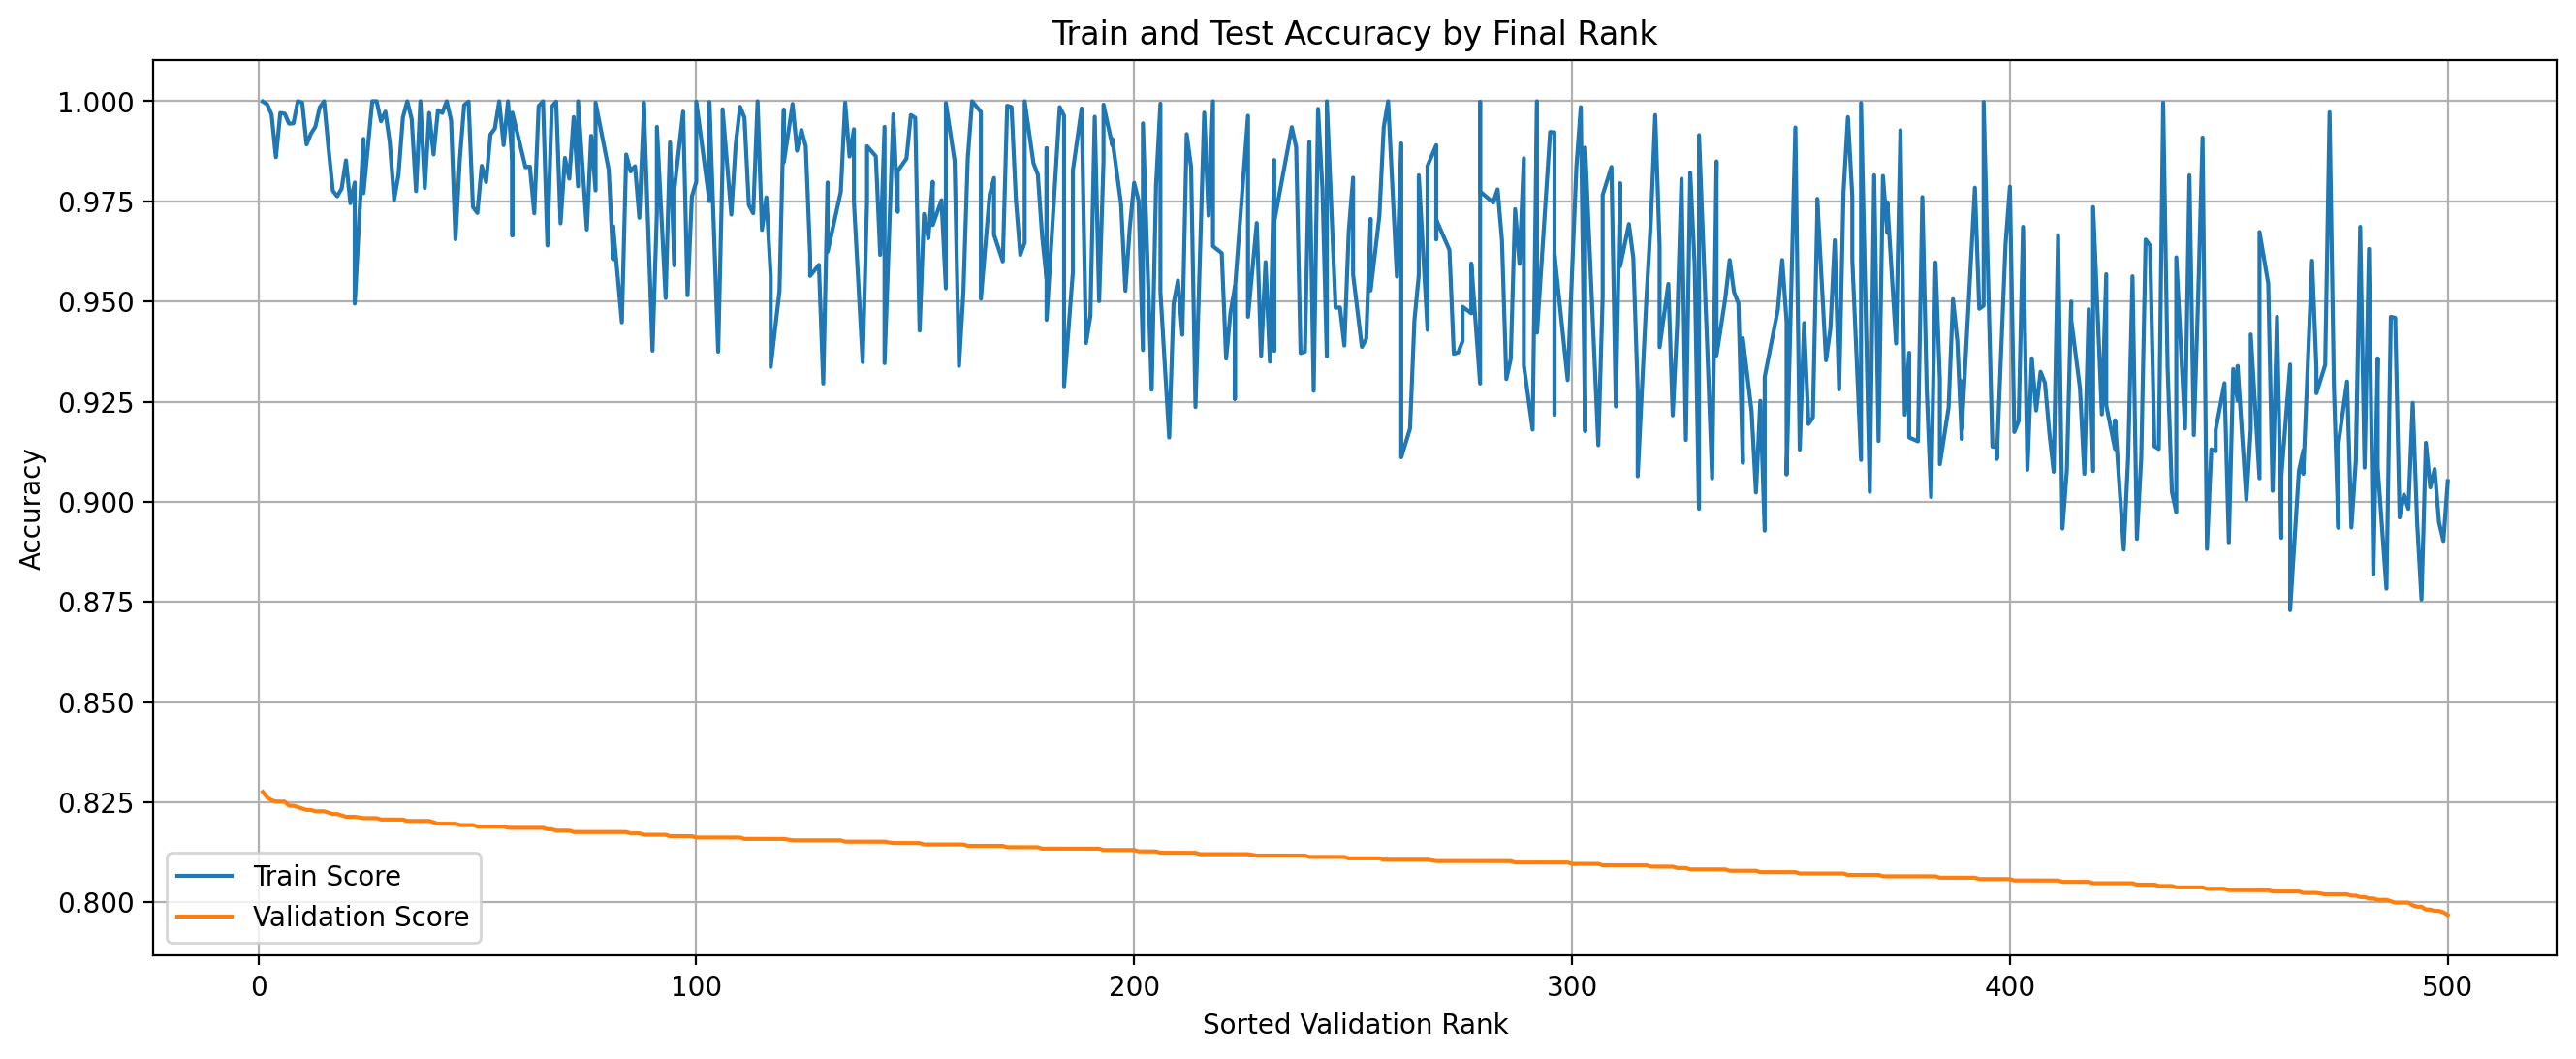

In [23]:
plt.figure(figsize=(16, 6))    

plt.plot(sorted_cv['rank_test_score'], sorted_cv['mean_train_score'], label="Train Score")
plt.plot(sorted_cv['rank_test_score'], sorted_cv['mean_test_score'], label="Validation Score")

plt.grid()
plt.xlabel('Sorted Validation Rank')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy by Final Rank')
plt.legend(loc='best')

filename = "test_train_by_rank.png"
plt.savefig(os.path.join(results_path, filename))

plt.show()

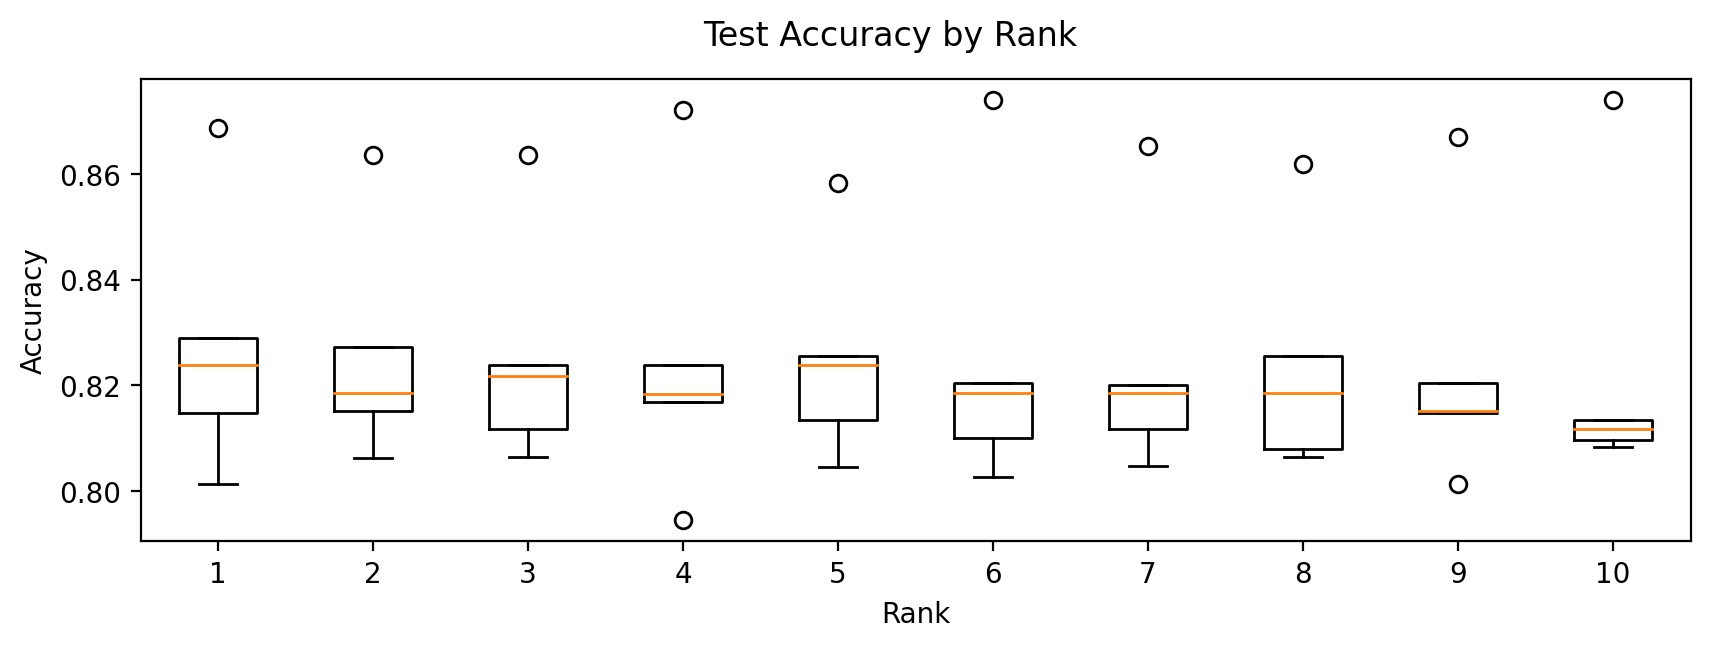

In [24]:
# boxplot algorithm comparison
fig = plt.figure(figsize=(10, 3))
fig.suptitle('Test Accuracy by Rank')

ax = fig.add_subplot(111)

plt.boxplot(sorted_cv.iloc[:10, :][['split0_test_score', 'split1_test_score', 'split2_test_score',
   'split3_test_score', 'split4_test_score']].T)
ax.set_xticklabels(range(1, 11))
ax.set_xlabel("Rank")
ax.set_ylabel("Accuracy")

filename = "test_accuracy_by_rank.png"
plt.savefig(os.path.join(results_path, filename))

plt.show()

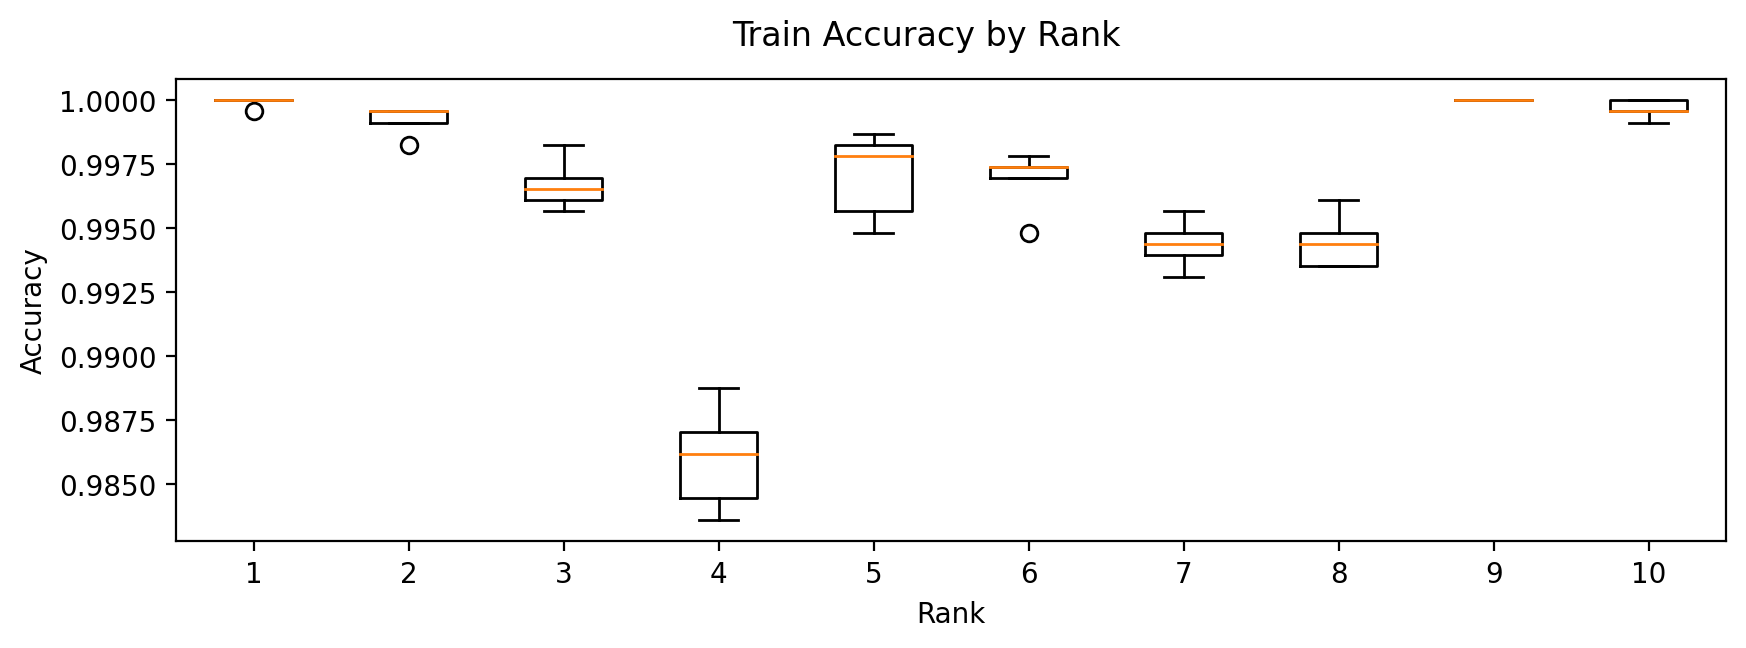

In [25]:
# boxplot algorithm comparison
fig = plt.figure(figsize=(10, 3))
fig.suptitle('Train Accuracy by Rank')

ax = fig.add_subplot(111)

plt.boxplot(sorted_cv.iloc[:10, :][['split0_train_score', 'split1_train_score', 'split2_train_score',
   'split3_train_score', 'split4_train_score']].T)
ax.set_xticklabels(range(1, 11))
ax.set_xlabel("Rank")
ax.set_ylabel("Accuracy")

filename = "train_accuracy_by_rank.png"
plt.savefig(os.path.join(results_path, filename))

plt.show()

In [26]:
max_params = cv_results.loc[cv_results['rank_test_score'] == 1]
best_params = max_params.params.values[0]

In [27]:
print(f"Mean Train Accuracy = {max_params['mean_train_score'].values[0]:.2f}")
print(f"Mean Validation Accuracy = {max_params['mean_test_score'].values[0]:.2f}")

Mean Train Accuracy = 1.00
Mean Validation Accuracy = 0.83


In [28]:
random_search = pickle.load(open(os.path.join(f'./tuning_results/tuning_xgb/{timestamp}/', file_name), "rb"))
model = random_search.best_estimator_

#model = XGBClassifier(**best_params)
#model.fit(X_train, y_train)

y_train_prediction = model.predict(X_train)
y_test_prediction = model.predict(X_test)

In [29]:
print(f"Train set, Accuracy = {accuracy_score(y_train, y_train_prediction):.2f}")
print(f"Test set, Accuracy = {accuracy_score(y_test, y_test_prediction):.2f}")

Train set, Accuracy = 1.00
Test set, Accuracy = 0.83


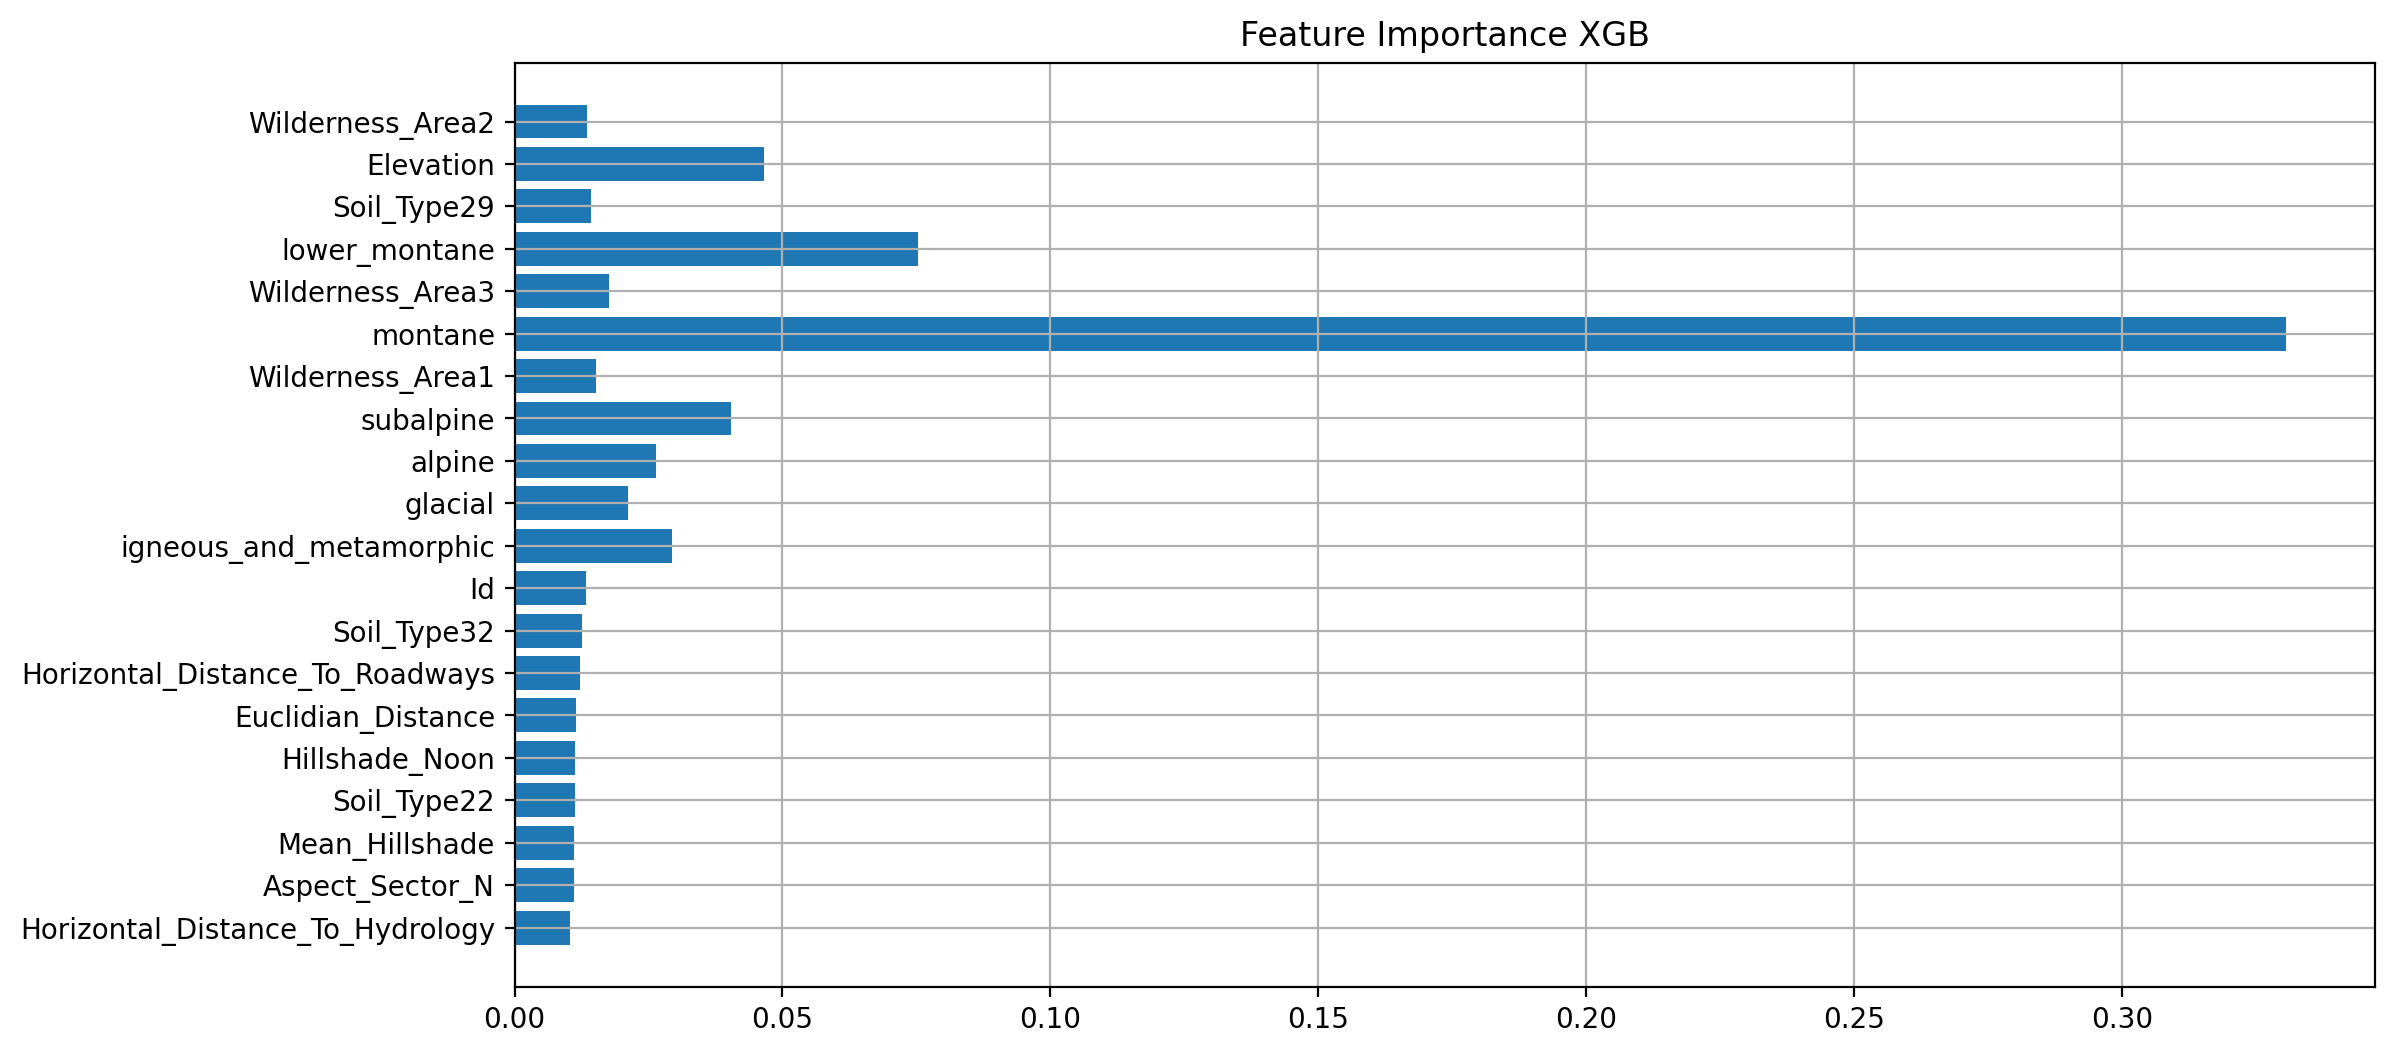

In [30]:
ind = np.argpartition(model.feature_importances_, -20)[-20:]

features = X.columns[ind]
importance = model.feature_importances_[ind]

fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(ind)), importance, align='center')
plt.yticks(range(len(ind)), features)
plt.title('Feature Importance XGB')
plt.grid()

filename = "feature_importance.png"
plt.savefig(os.path.join(results_path, filename))
            
plt.show()

In the context of XGBoost, these scores are often computed based on the following:

- Weight: The number of times a feature appears in a tree across the ensemble of trees.
- Gain: The average gain of a feature when it is used in trees.
- Cover: The average coverage of a feature when it is used in trees.

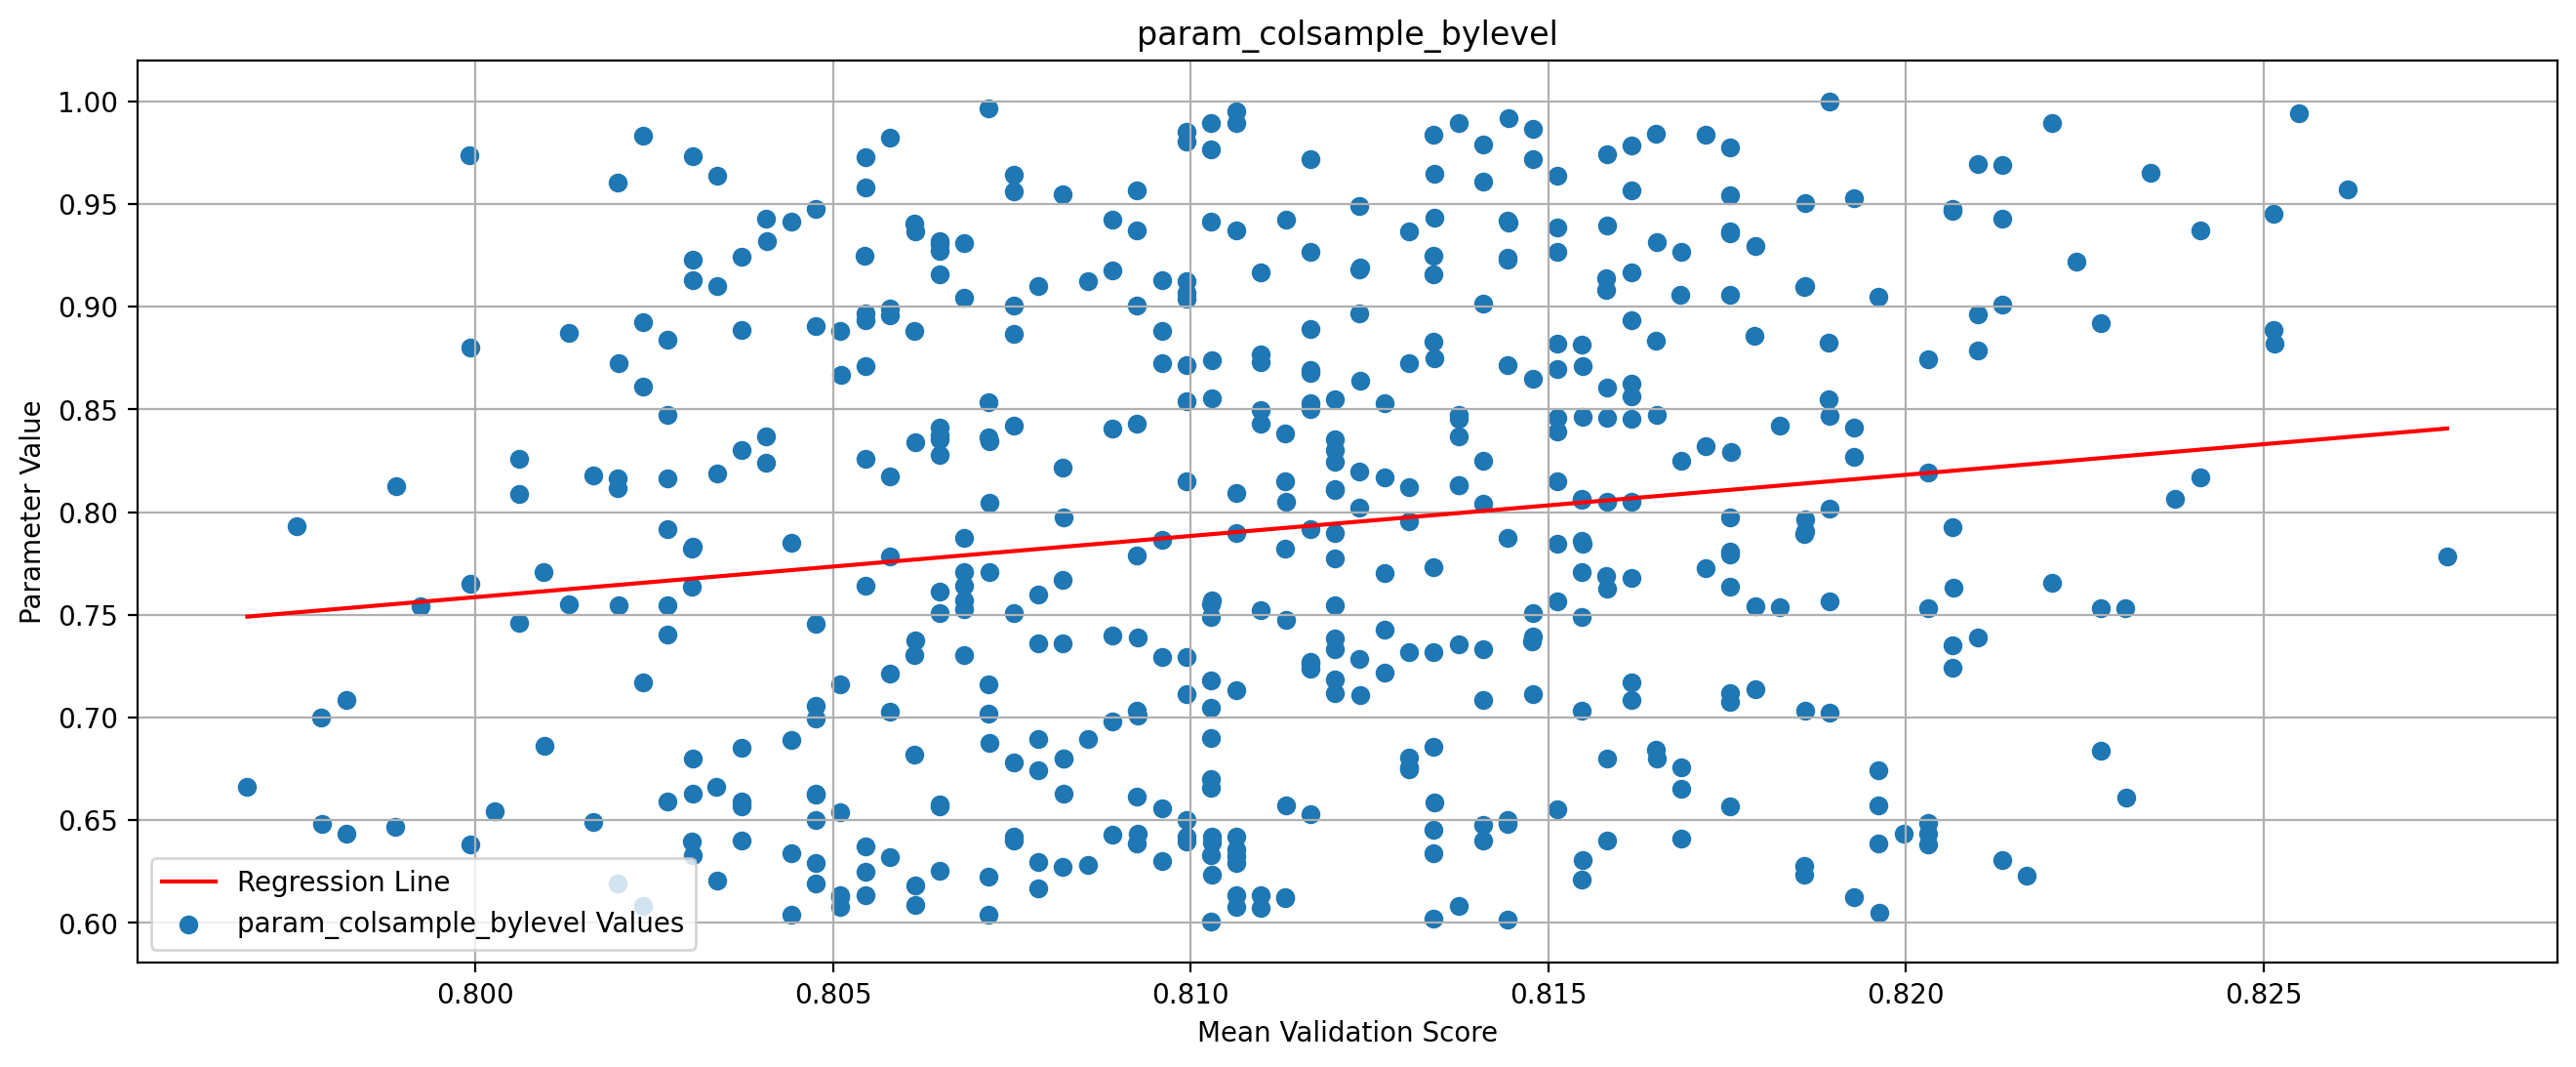

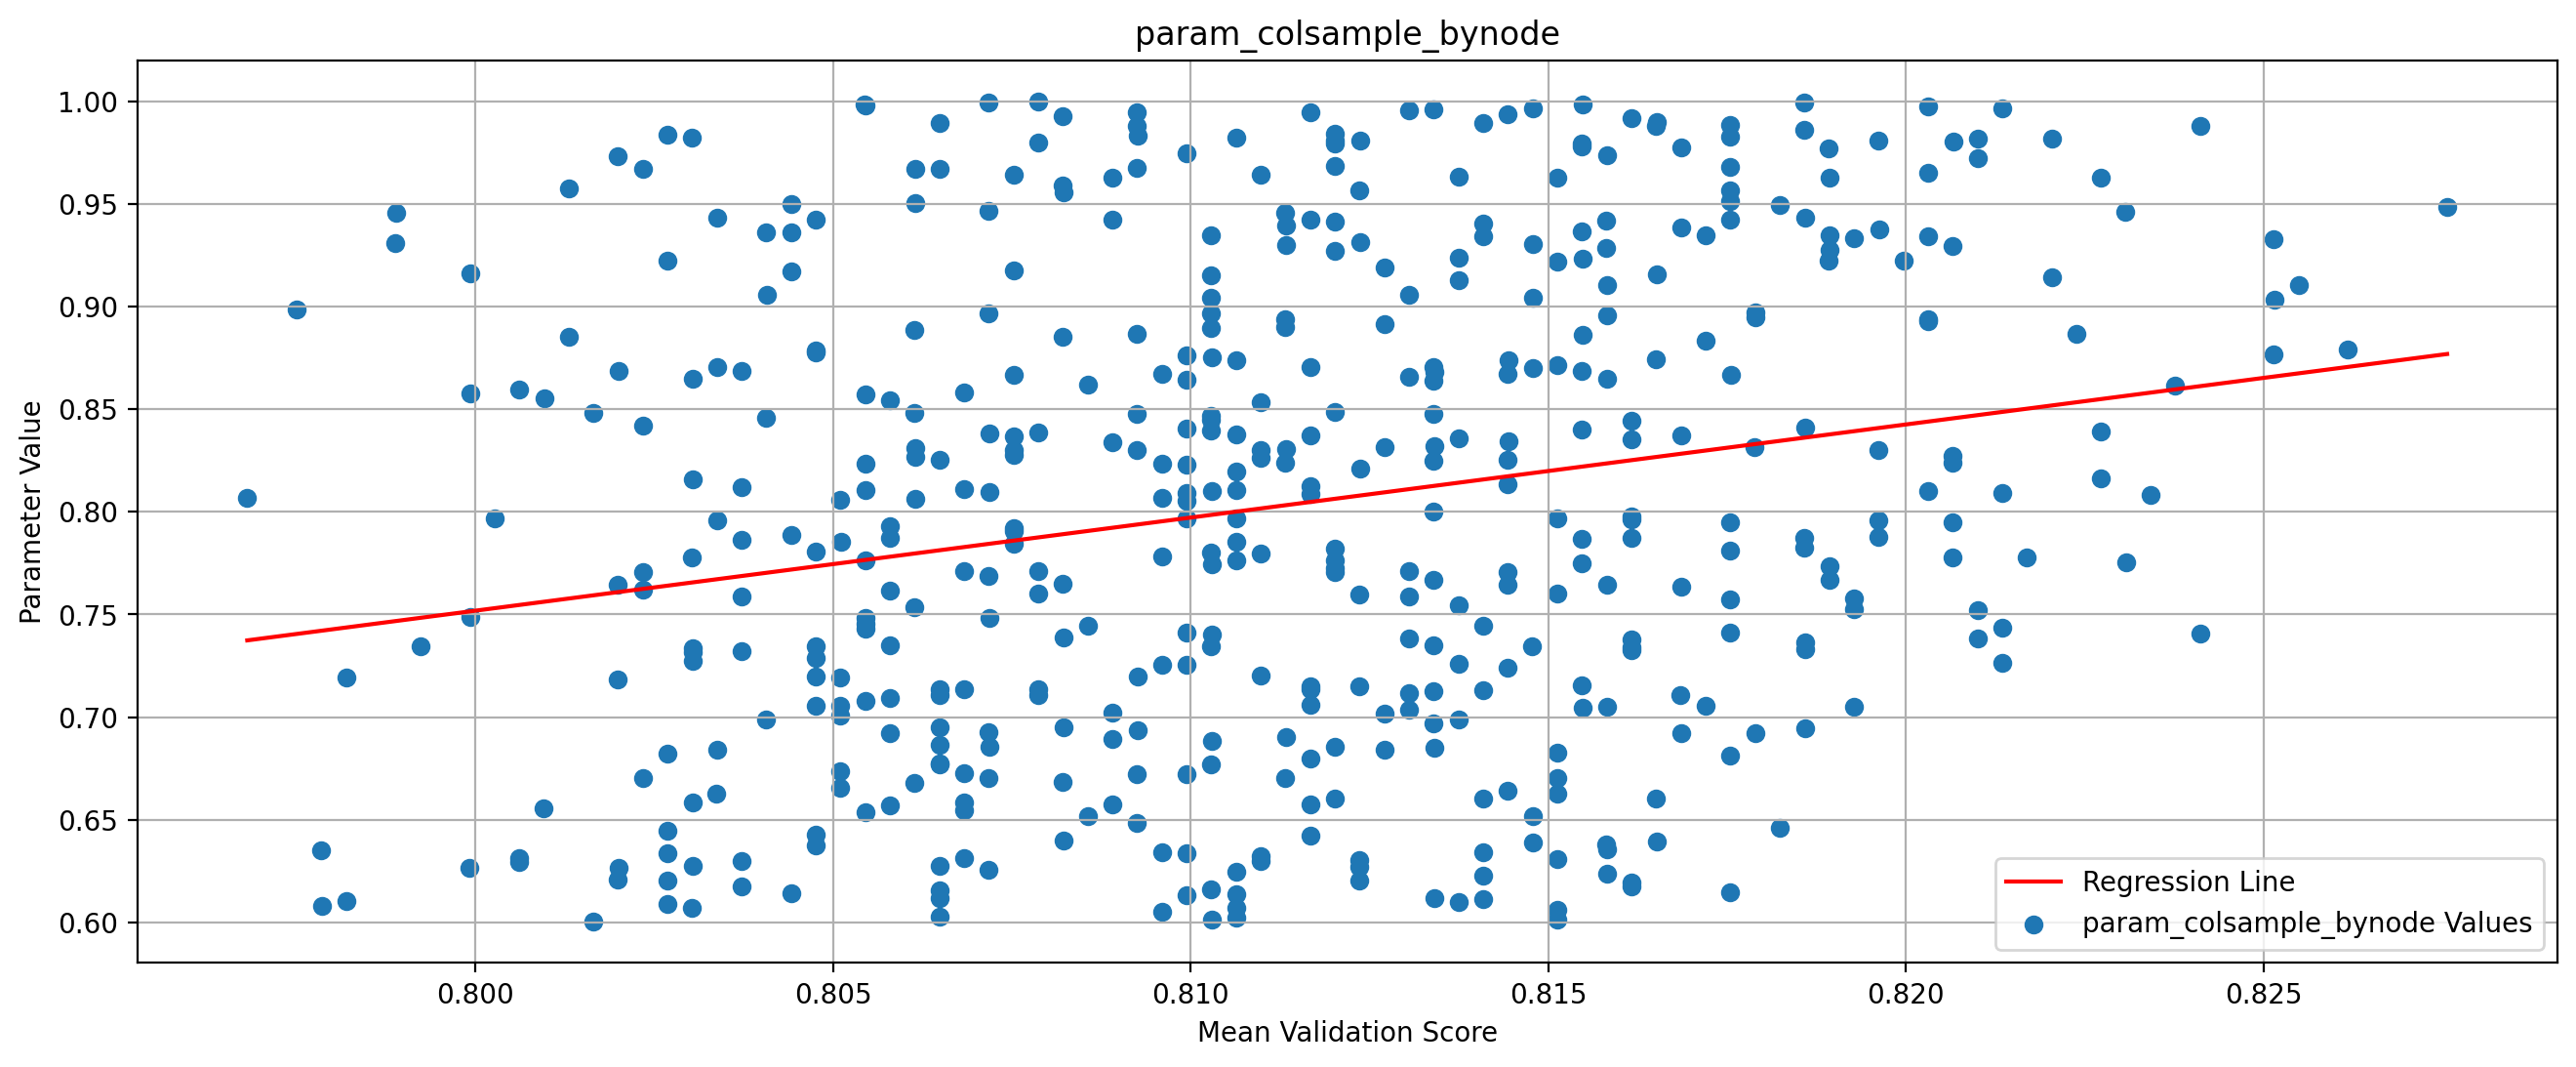

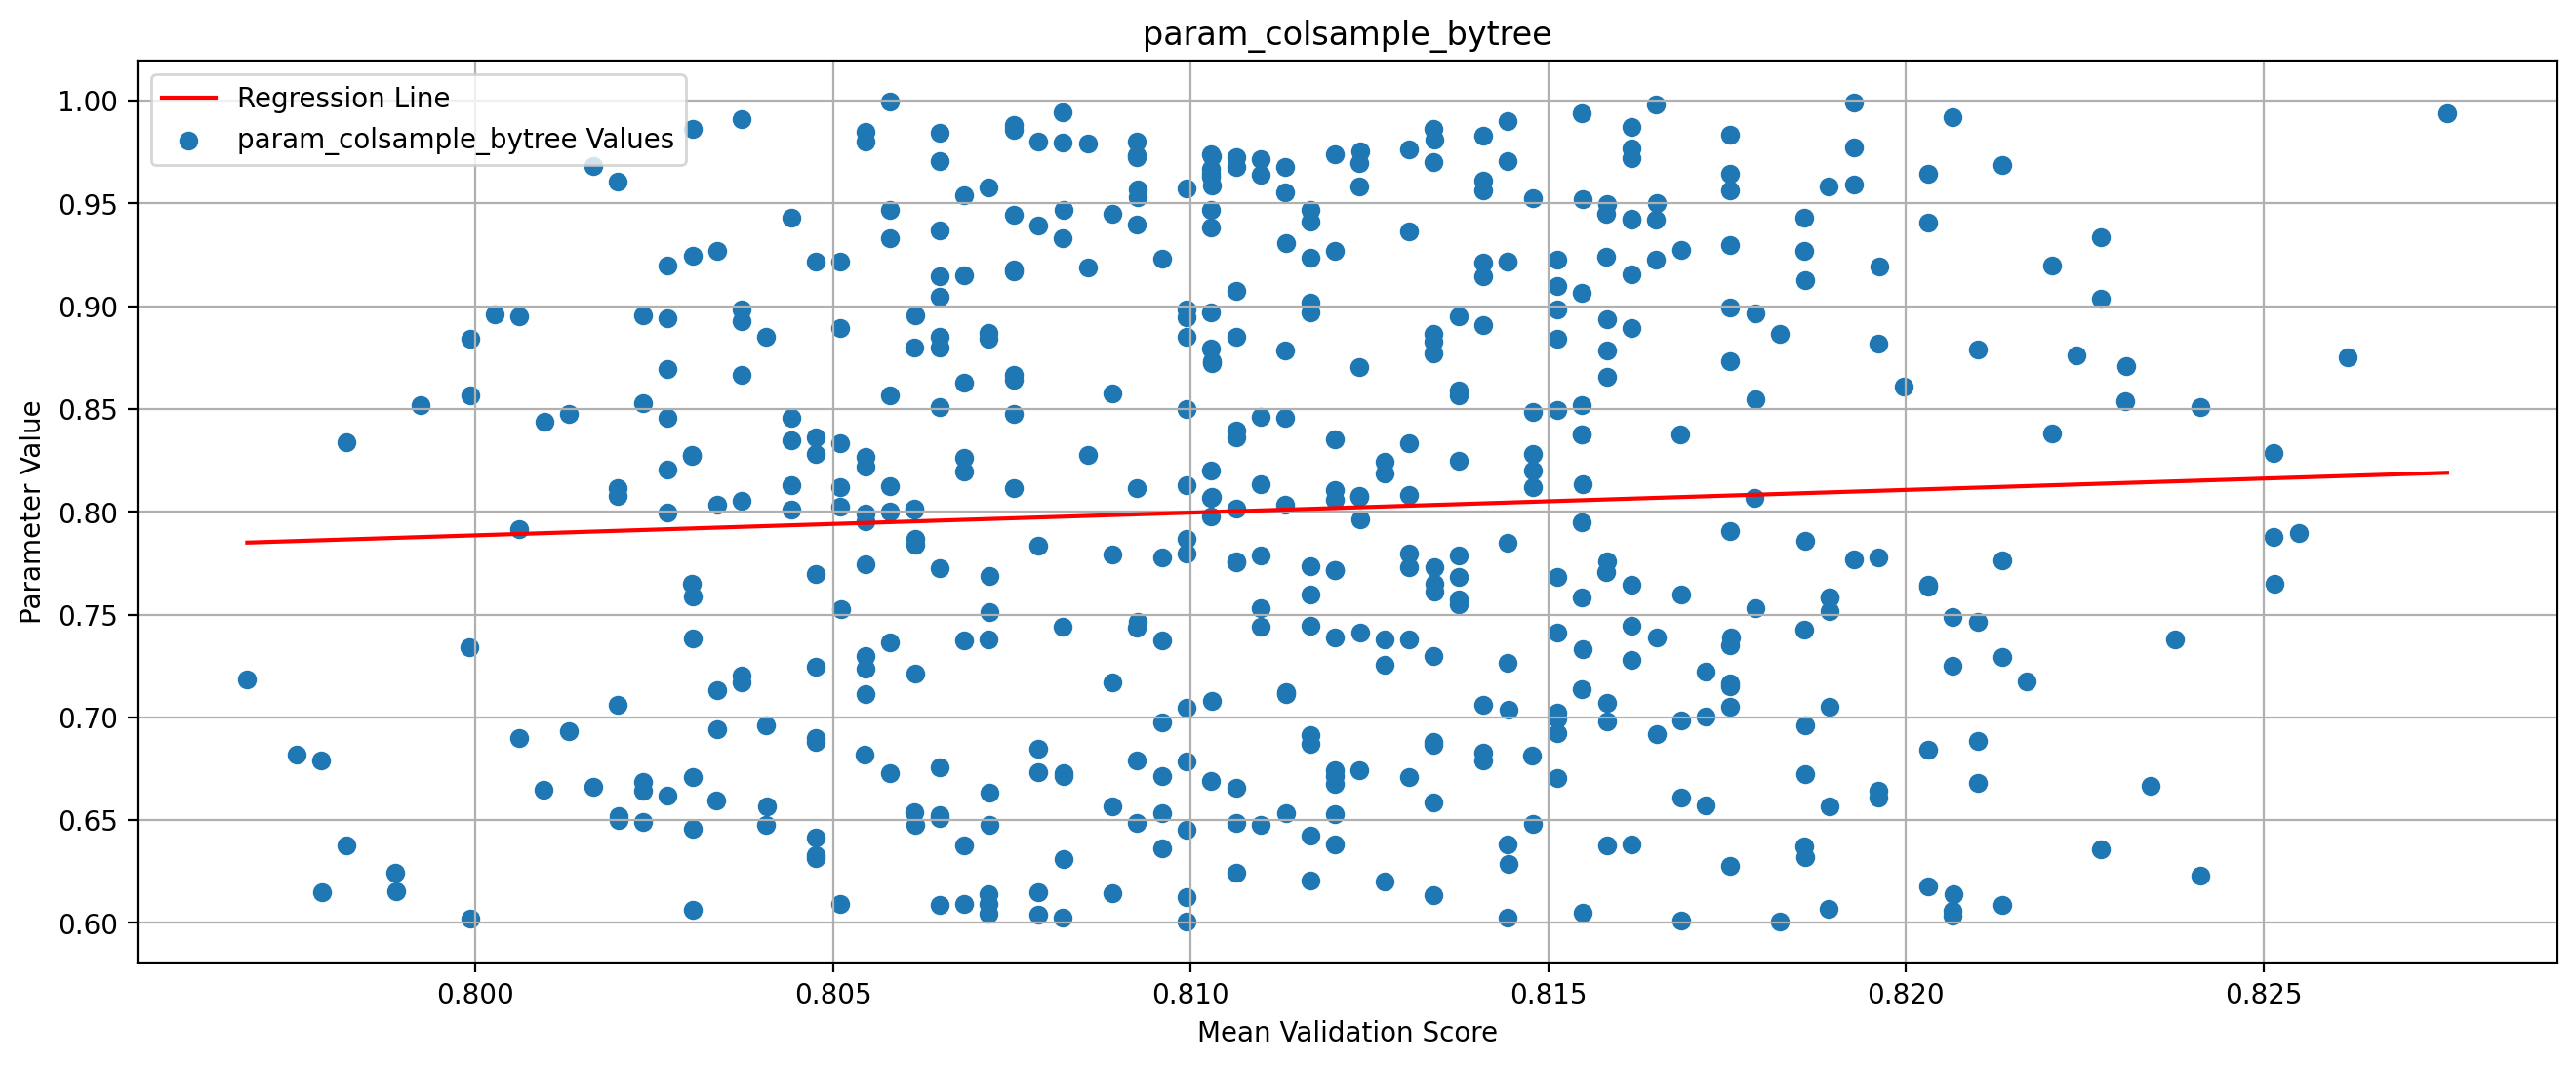

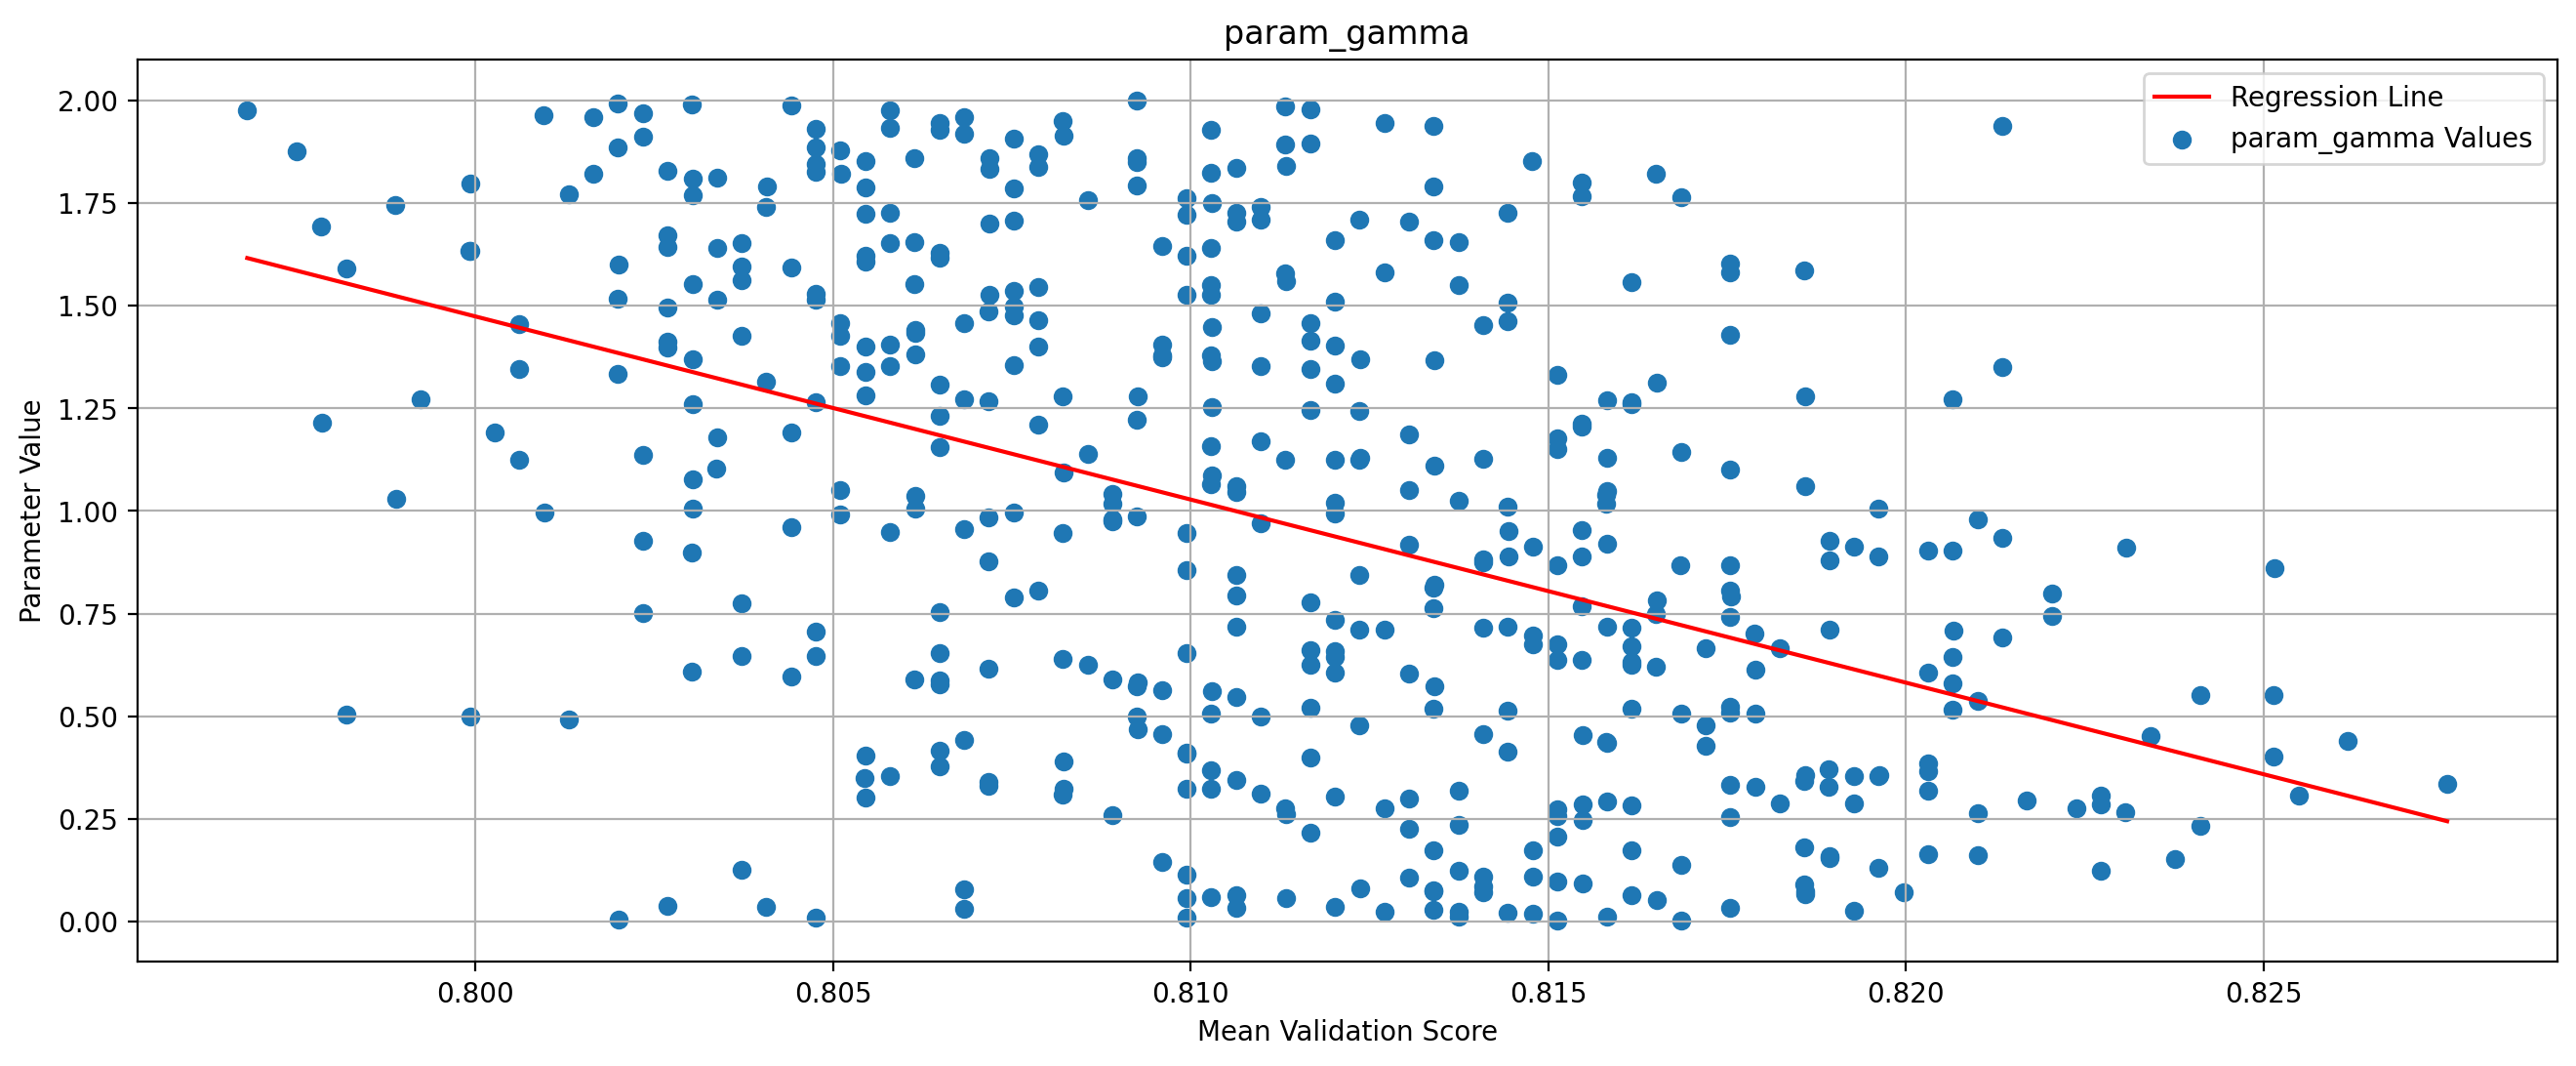

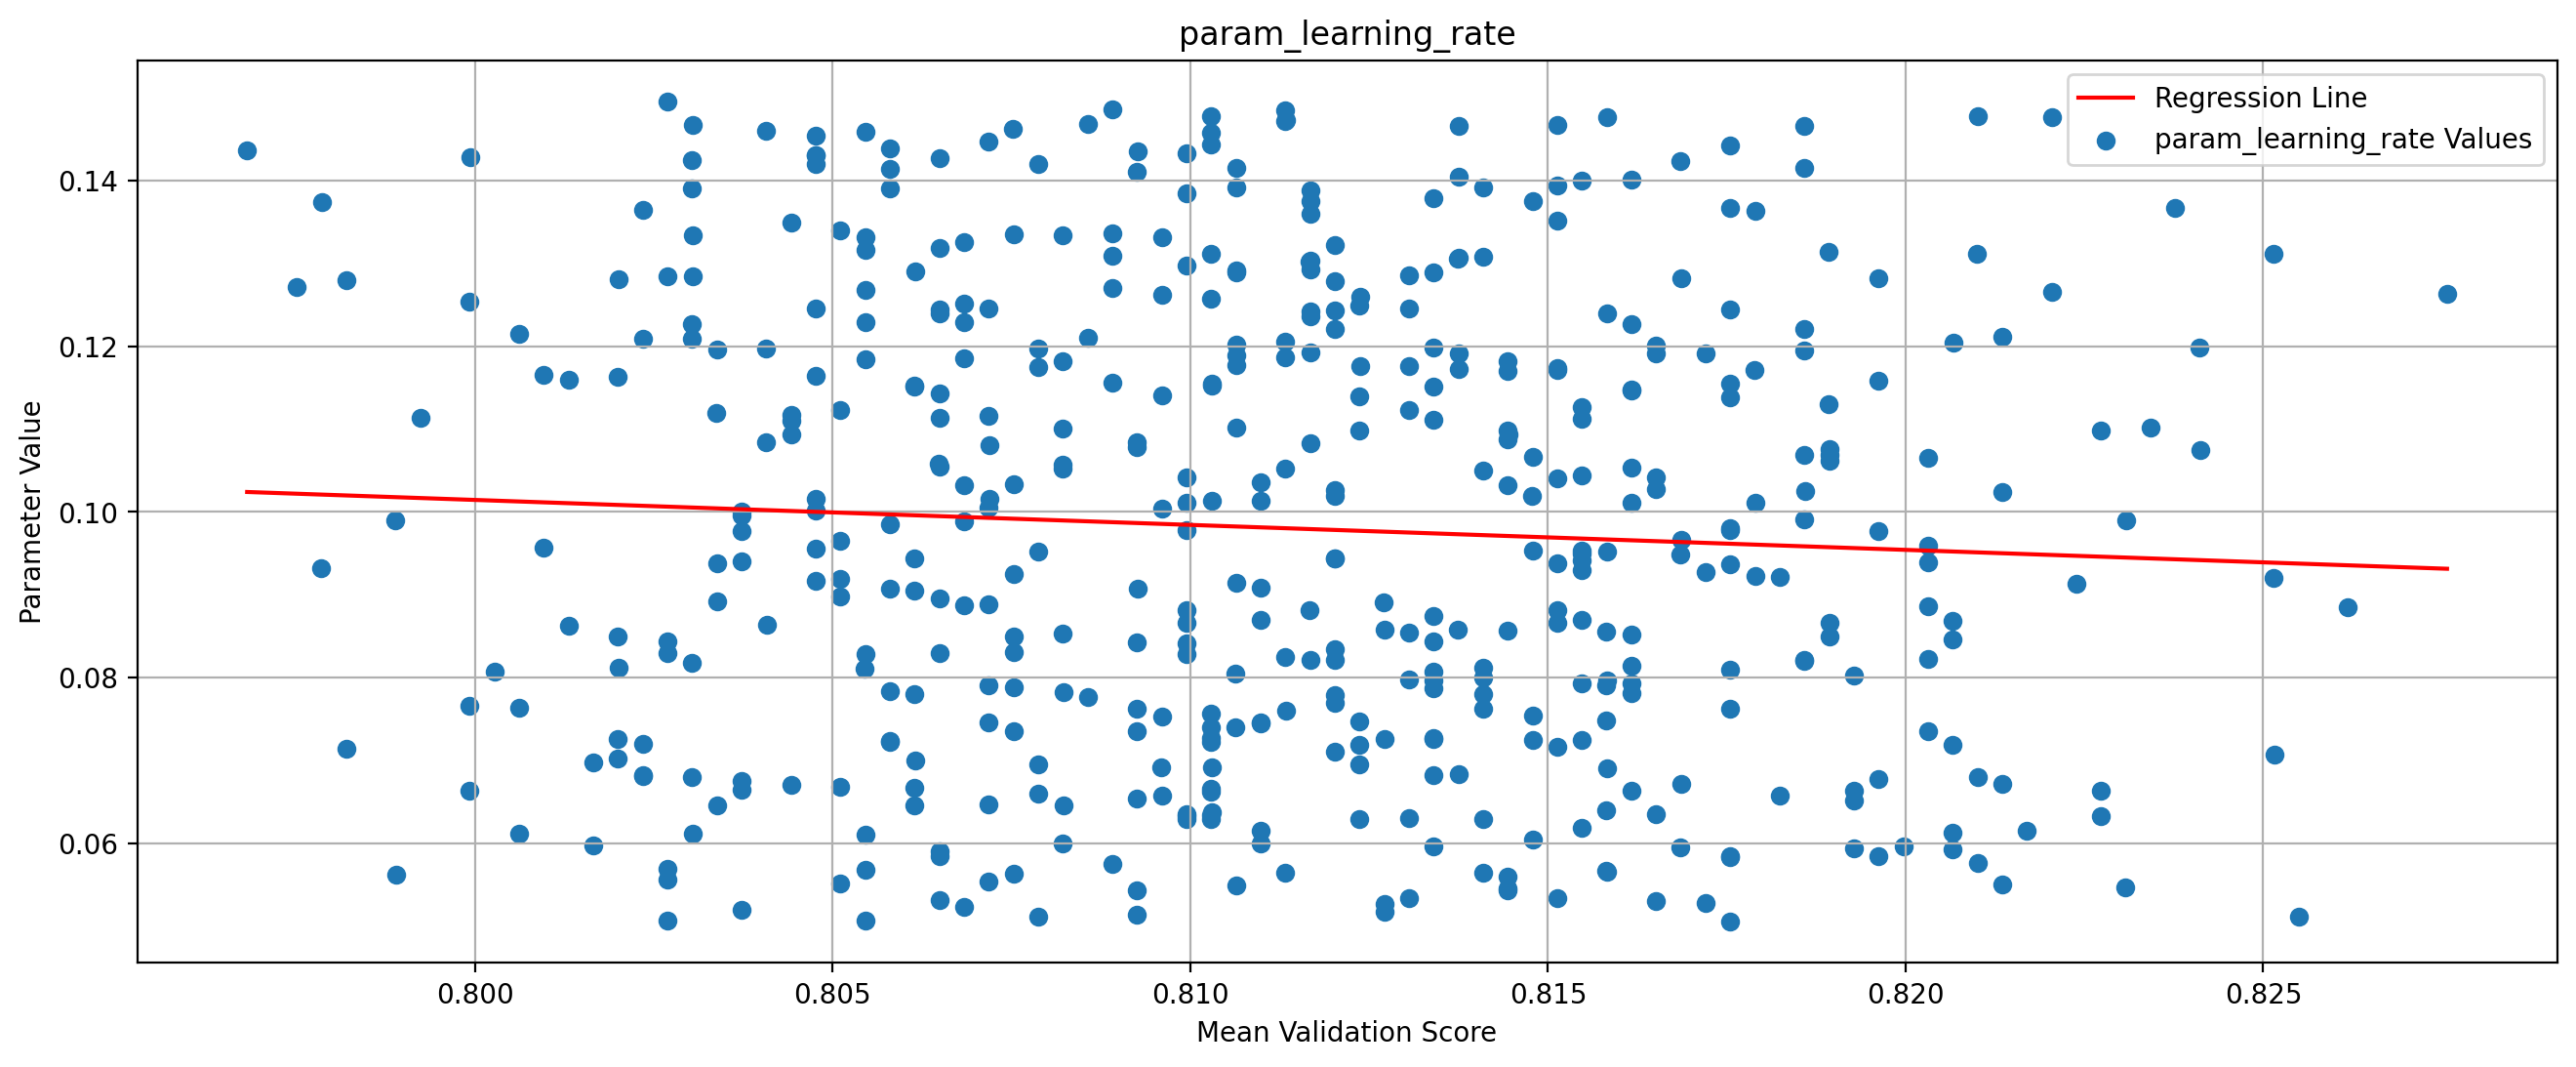

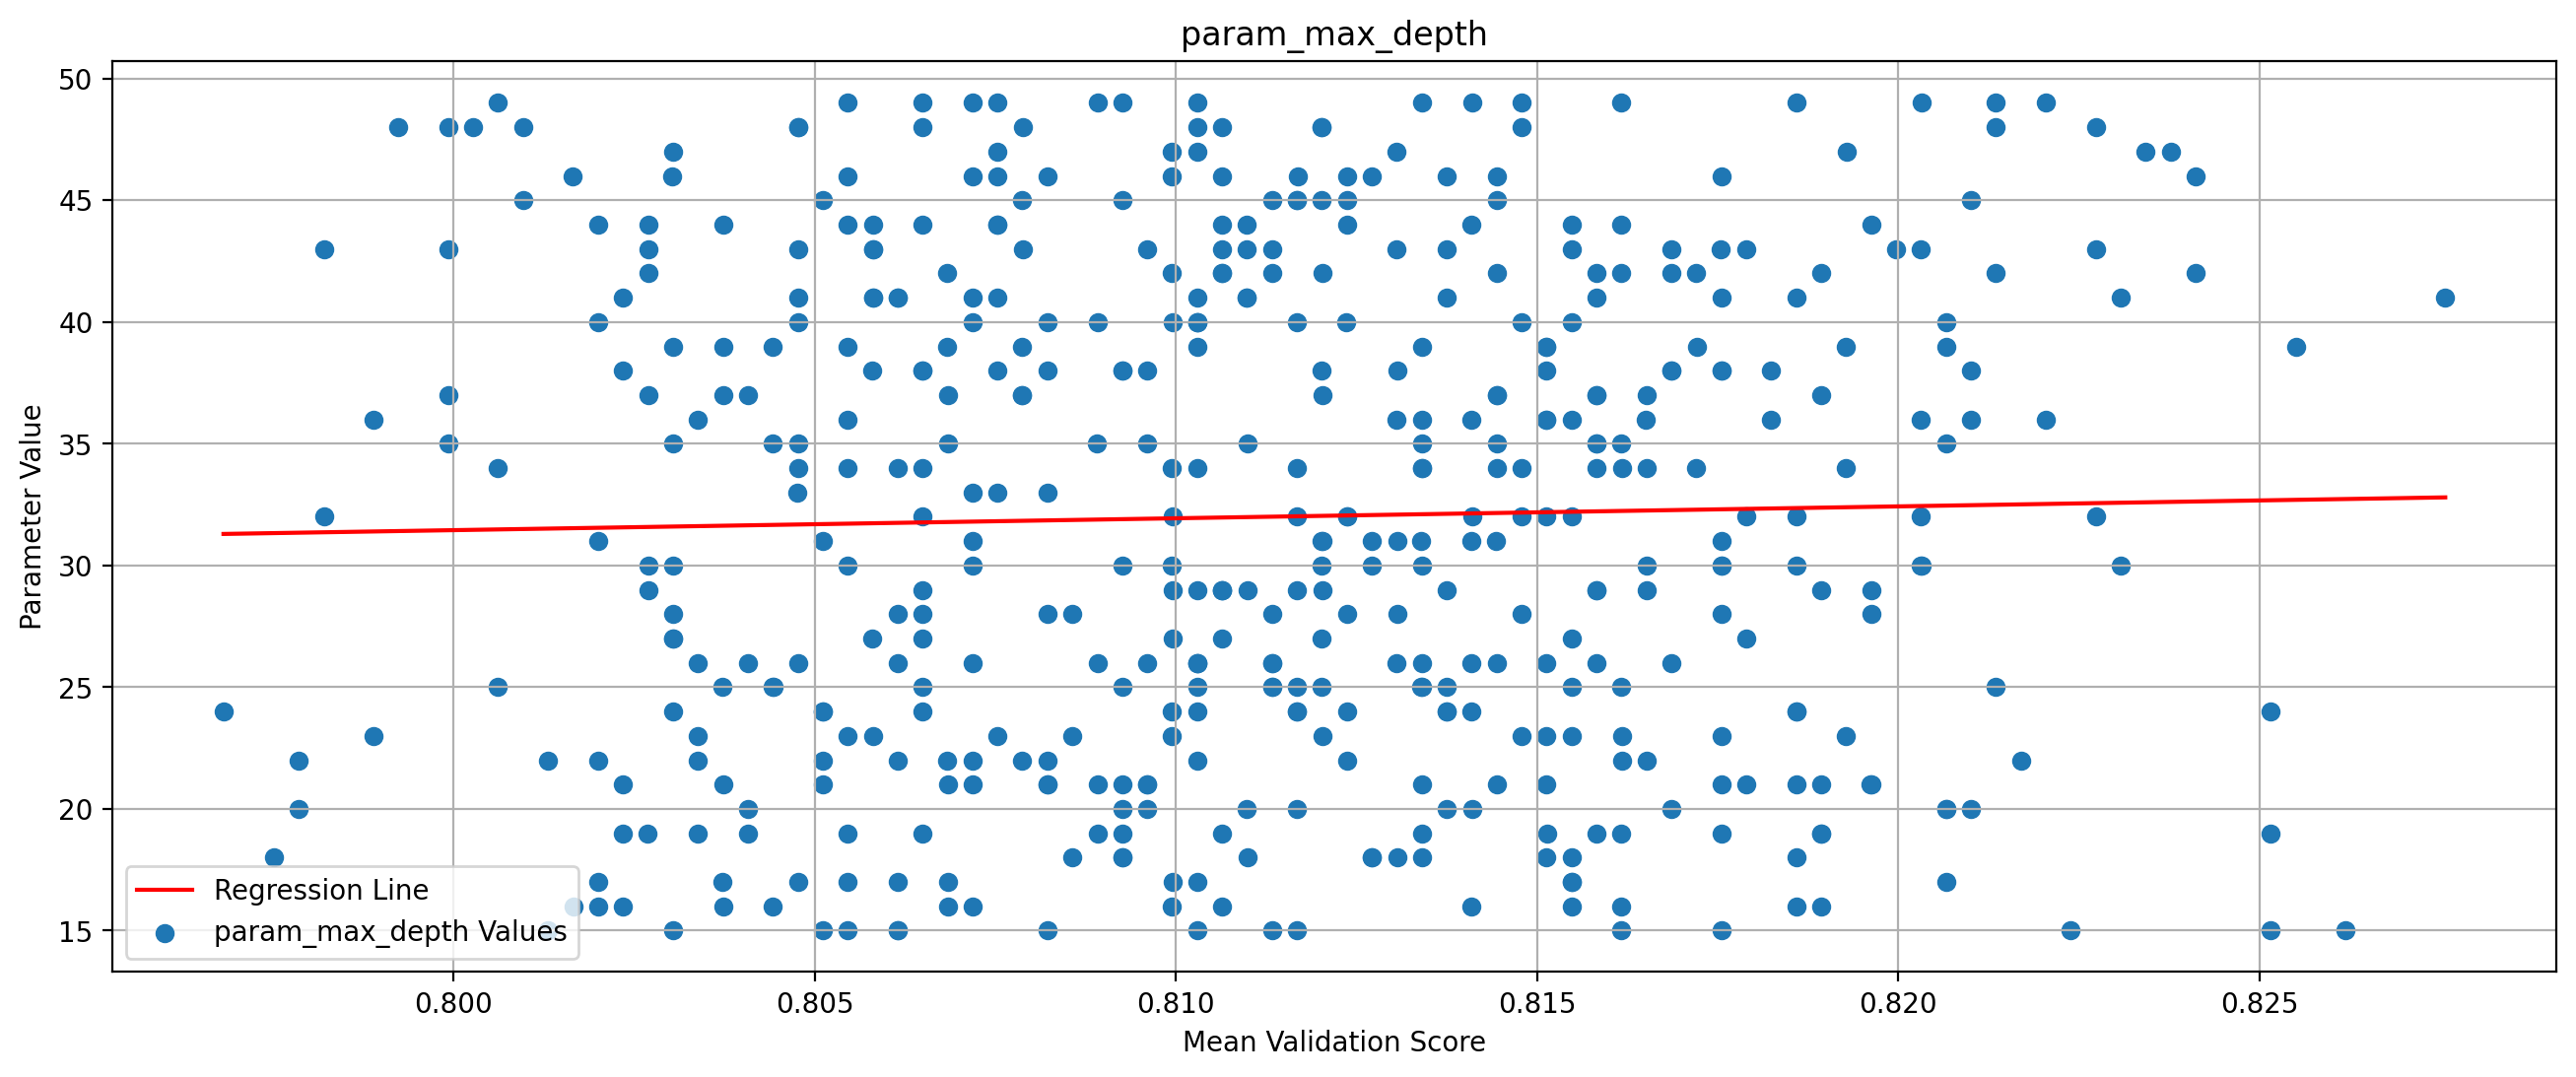

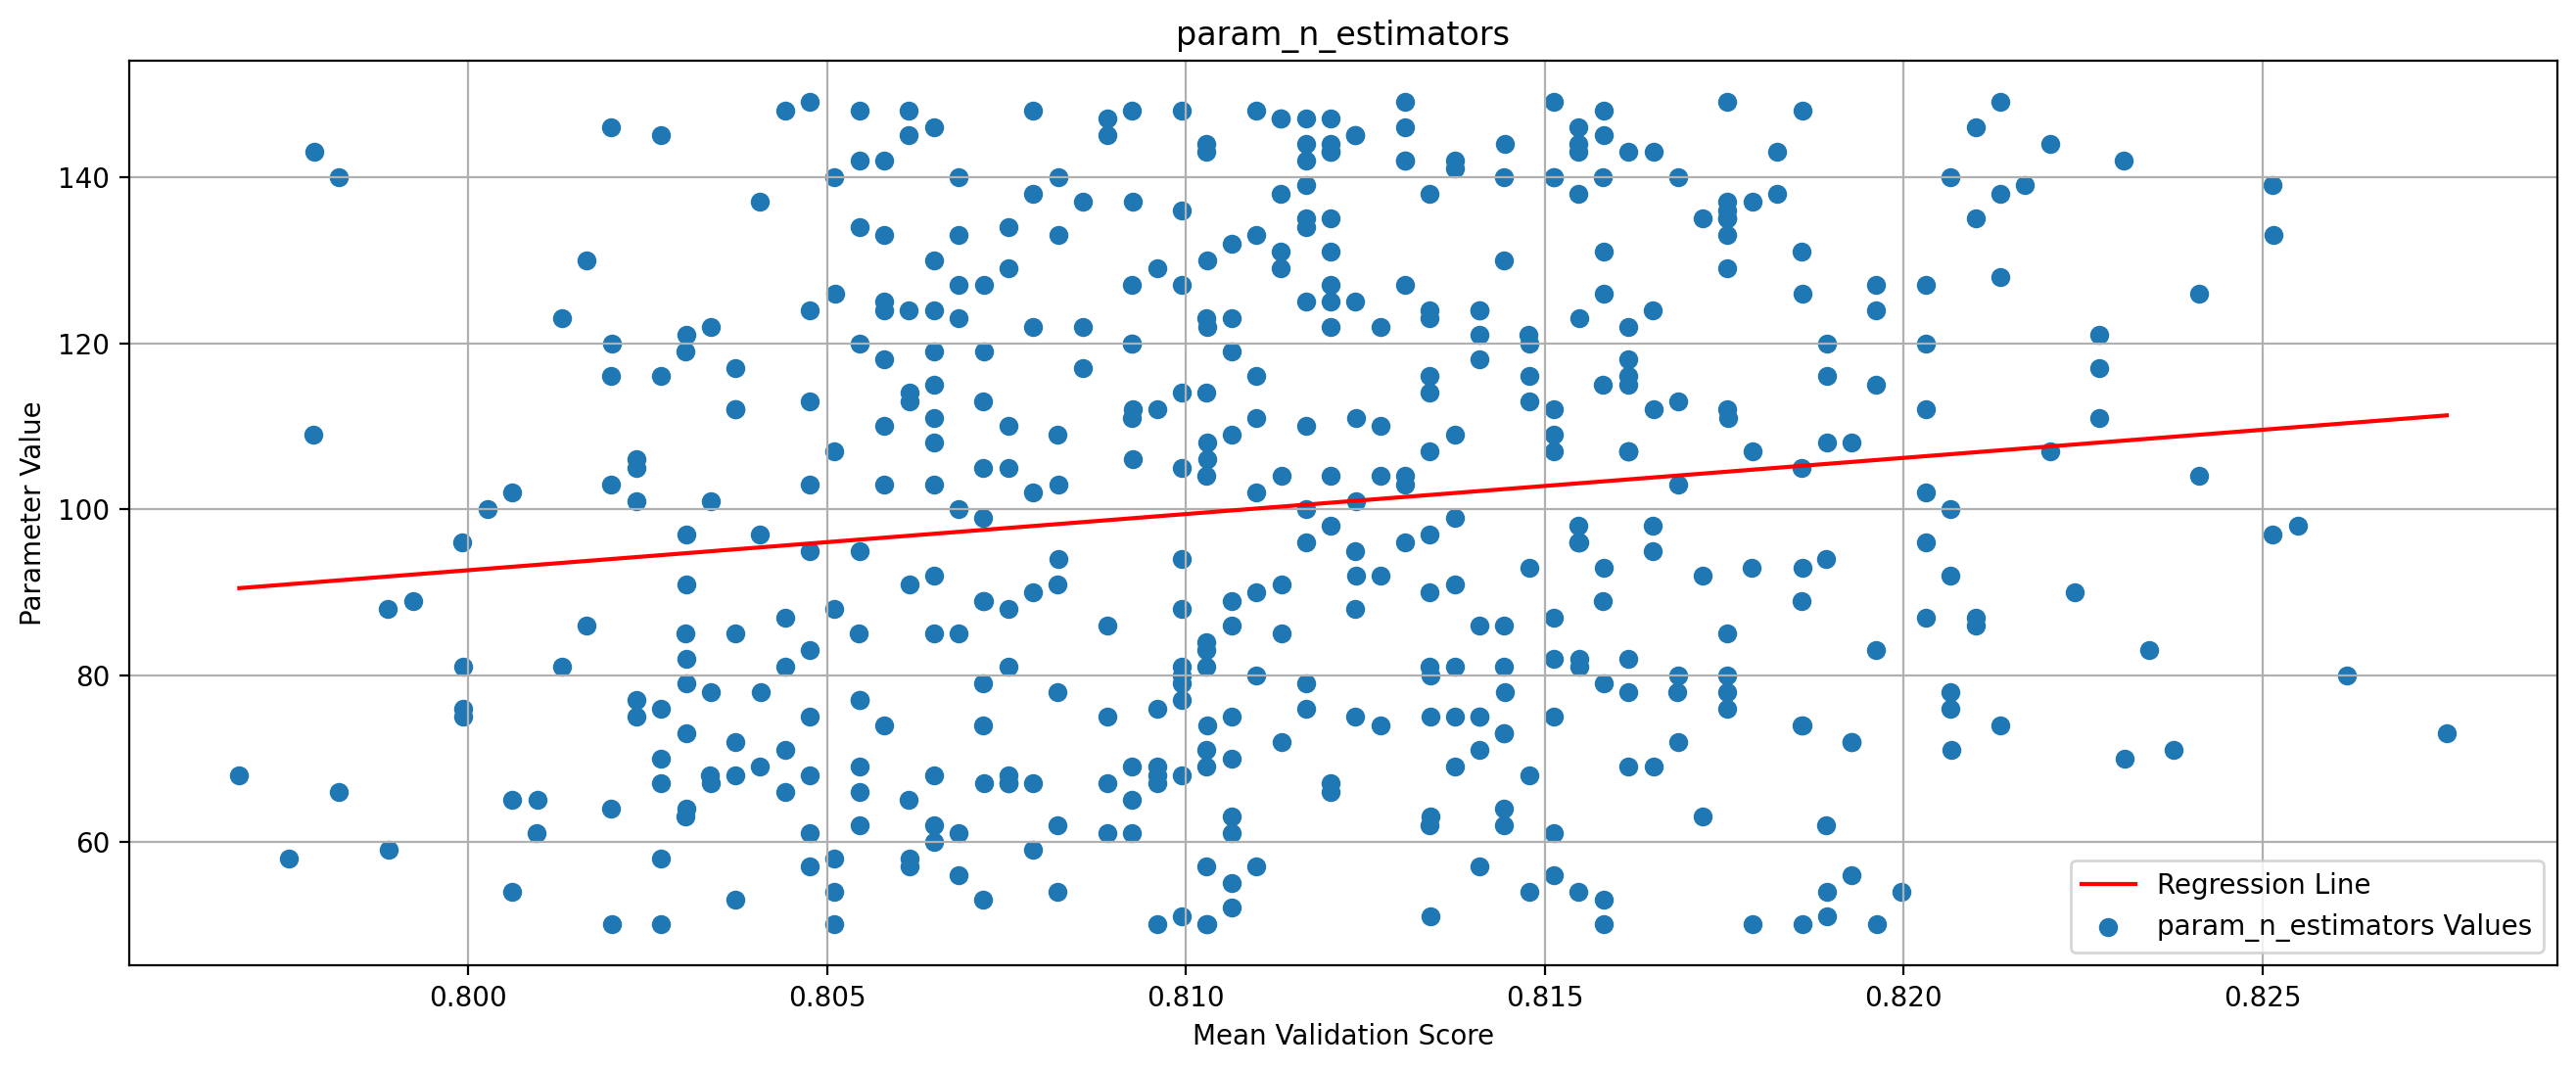

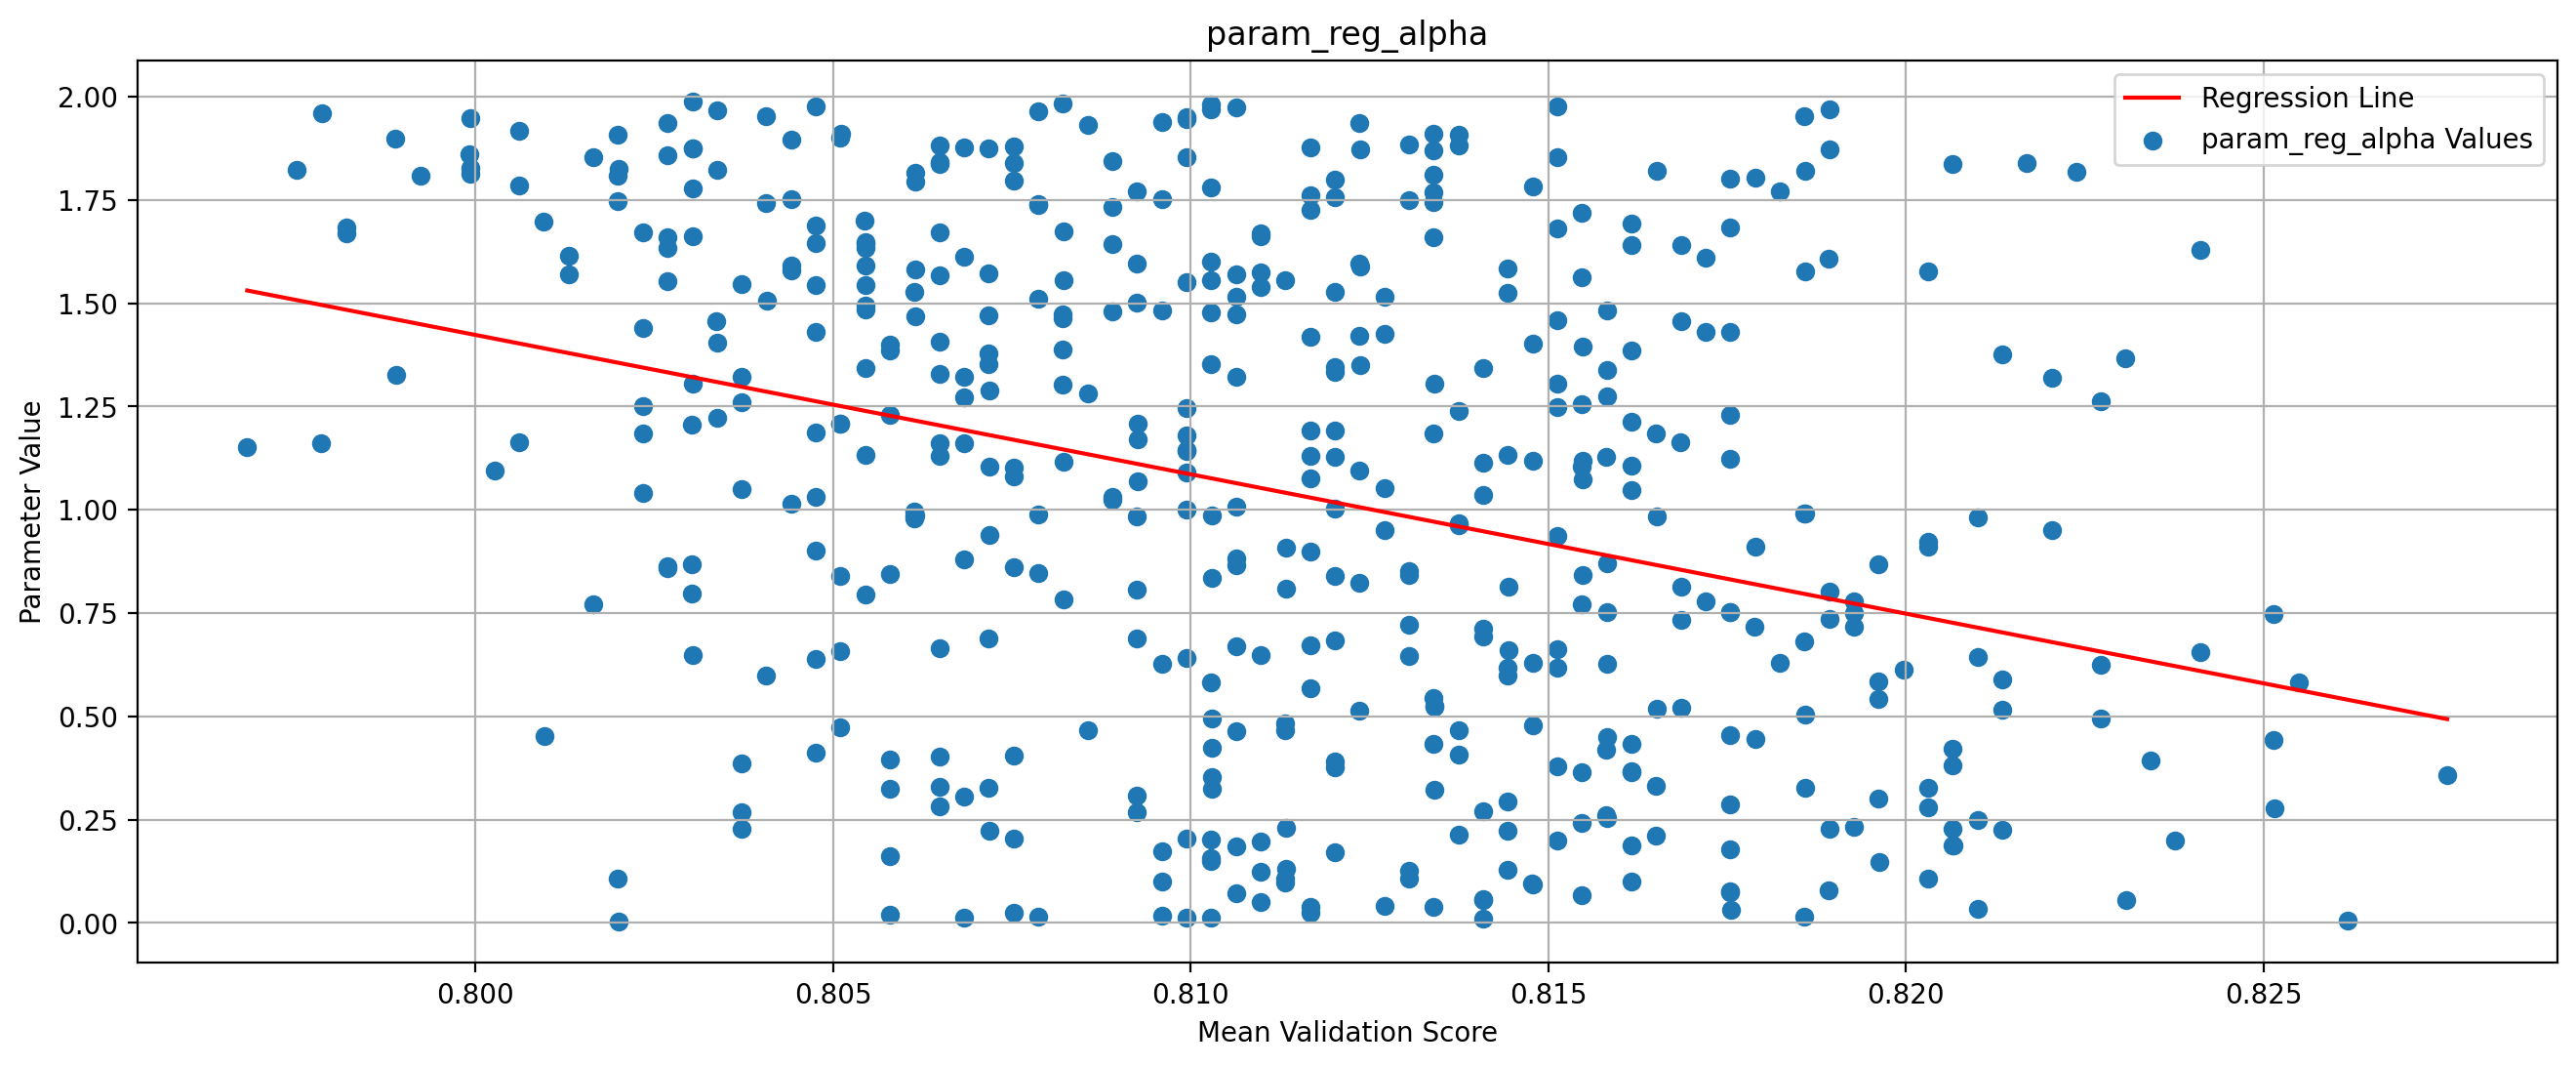

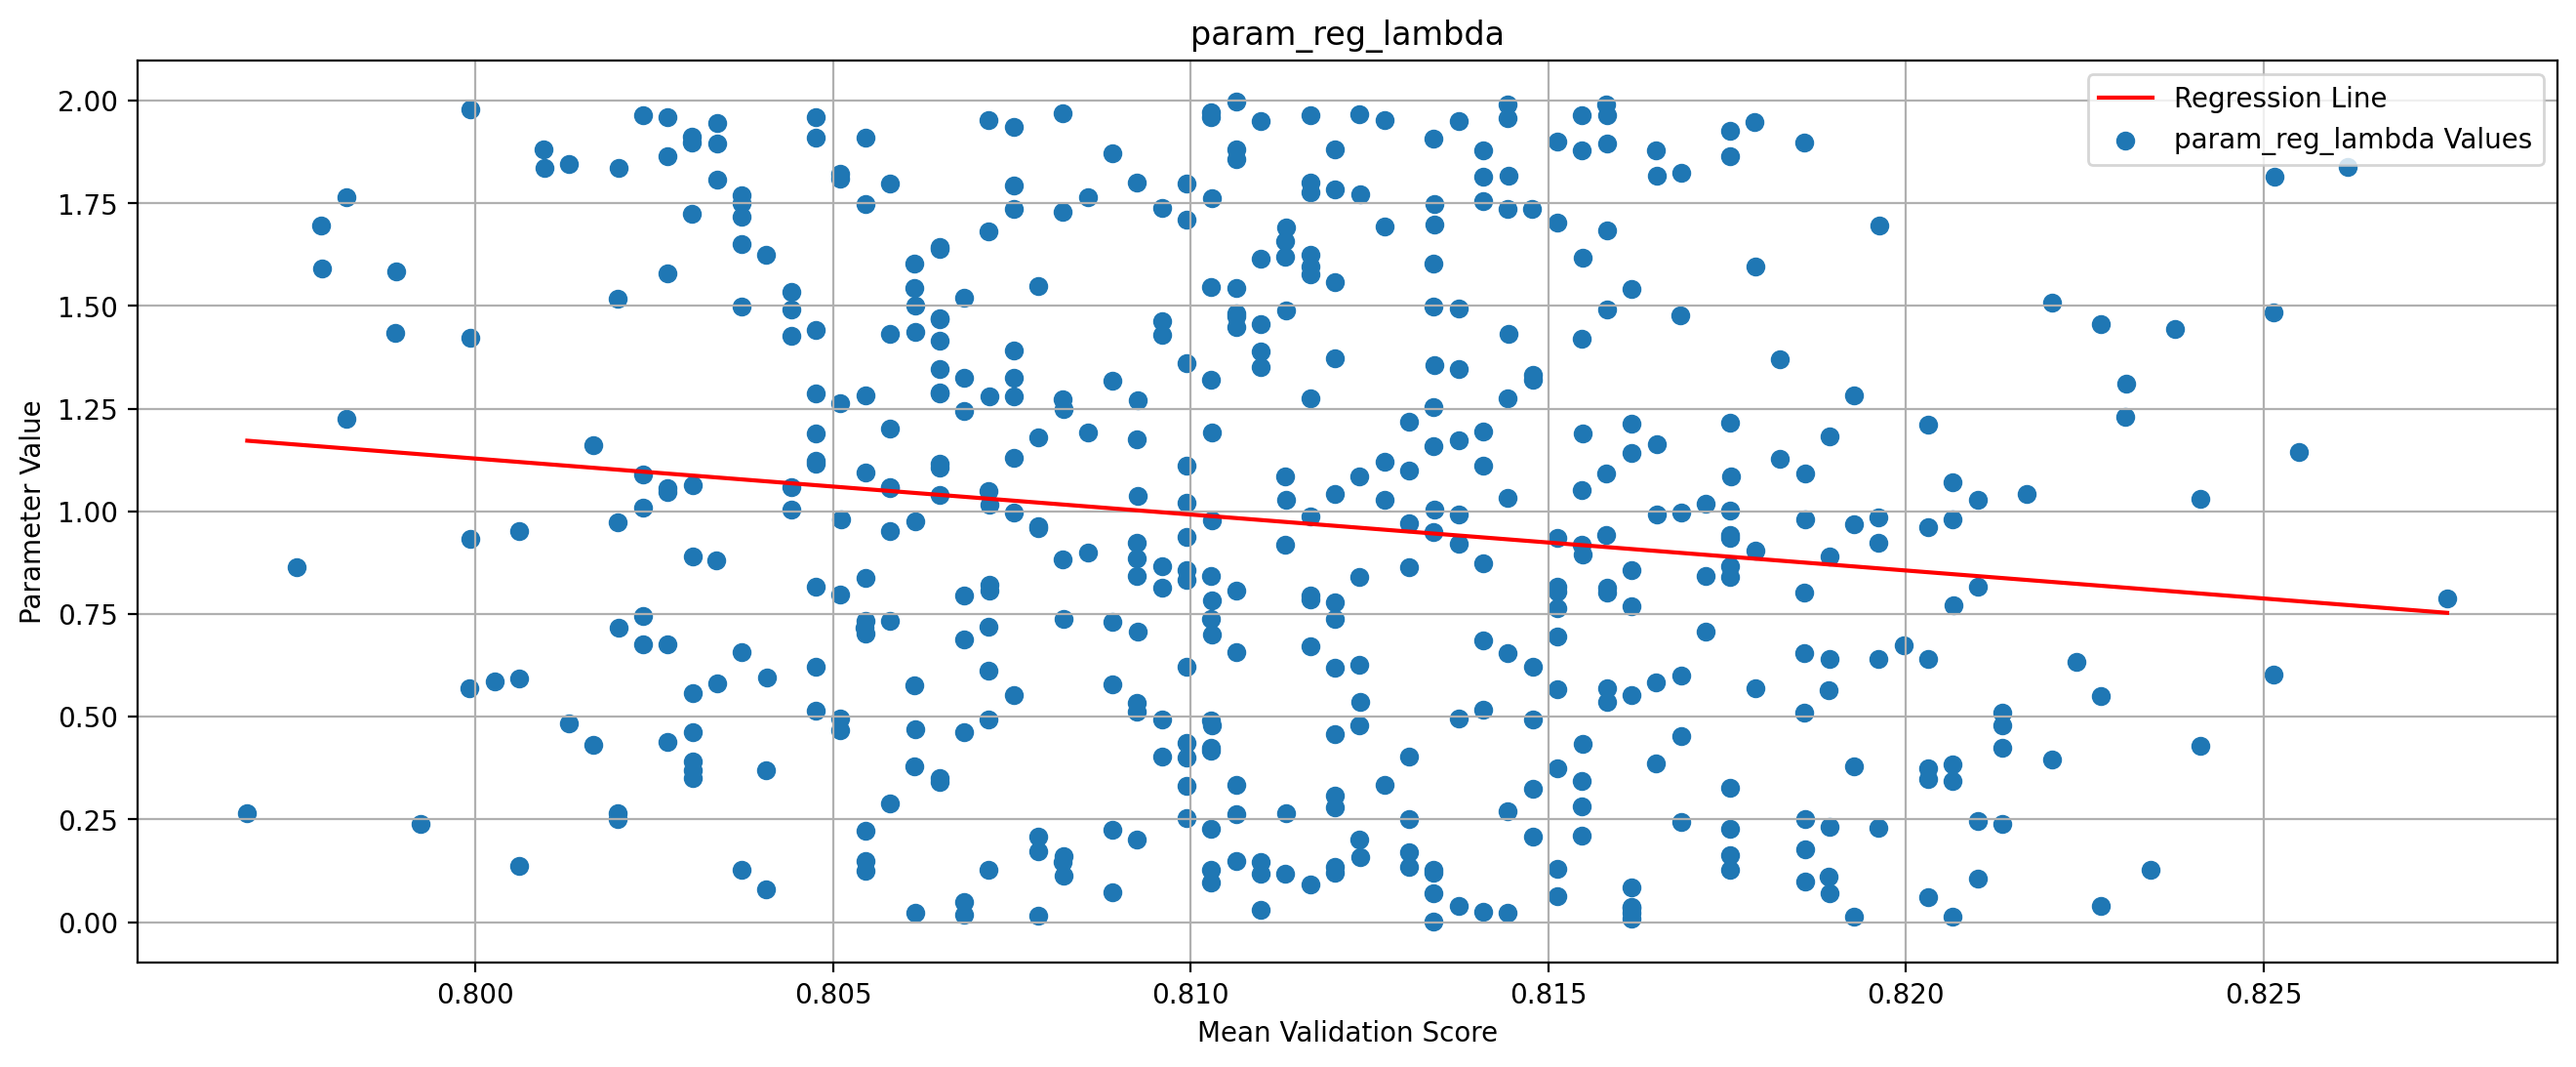

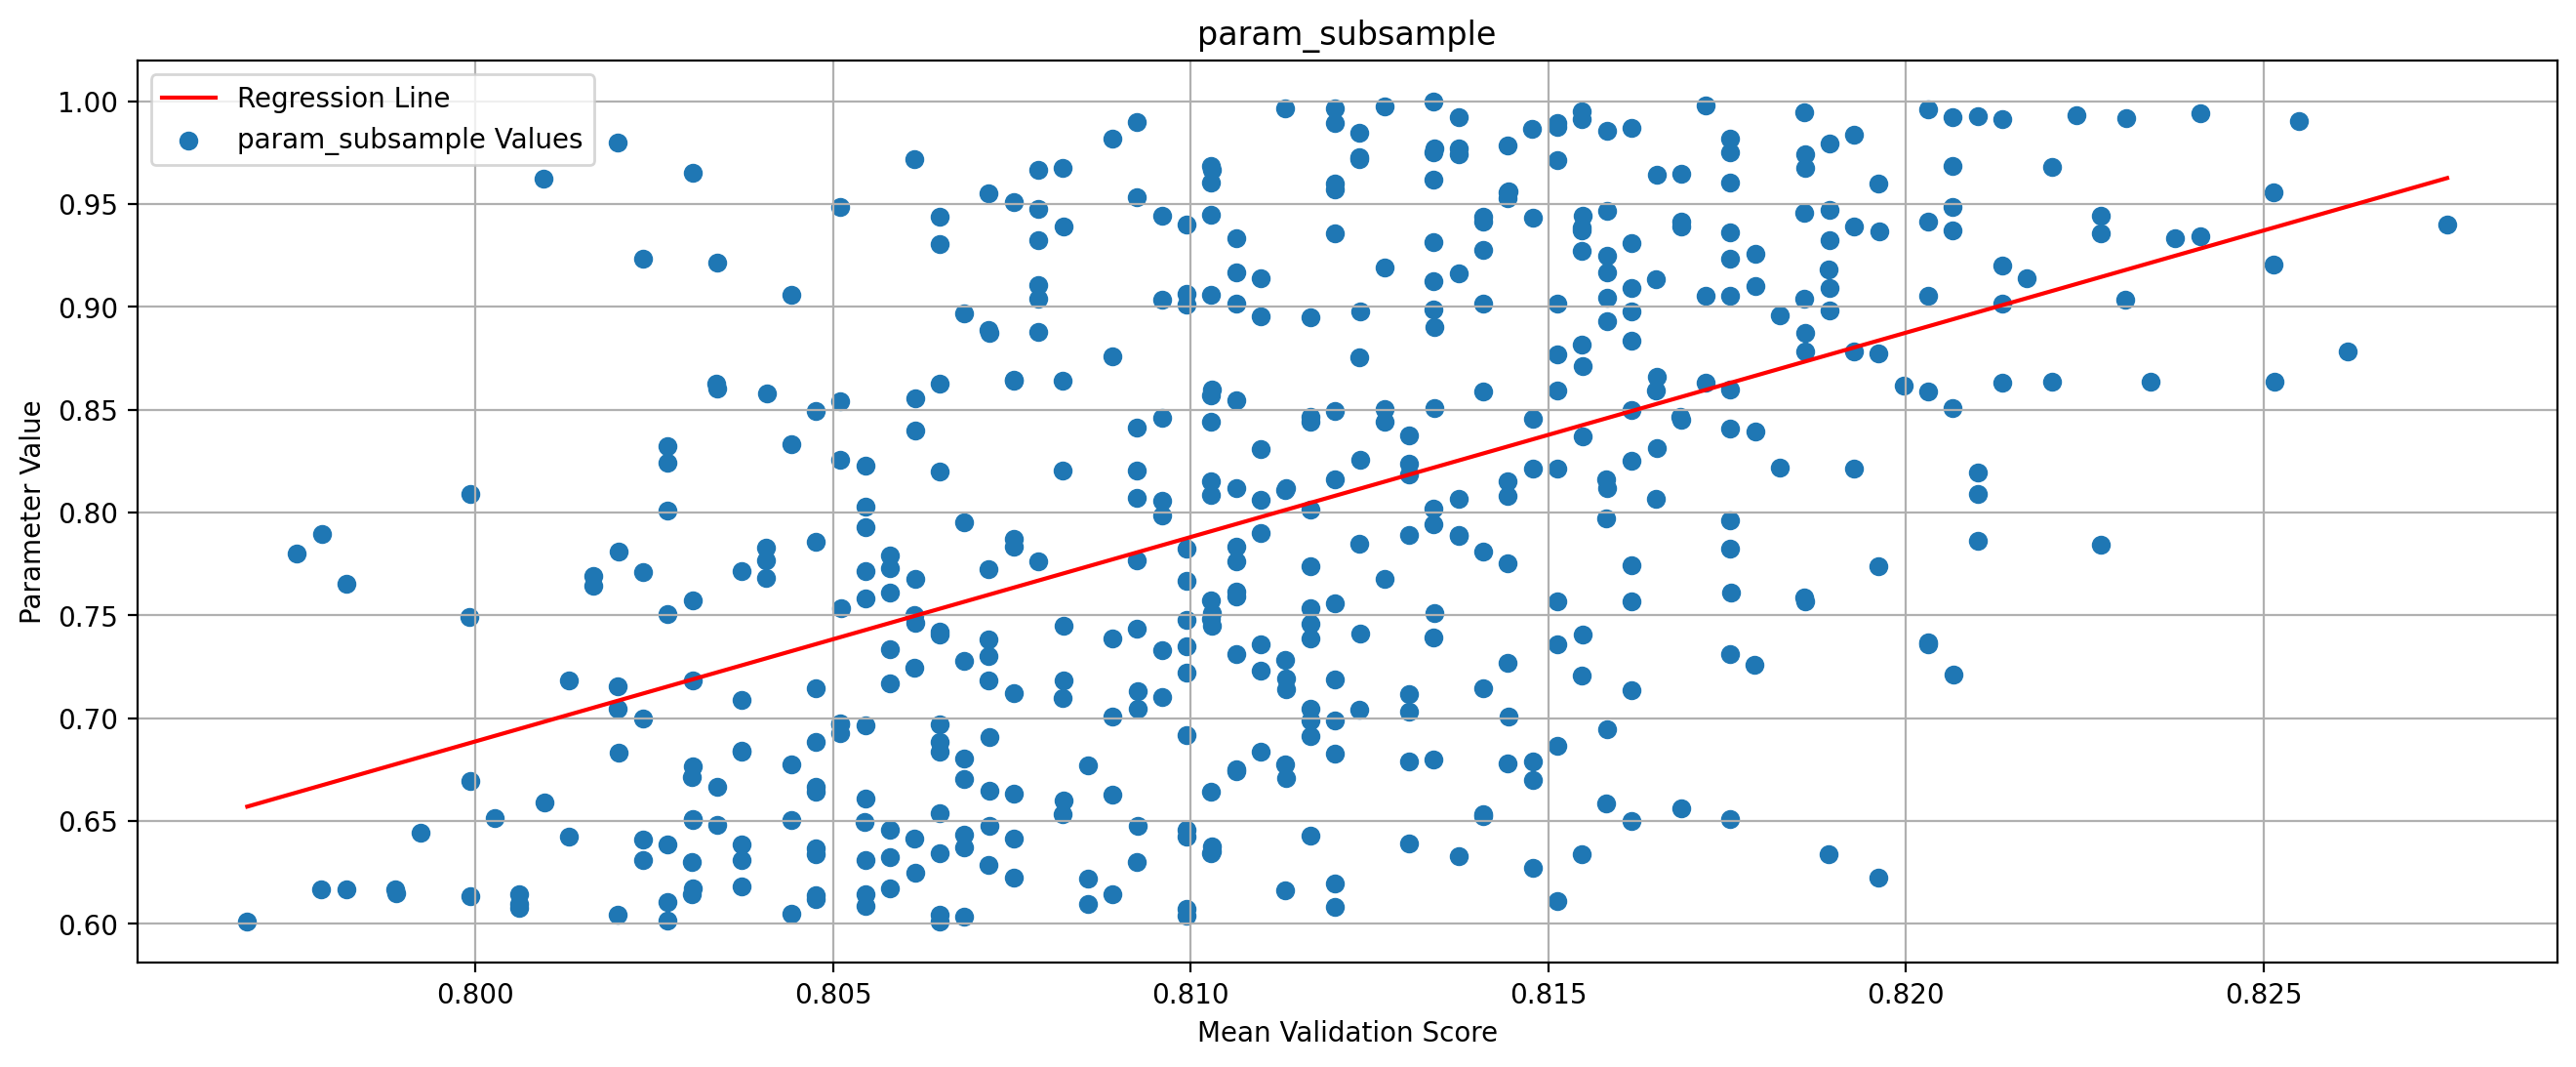

In [31]:
# TEST
for col in ['param_colsample_bylevel', 'param_colsample_bynode',
       'param_colsample_bytree', 'param_gamma', 'param_learning_rate',
       'param_max_depth', 'param_n_estimators', 'param_reg_alpha',
       'param_reg_lambda', 'param_subsample']:
    
    plt.figure(figsize=(16, 6))    

    m, b = np.polyfit(list(sorted_cv['mean_test_score'].values), list(sorted_cv[col].values), 1)
    plt.plot(sorted_cv['mean_test_score'], m * sorted_cv['mean_test_score'] + b, c='r', label="Regression Line")
    plt.scatter(sorted_cv['mean_test_score'], sorted_cv[col], label=f"{col} Values")
    
    plt.grid()
    plt.xlabel('Mean Validation Score')
    plt.ylabel('Parameter Value')
    plt.title(col)
    plt.legend(loc='best')

    
    filename = f"{col}_by_rank.png"
    plt.savefig(os.path.join(results_path, filename))
                  
    plt.show()


# Hyperparameter Evaluation

In [32]:

def plot_parameters(x_values, title):
    
    fig, ax1 = plt.subplots(figsize=(16, 6))
    ax2 = ax1.twinx()

    ax1.scatter(x_values, cv_results['mean_test_score'], label='mean_test_score', c='b')
    #ax2.scatter(x_values, cv_results['std_test_score'], label='std_test_score', c='r')

    m, b = np.polyfit(list(x_values.values), list(cv_results['mean_test_score'].values), 1)
    ax1.plot(x_values, m * x_values + b, c='b')

    m, b = np.polyfit(list(x_values.values), list(cv_results['std_test_score'].values), 1)
    ax2.plot(x_values, m * x_values + b, c='r', label='std_test_score')
    
    ax1.set_title(title)
    ax1.set_xlabel('Parameter Value')
    ax1.set_ylabel('Mean Test Score')
    ax2.set_ylabel('Standard Deviation of Test Score')
    ax1.grid(True)
    
    
    # Combine the legends from both axes
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper right')

    filename = f"{title}_test_score.png"
    plt.savefig(os.path.join(results_path, filename))
            
    plt.show()



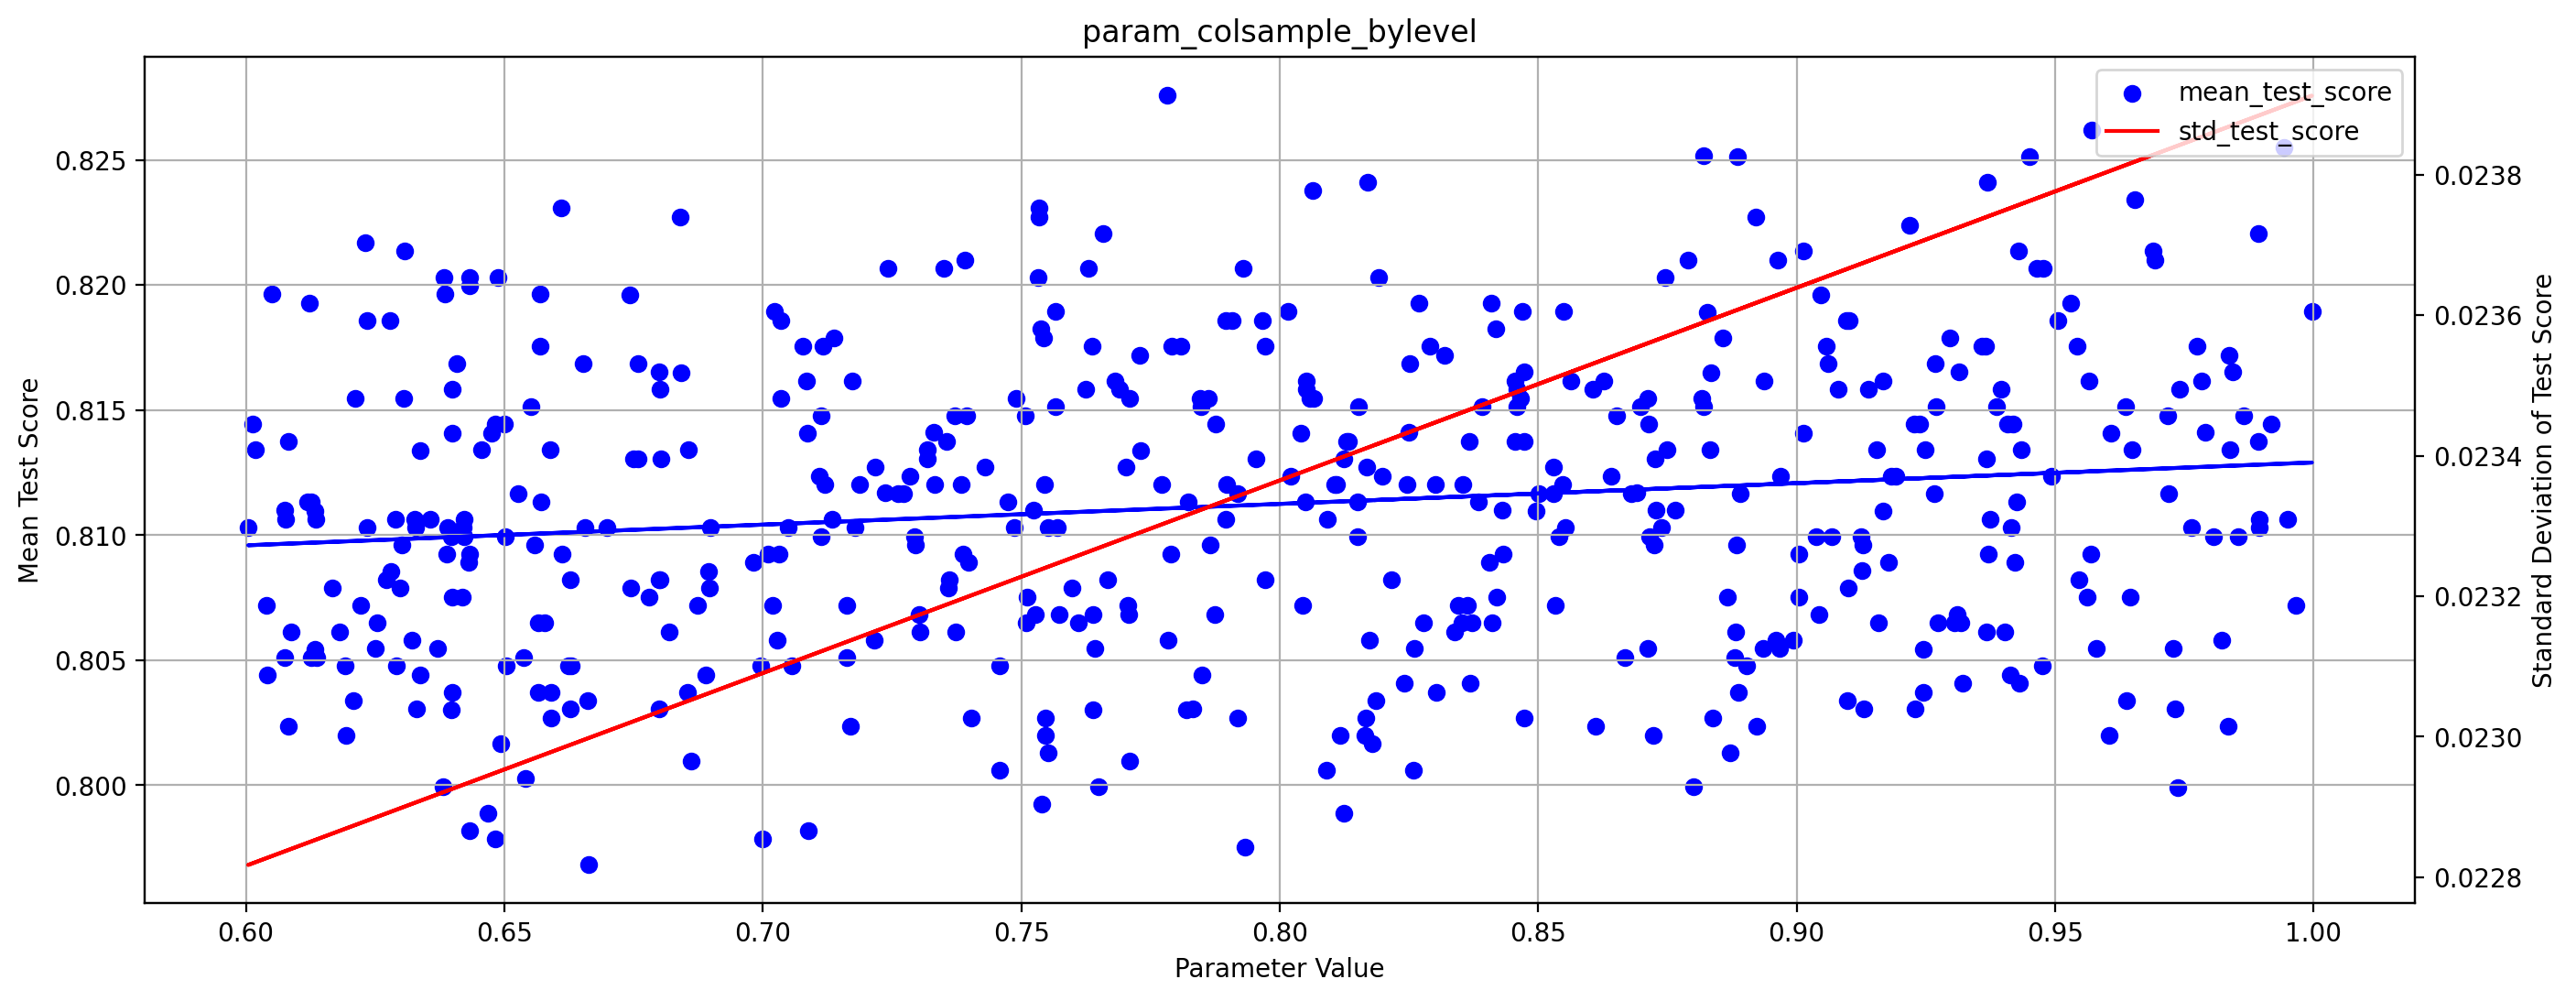

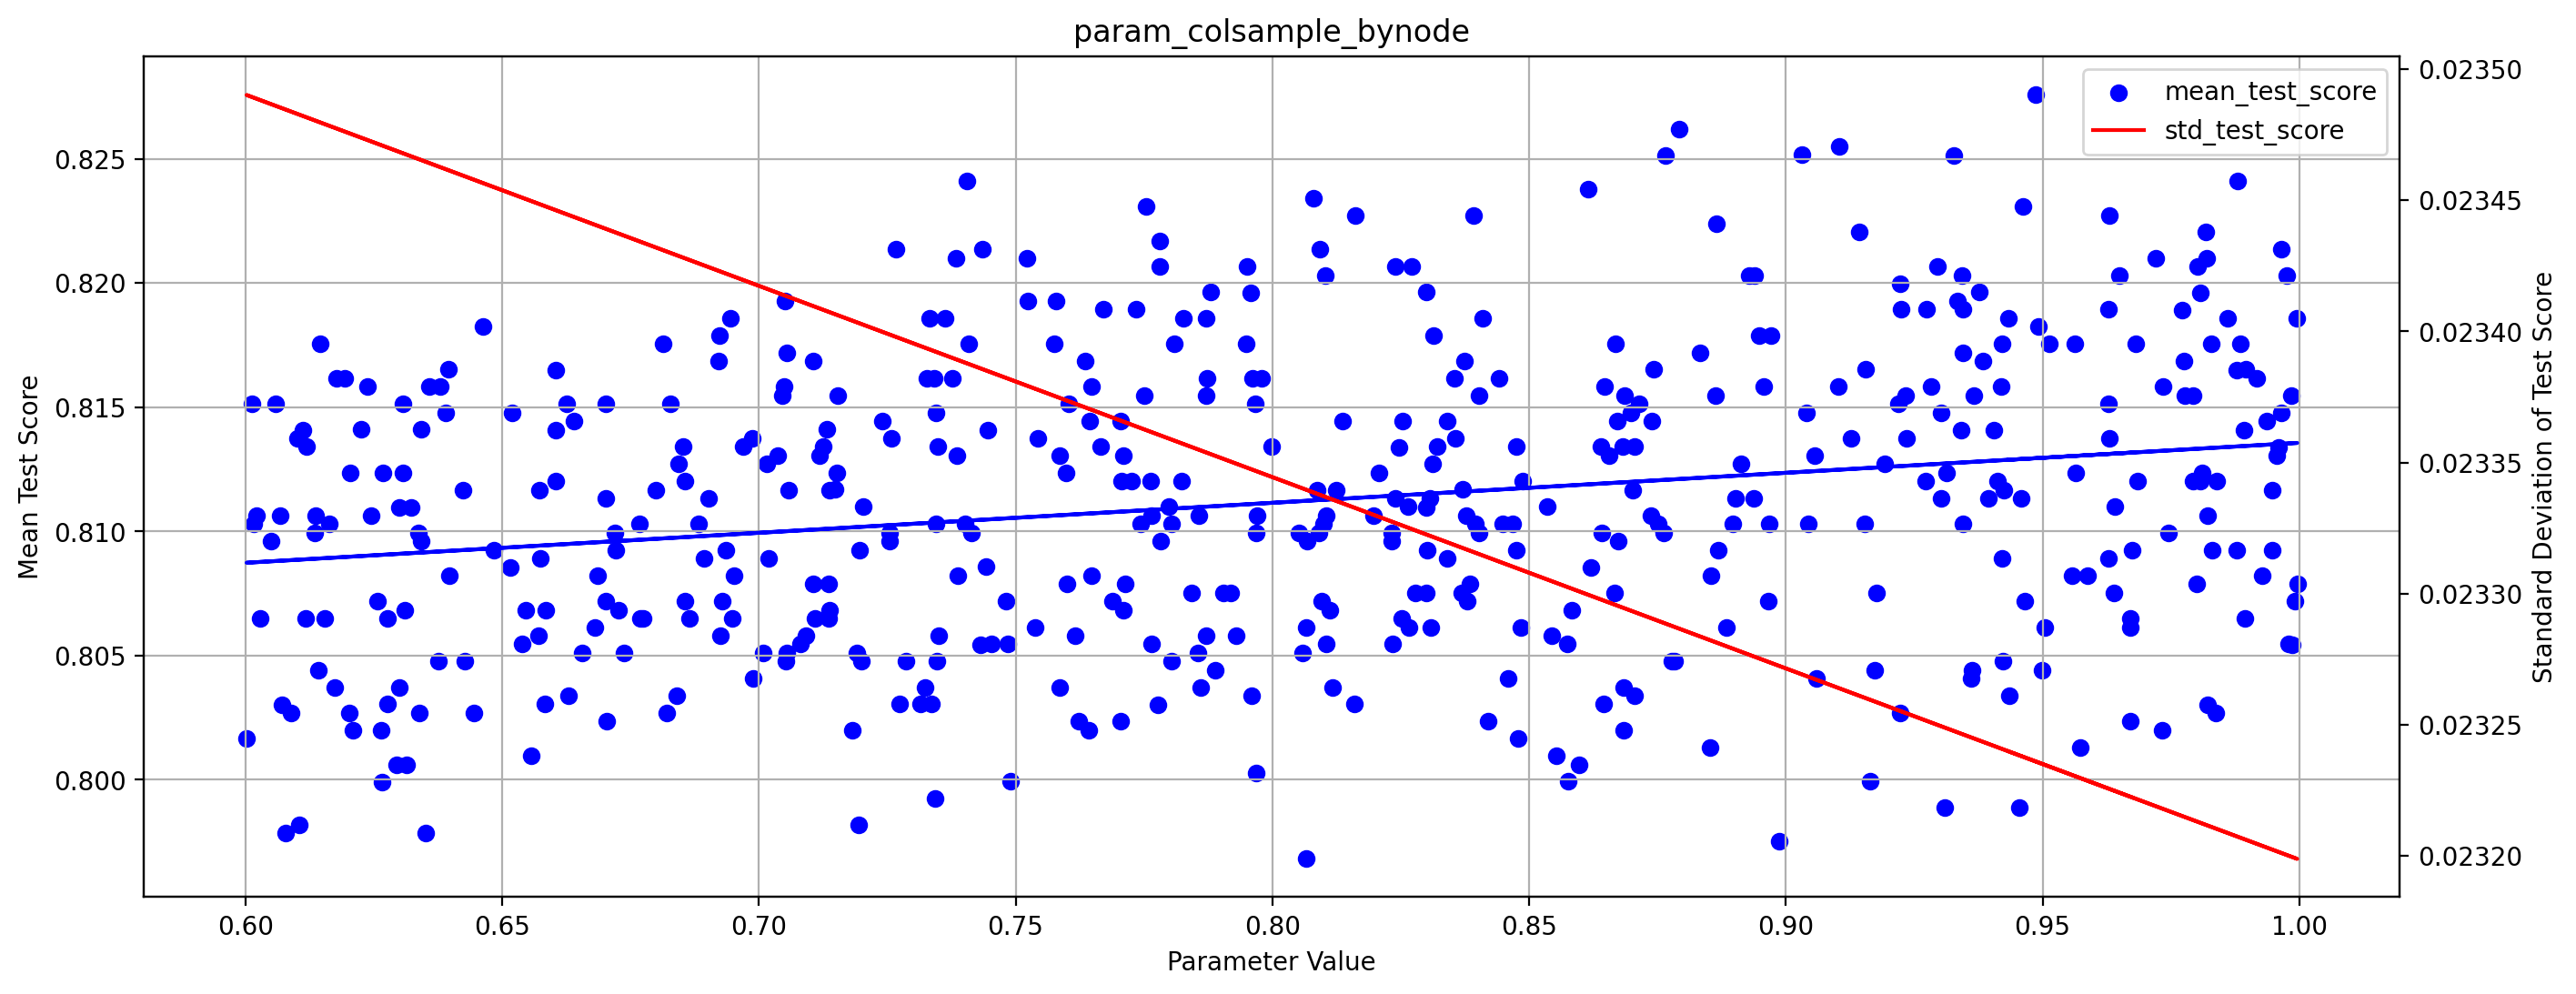

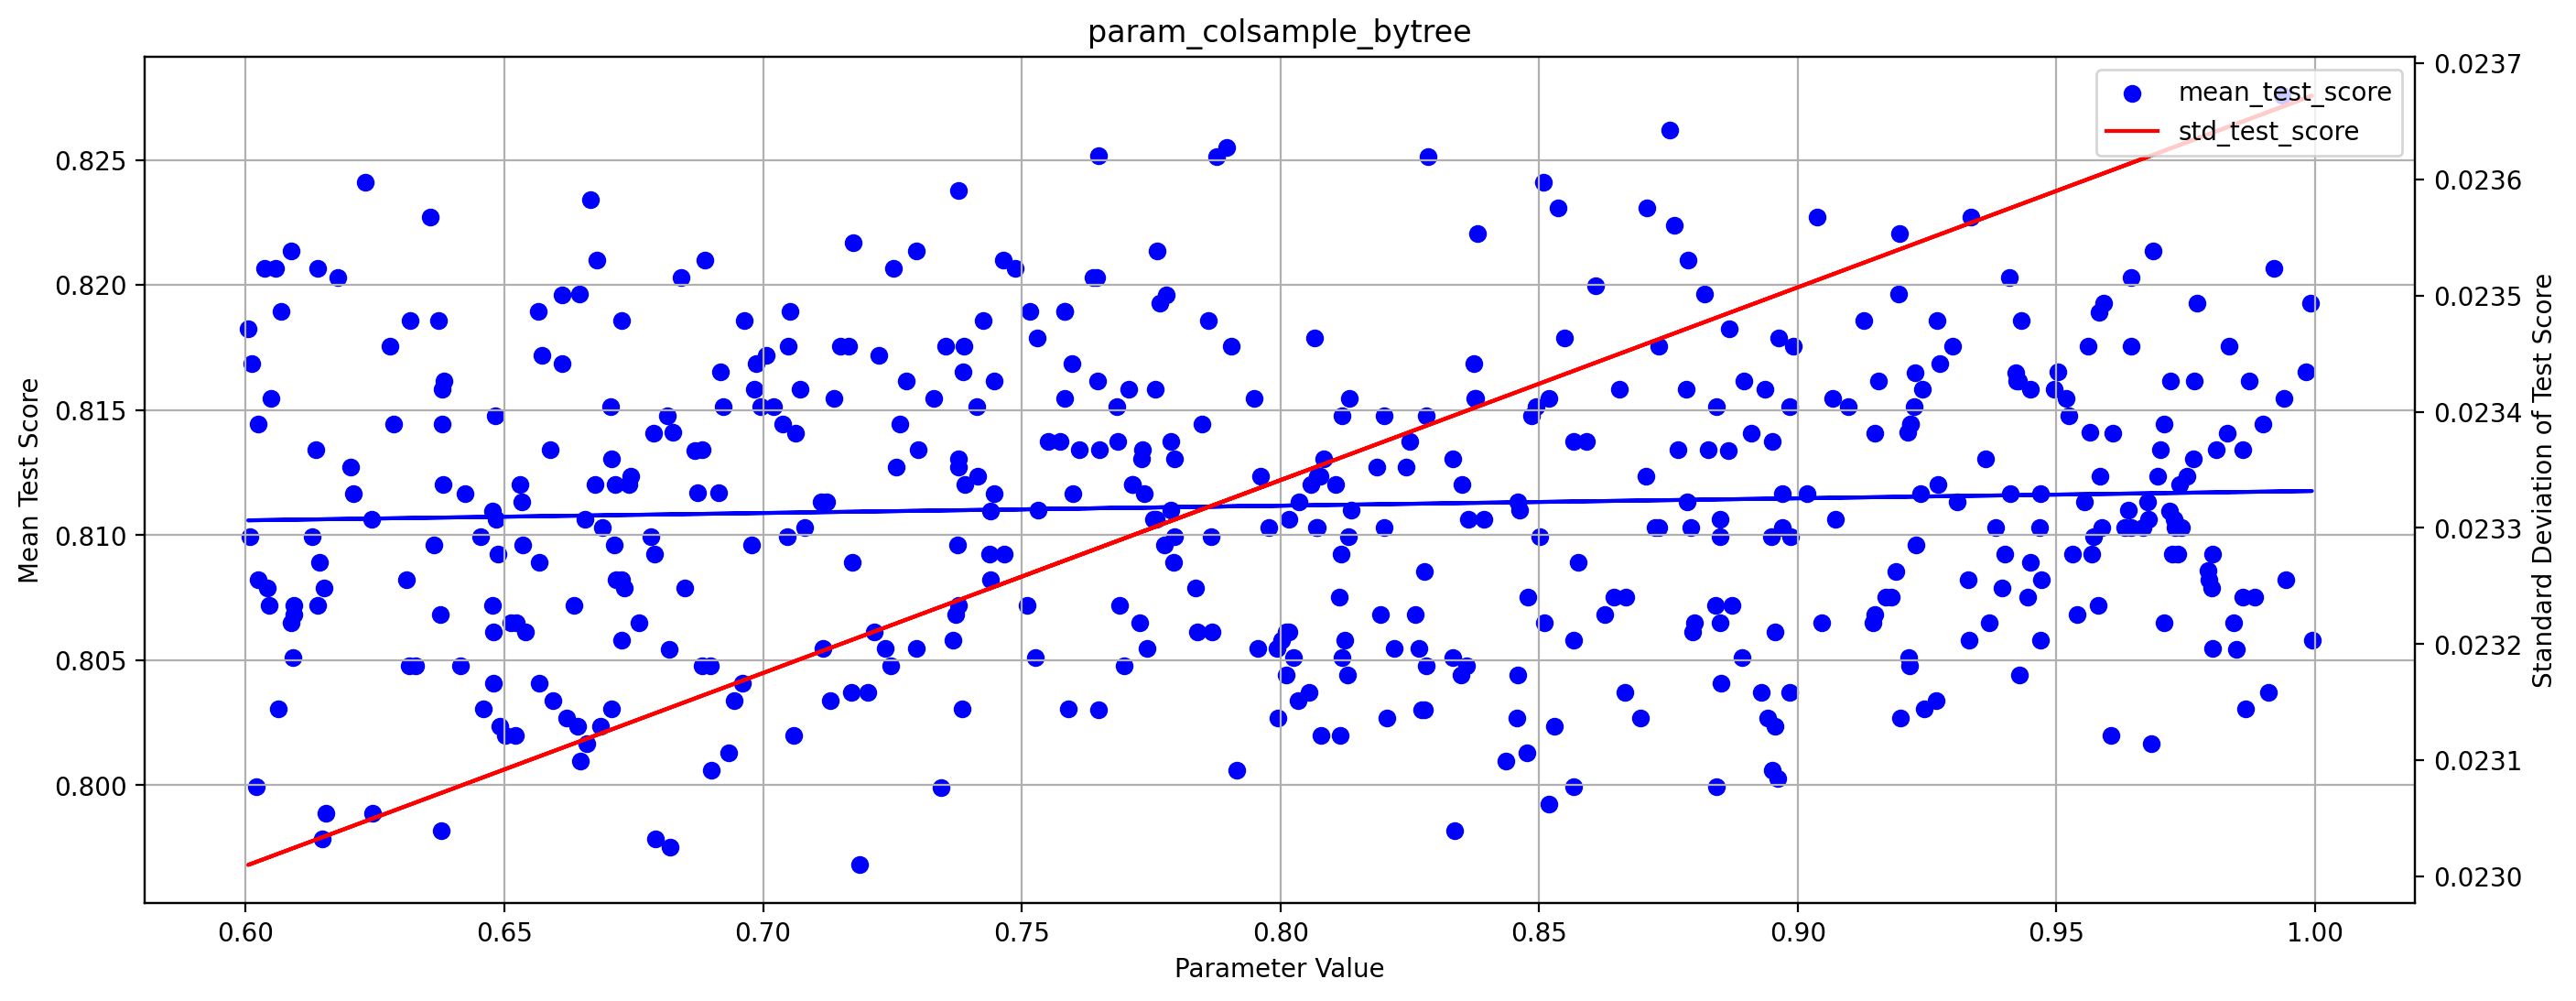

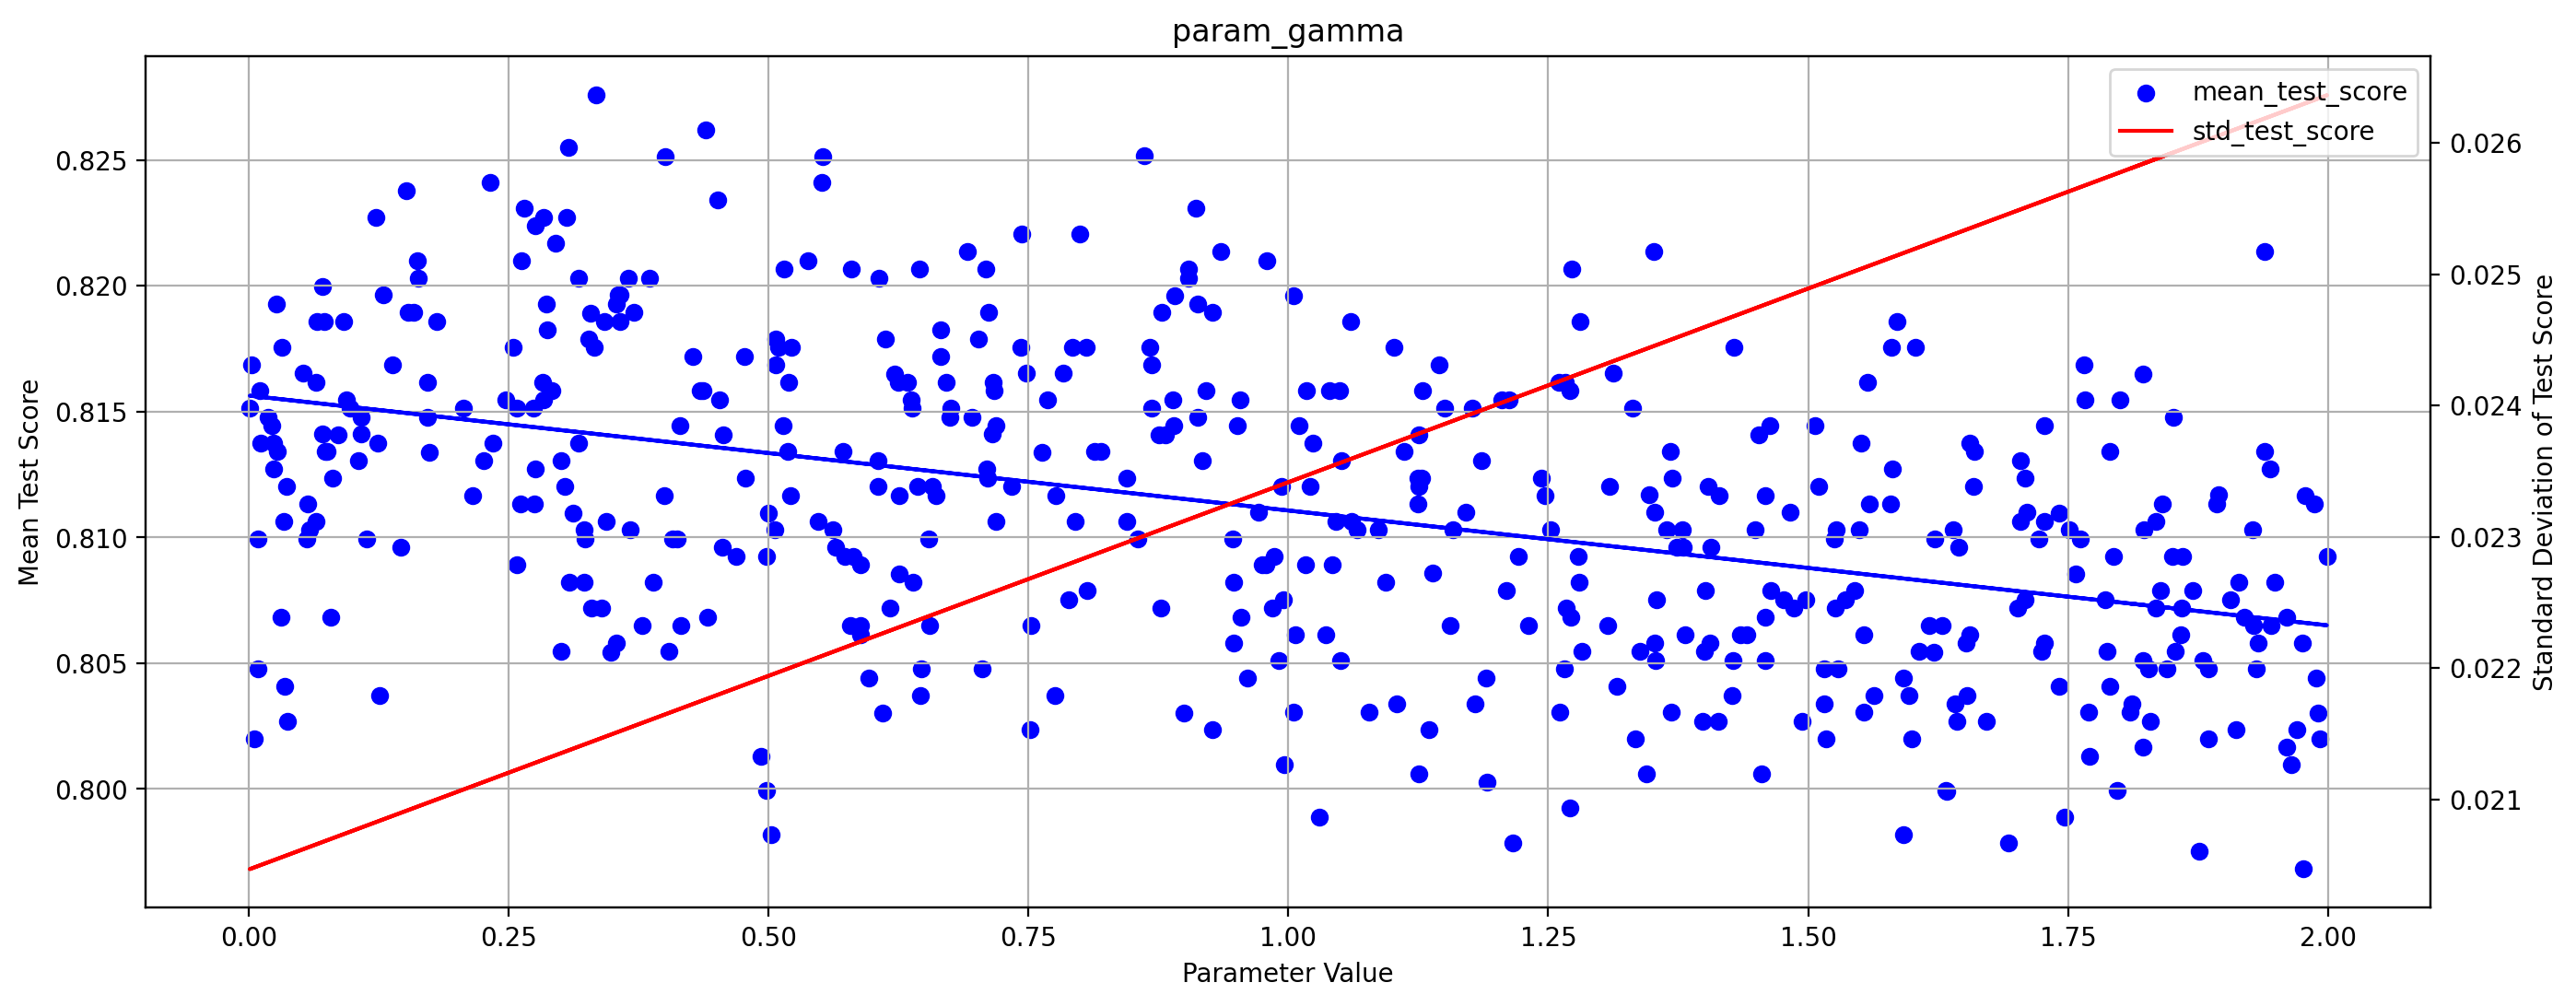

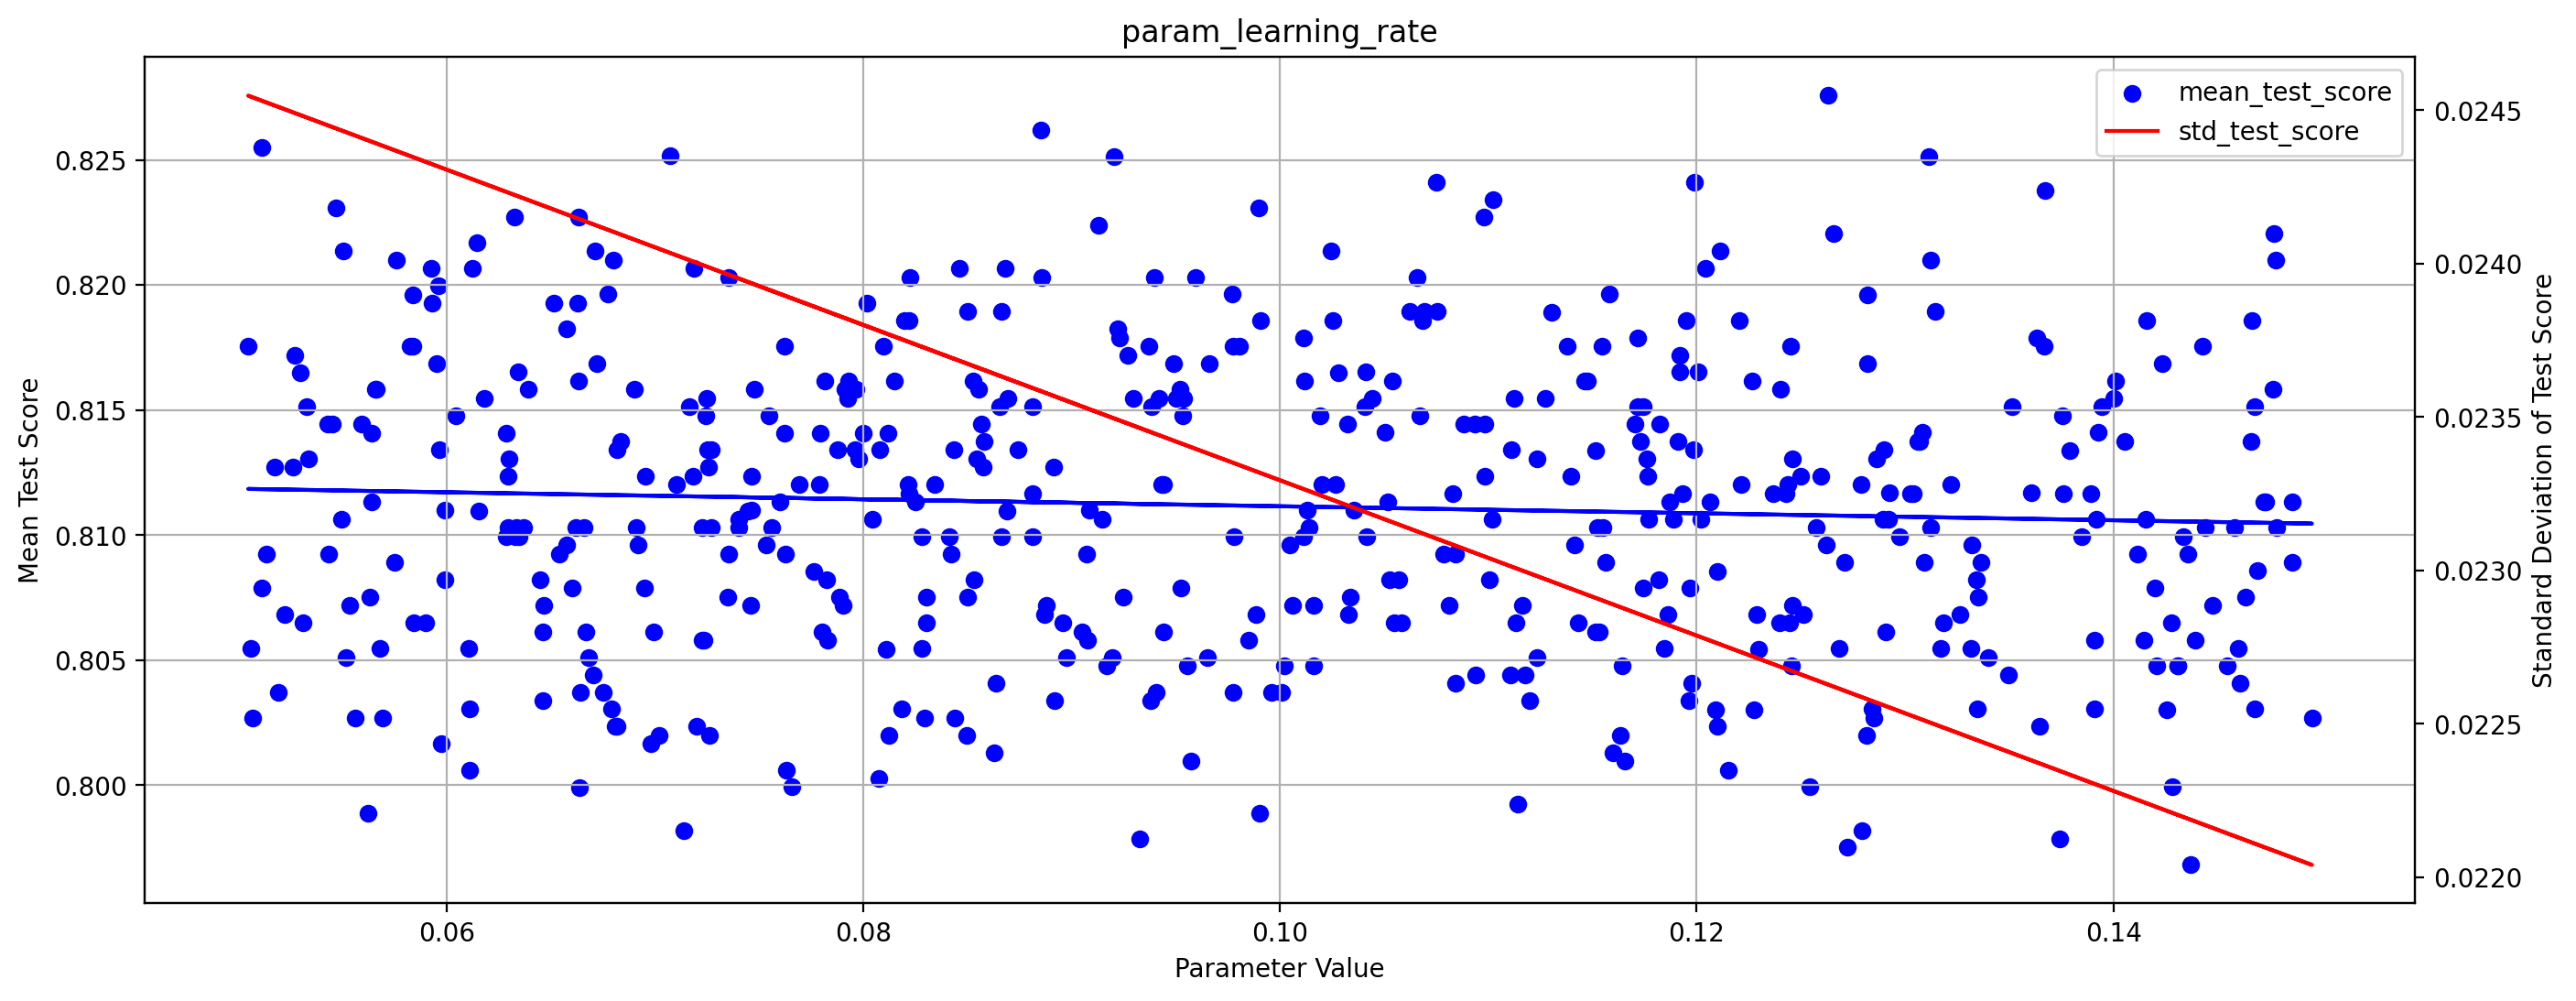

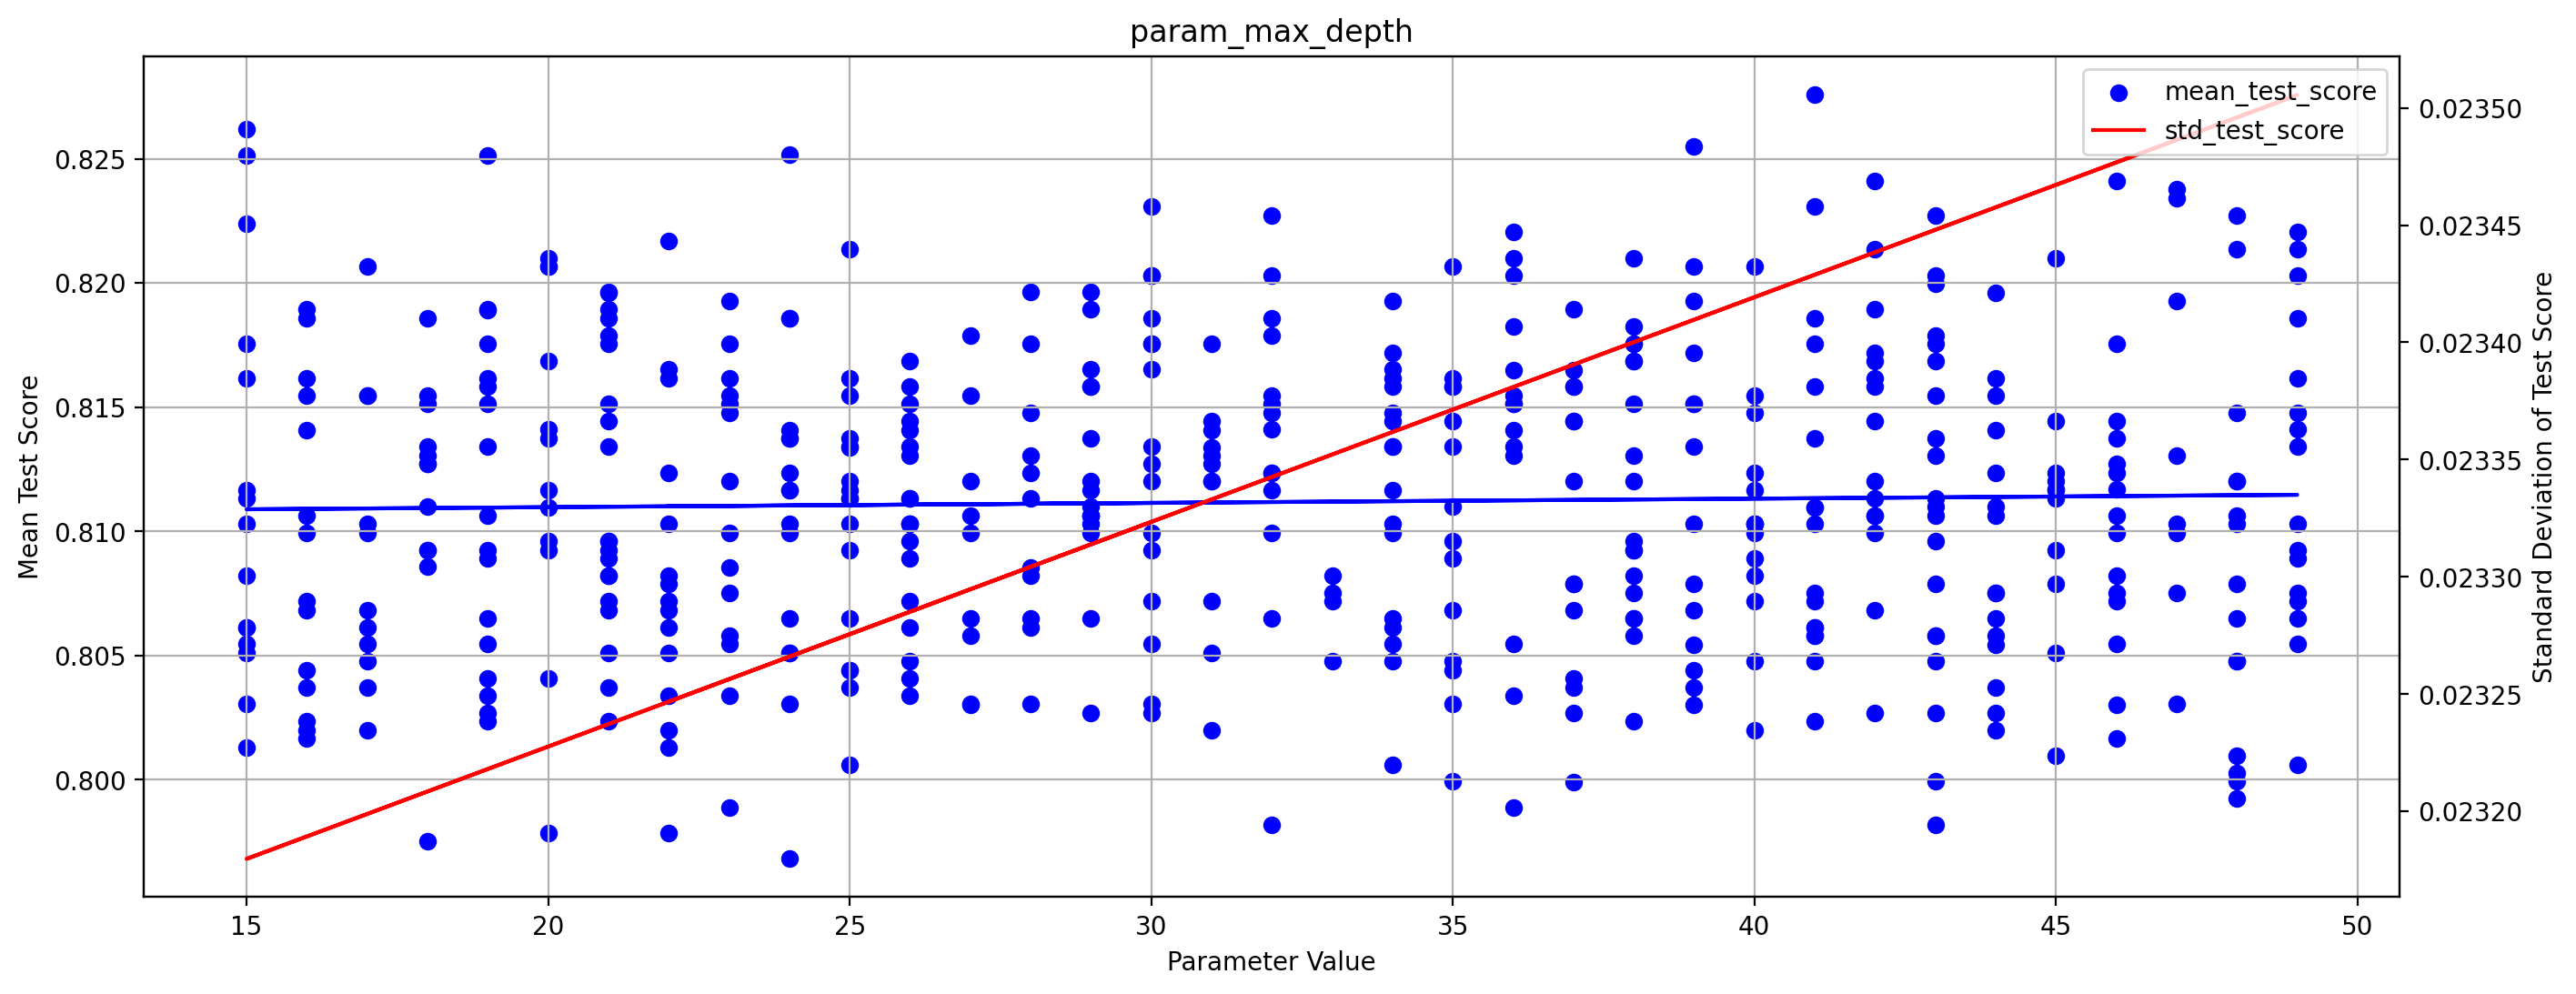

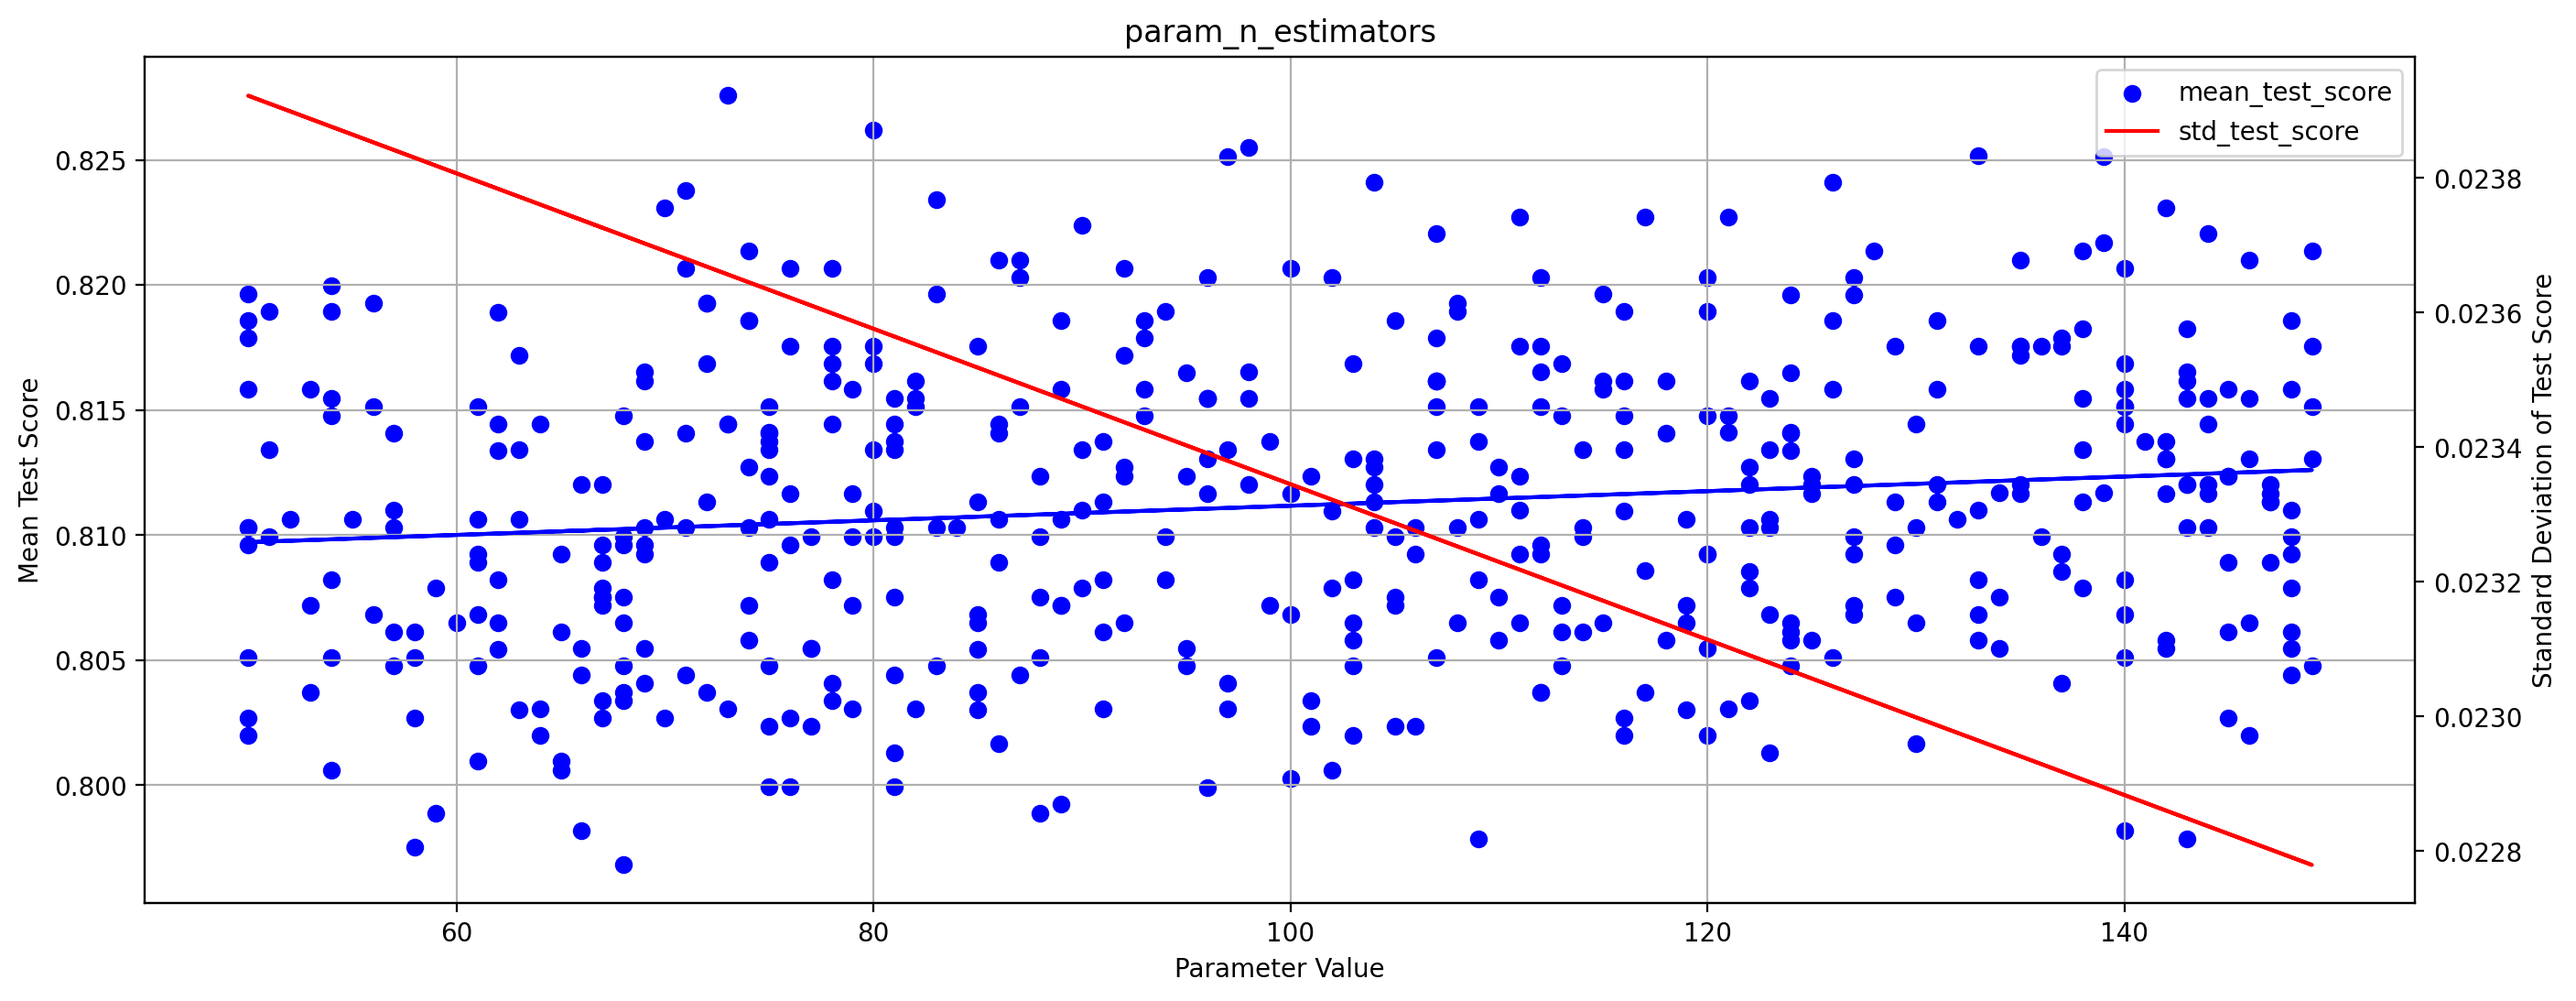

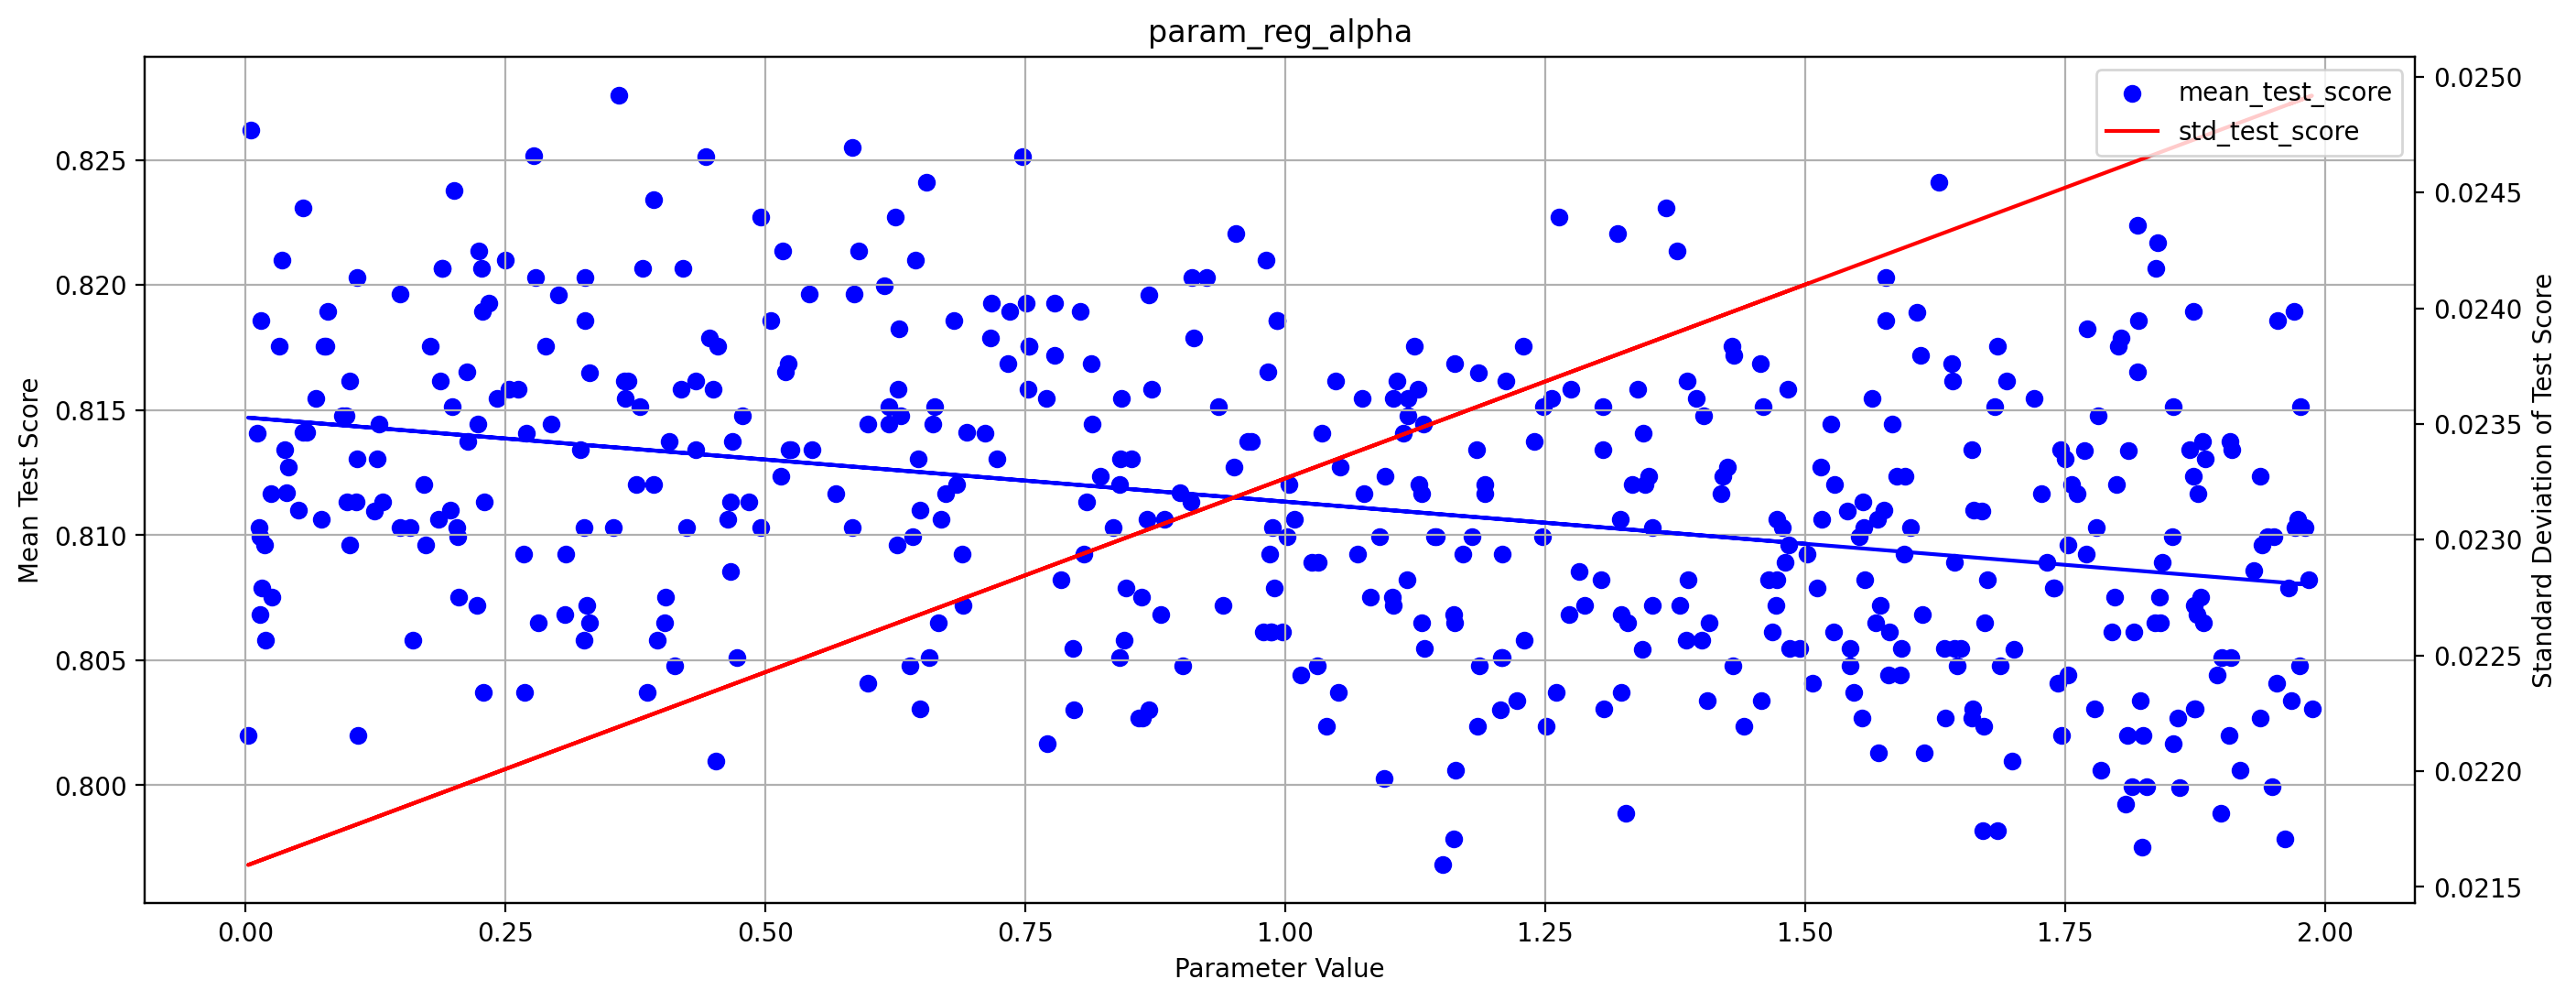

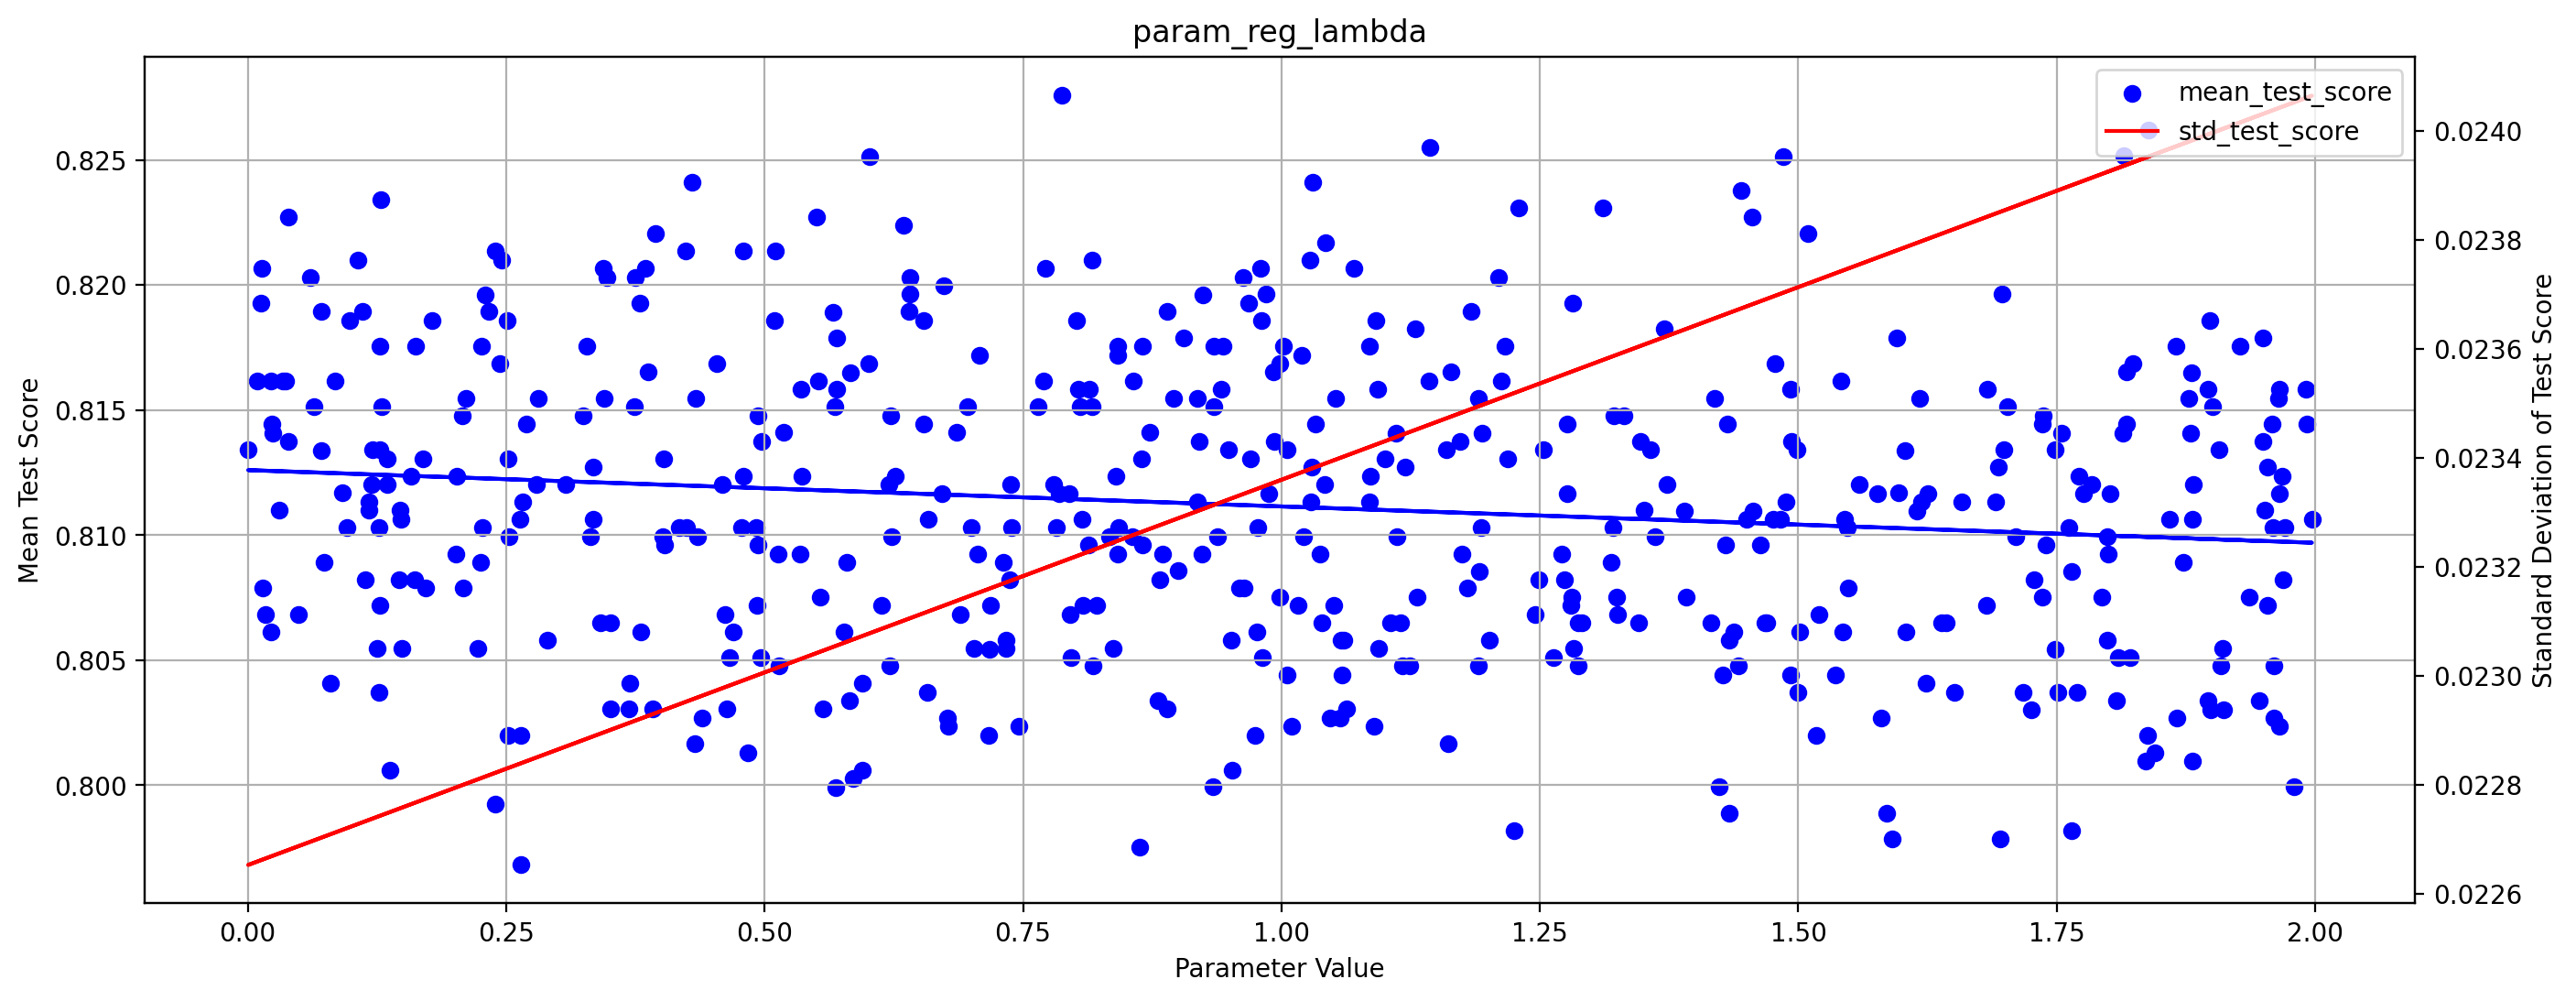

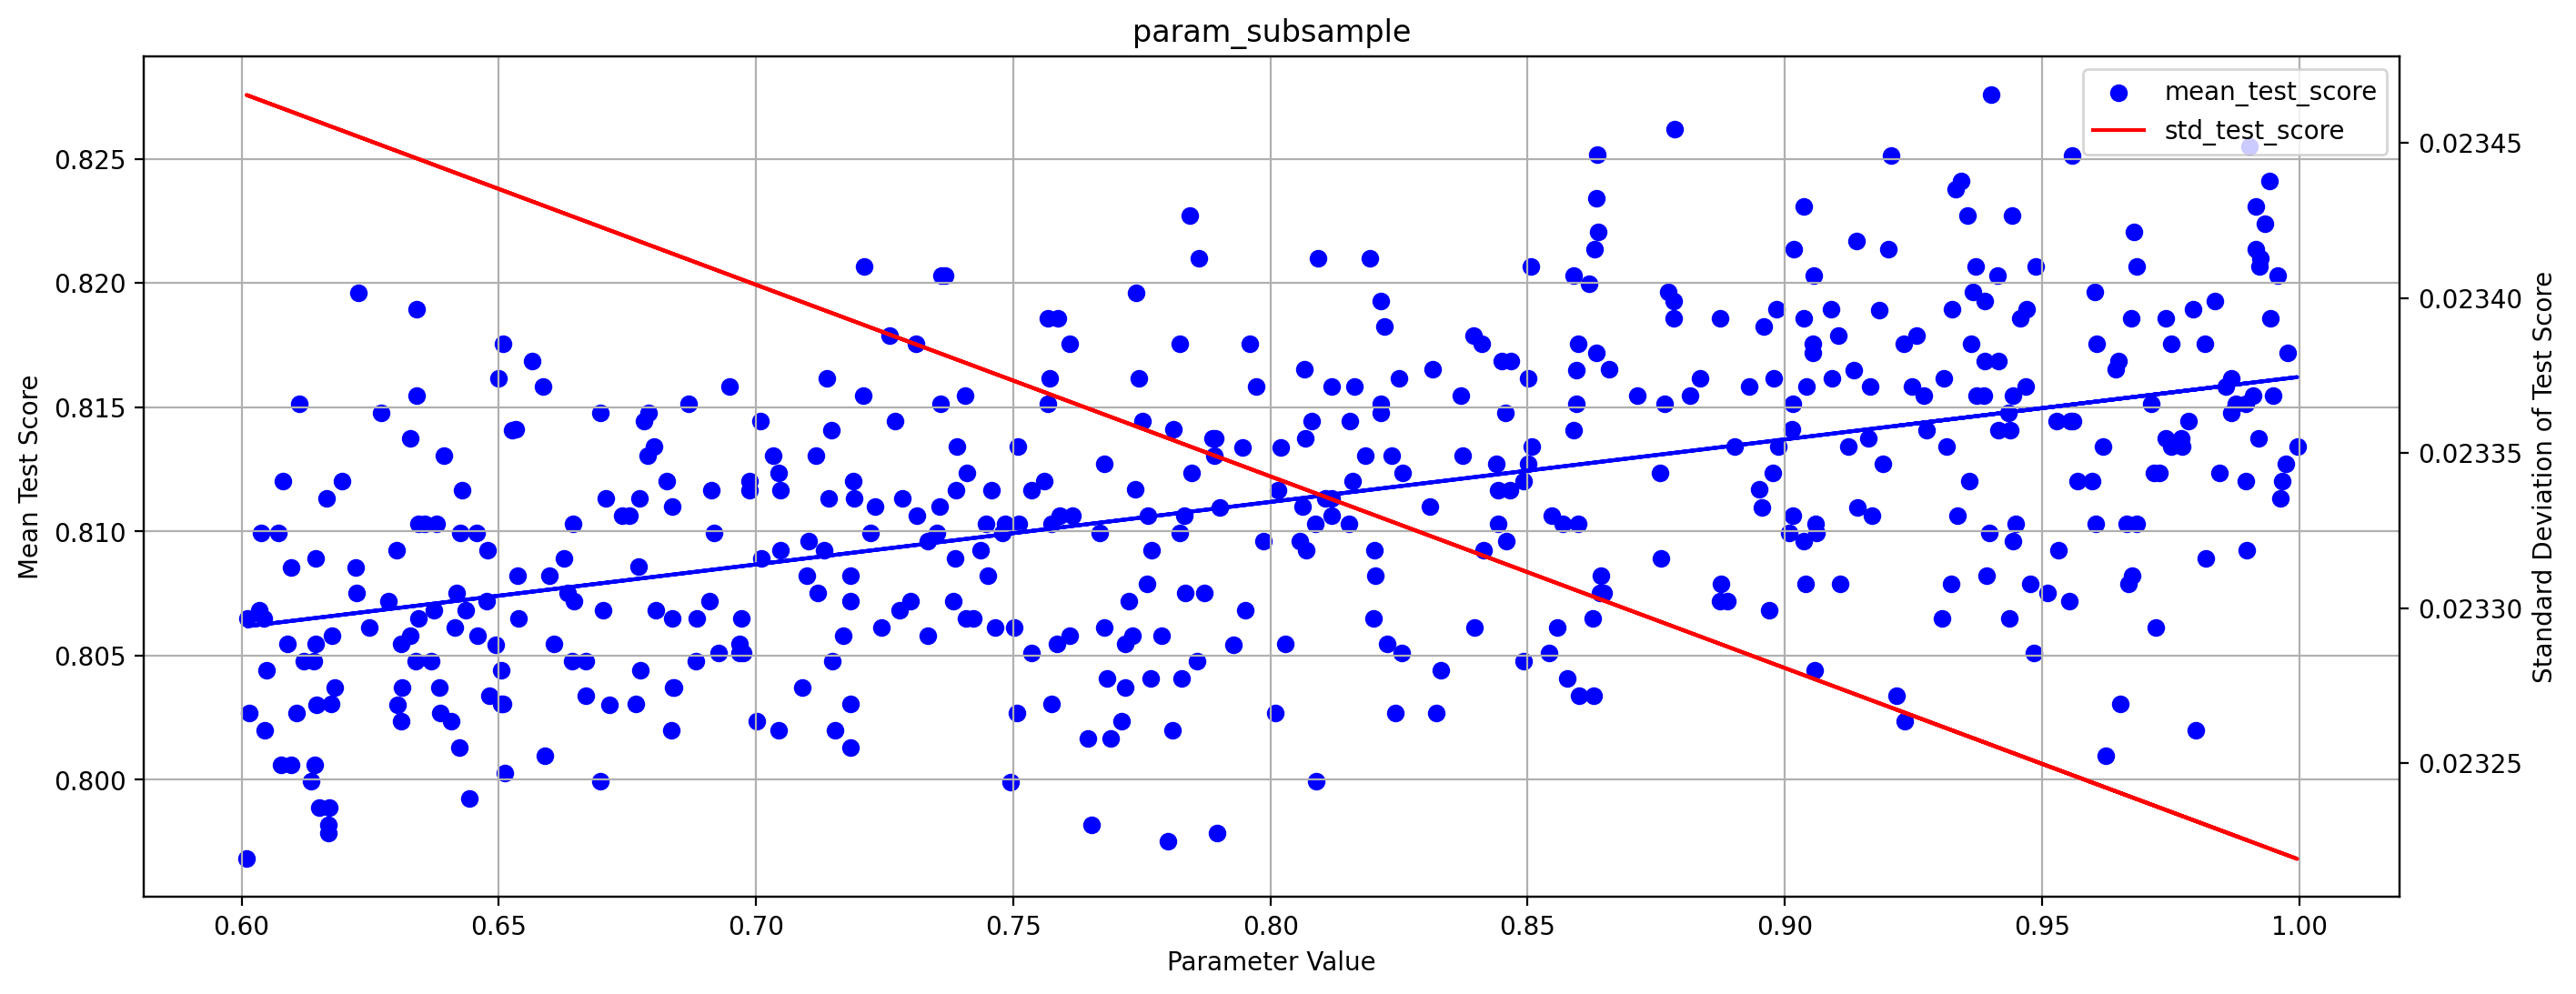

In [33]:
for param in ['param_colsample_bylevel', 'param_colsample_bynode', 'param_colsample_bytree',
                     'param_gamma', 'param_learning_rate', 'param_max_depth', 'param_n_estimators', 
                     'param_reg_alpha', 'param_reg_lambda', 'param_subsample']:
    x_values = cv_results[param]
    plot_parameters(x_values, param)

# Plotting Evaluation Metrics (Precision, Recall, F1-Score, AUC-ROC):


In [38]:
classes

2

[CV 3/5; 459/500] START colsample_bylevel=0.6999231814310102, colsample_bynode=0.6352022695909644, colsample_bytree=0.6791876679829254, gamma=1.6927271522149705, learning_rate=0.09325399295833564, max_depth=20, n_estimators=109, reg_alpha=1.1620038079726271, reg_lambda=1.6954794183227195, subsample=0.6167887897088254
[CV 3/5; 459/500] END colsample_bylevel=0.6999231814310102, colsample_bynode=0.6352022695909644, colsample_bytree=0.6791876679829254, gamma=1.6927271522149705, learning_rate=0.09325399295833564, max_depth=20, n_estimators=109, reg_alpha=1.1620038079726271, reg_lambda=1.6954794183227195, subsample=0.6167887897088254;, score=(train=0.894, test=0.848) total time=   0.3s
[CV 1/5; 461/500] START colsample_bylevel=0.8105418781276195, colsample_bynode=0.9806551770428538, colsample_bytree=0.8351722427556156, gamma=1.0211988274988872, learning_rate=0.08344137921754644, max_depth=30, n_estimators=98, reg_alpha=1.3458217434784867, reg_lambda=1.372897155532619, subsample=0.81604392387

[CV 5/5; 445/500] END colsample_bylevel=0.6652739041461215, colsample_bynode=0.938384181742605, colsample_bytree=0.6611778993724425, gamma=0.0026476185772374983, learning_rate=0.12818601055767645, max_depth=26, n_estimators=113, reg_alpha=1.4571788133644181, reg_lambda=1.8238854704711855, subsample=0.9648576202185063;, score=(train=1.000, test=0.811) total time=   0.9s
[CV 1/5; 448/500] START colsample_bylevel=0.7489547640001166, colsample_bynode=0.7870323212284538, colsample_bytree=0.713706620511151, gamma=1.2053948124472436, learning_rate=0.1400130072152479, max_depth=17, n_estimators=146, reg_alpha=0.36498686133887204, reg_lambda=0.2810693496569705, subsample=0.7208718554395626
[CV 1/5; 448/500] END colsample_bylevel=0.7489547640001166, colsample_bynode=0.7870323212284538, colsample_bytree=0.713706620511151, gamma=1.2053948124472436, learning_rate=0.1400130072152479, max_depth=17, n_estimators=146, reg_alpha=0.36498686133887204, reg_lambda=0.2810693496569705, subsample=0.72087185543

[CV 2/5; 478/500] START colsample_bylevel=0.8301873525106112, colsample_bynode=0.7725226765251092, colsample_bytree=0.7390722047231364, gamma=0.6432580679983906, learning_rate=0.08215020740527088, max_depth=29, n_estimators=67, reg_alpha=1.5280995525298777, reg_lambda=0.620428291796451, subsample=0.849292694667708
[CV 2/5; 478/500] END colsample_bylevel=0.8301873525106112, colsample_bynode=0.7725226765251092, colsample_bytree=0.7390722047231364, gamma=0.6432580679983906, learning_rate=0.08215020740527088, max_depth=29, n_estimators=67, reg_alpha=1.5280995525298777, reg_lambda=0.620428291796451, subsample=0.849292694667708;, score=(train=0.966, test=0.796) total time=   0.5s
[CV 5/5; 479/500] START colsample_bylevel=0.8454731294366665, colsample_bynode=0.6193642049719753, colsample_bytree=0.8895581784121916, gamma=1.2599870321935225, learning_rate=0.10117068130771156, max_depth=49, n_estimators=107, reg_alpha=1.6939755650489026, reg_lambda=0.009493127071122043, subsample=0.9309024063642

[CV 3/5; 451/500] START colsample_bylevel=0.6482029845047705, colsample_bynode=0.8670883875300333, colsample_bytree=0.6024130936697402, gamma=0.41453461996736496, learning_rate=0.11820474602955744, max_depth=34, n_estimators=81, reg_alpha=1.5241883154221958, reg_lambda=0.2696678811687103, subsample=0.815358474137932
[CV 3/5; 451/500] END colsample_bylevel=0.6482029845047705, colsample_bynode=0.8670883875300333, colsample_bytree=0.6024130936697402, gamma=0.41453461996736496, learning_rate=0.11820474602955744, max_depth=34, n_estimators=81, reg_alpha=1.5241883154221958, reg_lambda=0.2696678811687103, subsample=0.815358474137932;, score=(train=0.983, test=0.855) total time=   0.4s
[CV 4/5; 452/500] START colsample_bylevel=0.6537342442616987, colsample_bynode=0.7191371260275549, colsample_bytree=0.8893078549187292, gamma=1.4276041119425908, learning_rate=0.1340007424213734, max_depth=45, n_estimators=54, reg_alpha=0.6578222857115037, reg_lambda=0.7966941224248518, subsample=0.8254630727992

[CV 1/5; 477/500] START colsample_bylevel=0.72937567289728, colsample_bynode=0.6720489224700287, colsample_bytree=0.8948468838429458, gamma=1.7222360870922213, learning_rate=0.14333729092924802, max_depth=47, n_estimators=114, reg_alpha=1.1430725230612633, reg_lambda=0.43525807525229476, subsample=0.93981260932499
[CV 1/5; 477/500] END colsample_bylevel=0.72937567289728, colsample_bynode=0.6720489224700287, colsample_bytree=0.8948468838429458, gamma=1.7222360870922213, learning_rate=0.14333729092924802, max_depth=47, n_estimators=114, reg_alpha=1.1430725230612633, reg_lambda=0.43525807525229476, subsample=0.93981260932499;, score=(train=0.935, test=0.808) total time=   0.3s
[CV 1/5; 478/500] START colsample_bylevel=0.8301873525106112, colsample_bynode=0.7725226765251092, colsample_bytree=0.7390722047231364, gamma=0.6432580679983906, learning_rate=0.08215020740527088, max_depth=29, n_estimators=67, reg_alpha=1.5280995525298777, reg_lambda=0.620428291796451, subsample=0.849292694667708
[

[CV 3/5; 481/500] START colsample_bylevel=0.740350582094701, colsample_bynode=0.922250884499688, colsample_bytree=0.7996011799365386, gamma=1.6714137032664125, learning_rate=0.12850018567118893, max_depth=43, n_estimators=70, reg_alpha=1.6344622318174016, reg_lambda=1.8657972408029302, subsample=0.8010165744258521
[CV 3/5; 481/500] END colsample_bylevel=0.740350582094701, colsample_bynode=0.922250884499688, colsample_bytree=0.7996011799365386, gamma=1.6714137032664125, learning_rate=0.12850018567118893, max_depth=43, n_estimators=70, reg_alpha=1.6344622318174016, reg_lambda=1.8657972408029302, subsample=0.8010165744258521;, score=(train=0.902, test=0.851) total time=   0.3s
[CV 3/5; 483/500] START colsample_bylevel=0.881929713235557, colsample_bynode=0.9030585568984733, colsample_bytree=0.7648580830144018, gamma=0.8611024322913592, learning_rate=0.0707216187804391, max_depth=24, n_estimators=133, reg_alpha=0.276860827902768, reg_lambda=1.814439088144392, subsample=0.8635751888743046
[C

IndexError: index 1 is out of bounds for axis 1 with size 1

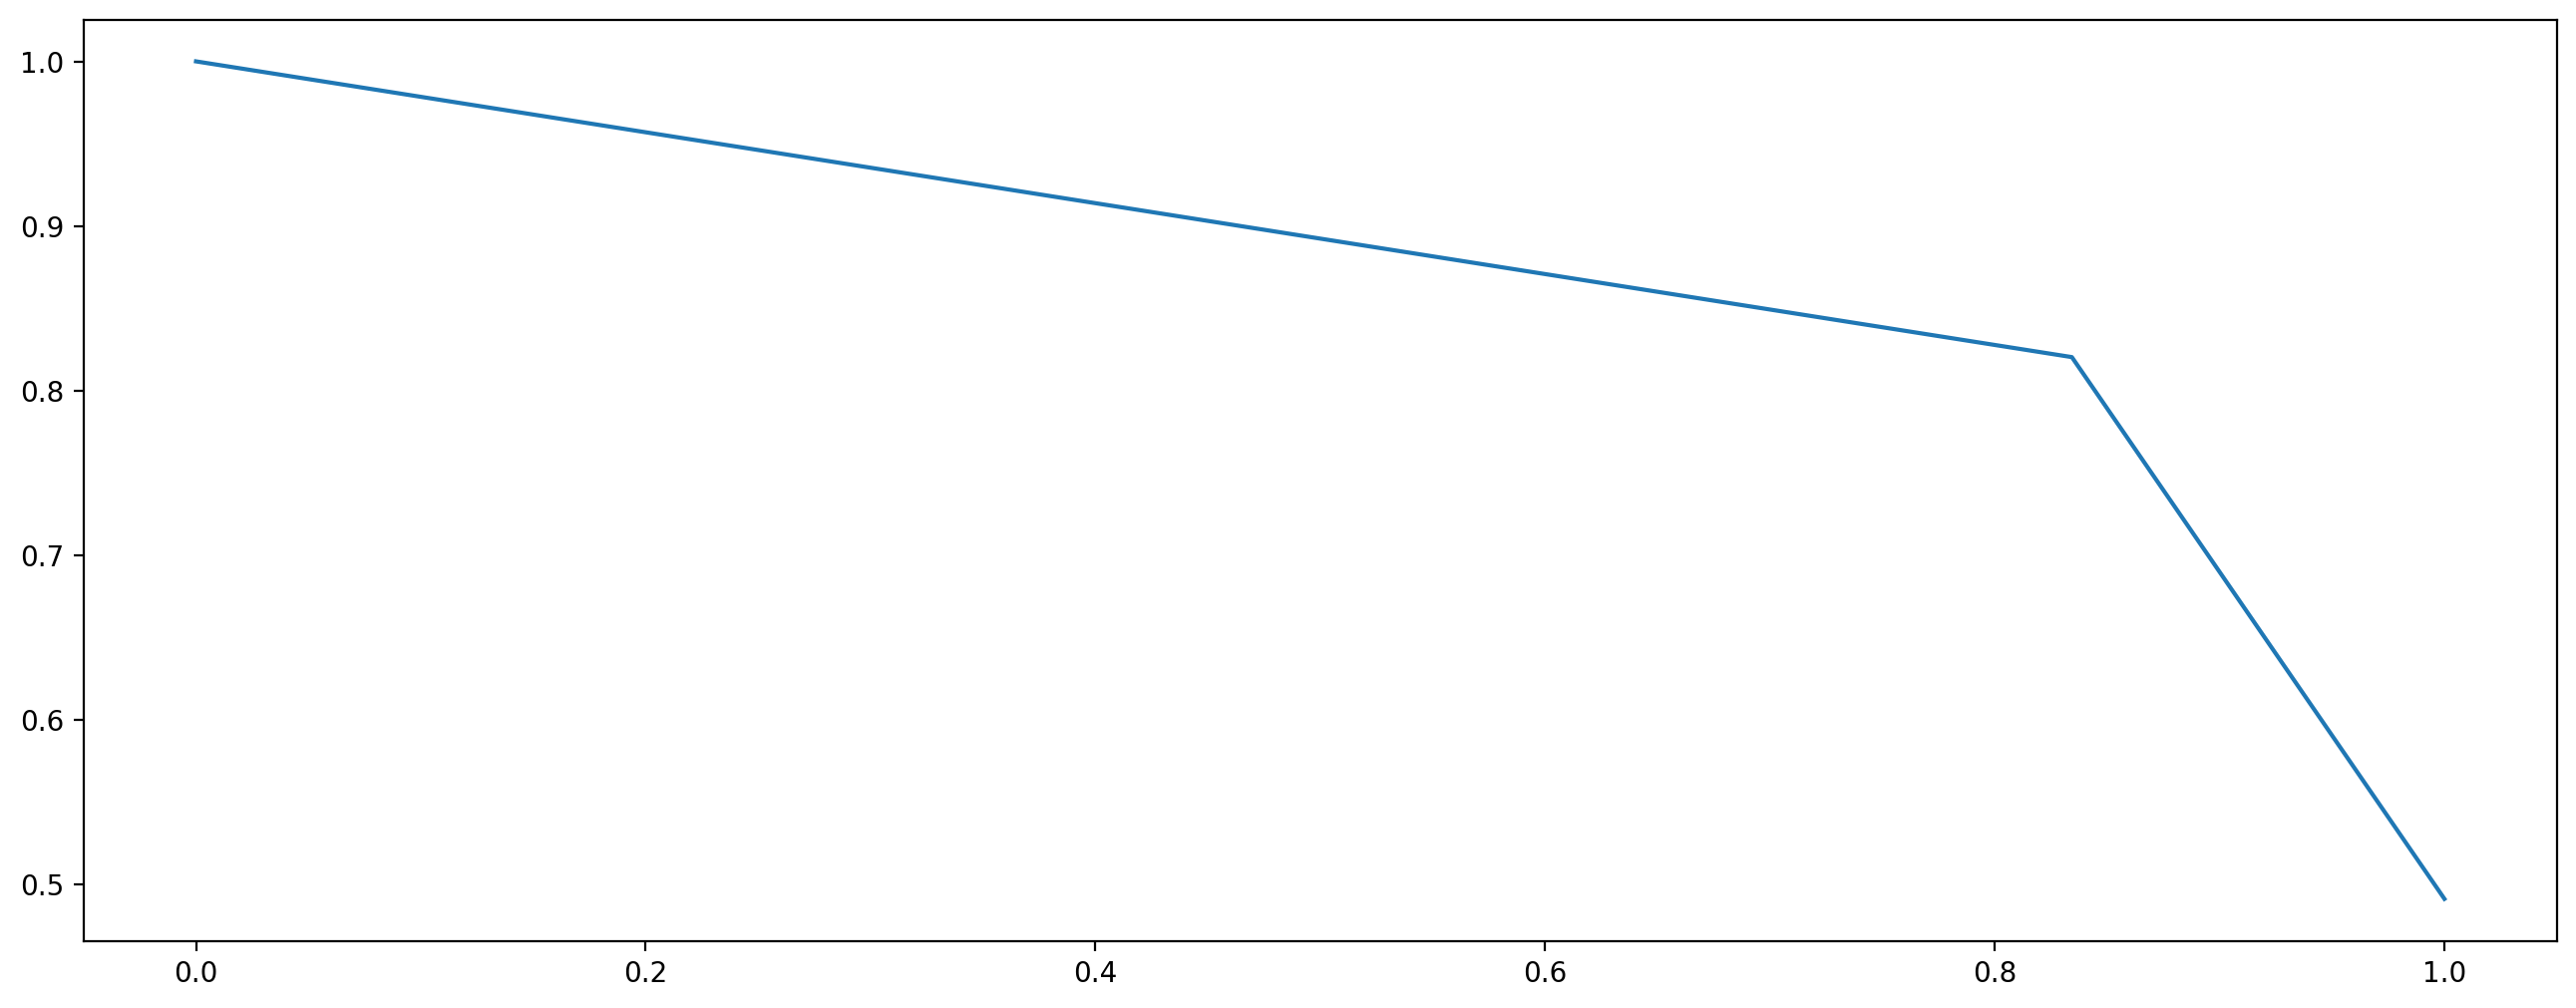

In [37]:

# For multiclass classification, you need to binarize the labels
y_true_bin = label_binarize(y_test, classes=np.unique(y_test))
y_score_bin = label_binarize(y_test_prediction, classes=np.unique(y_test_prediction))

auc_roc = roc_auc_score(y_true_bin, y_score_bin, average='macro')

classes = len(y.unique())

# Plot Precision-Recall curve for each class
precision = dict()
recall = dict()

plt.figure(figsize=(16, 6))    
for i in range(classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], y_score_bin[:, i])
    plt.plot(recall[i], precision[i], label='Covertype {}'.format(i + 1))

plt.grid()
plt.xlabel('Recall')
plt.ylabel('True Positive Rate / Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')

filename = "precision_recall.png"
plt.savefig(os.path.join(results_path, filename))
            
plt.show()


# Plot AUC-ROC curve for each class
fpr = dict()
tpr = dict()

plt.figure(figsize=(16, 6))    
for i in range(classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score_bin[:, i])
    plt.plot(fpr[i], tpr[i], label='Covertype {}'.format(i + 1))

plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate / Precision')
plt.title('ROC Curve')
plt.legend(loc='best')
            
filename = "roc_curve.png"
plt.savefig(os.path.join(results_path, filename))
            
plt.show()


# Partial Dependence

In [ ]:
# potentially iterate over features (and relation ie 0 to 1)

In [ ]:

features, feature_names = [(0,)], [f"Features #{i}" for i in range(X.shape[1])]
deciles = {0: np.linspace(0, 1, num=5)}

pd_results = partial_dependence(
    model, X, features=1, kind="average", grid_resolution=5)

display = PartialDependenceDisplay(
    [pd_results], features=features, feature_names=feature_names,
    target_idx=0, deciles=deciles
)
display.plot(pdp_lim={1: (-1.38, 0.66)})

plt.grid()
plt.xlabel('Feature Value')
plt.ylabel('Partial Dependence') 
plt.title('Partial Dependence')

filename = "partial_dependence.png"
plt.savefig(os.path.join(results_path, filename))
            
plt.show()


# Confusion Matrix

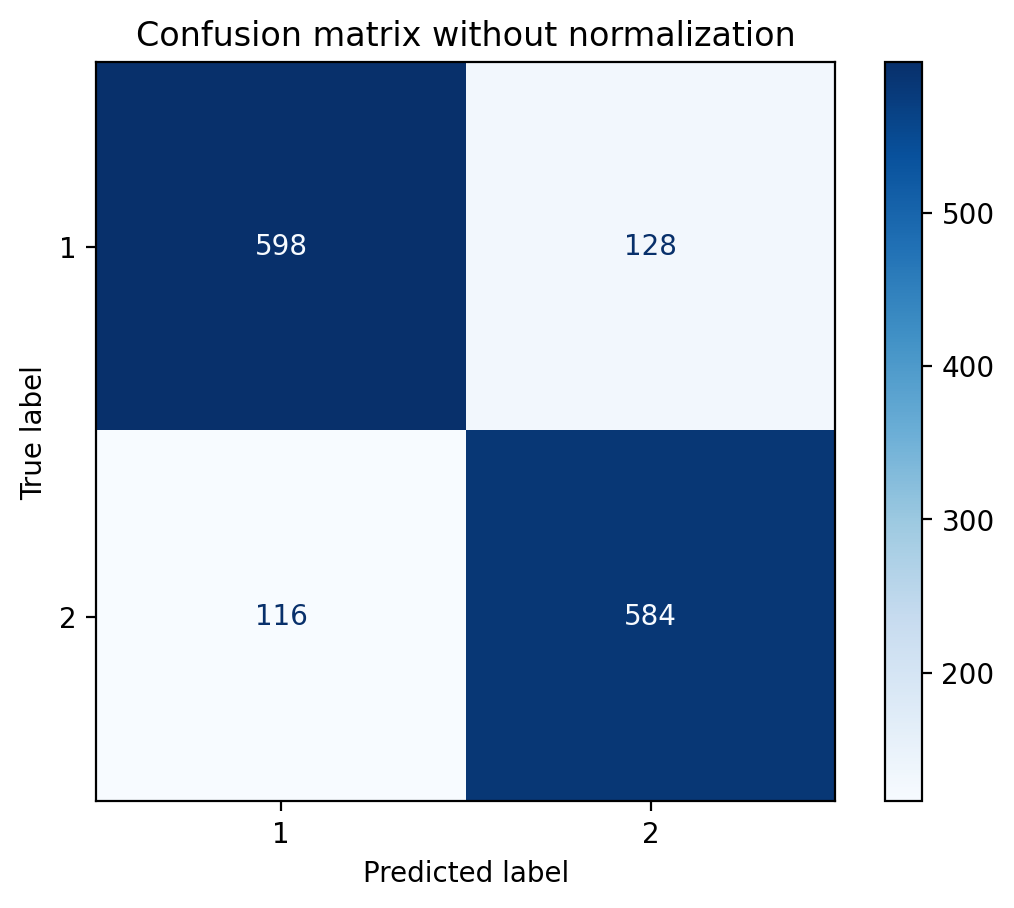

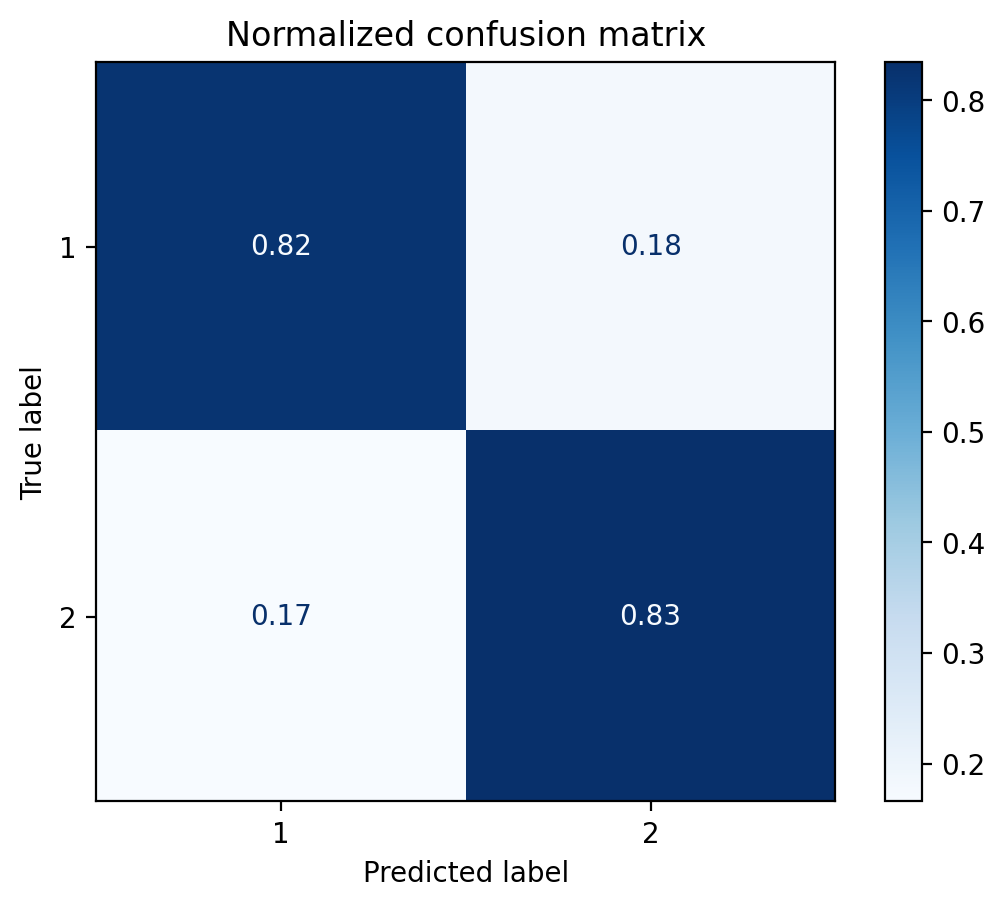

In [39]:

class_names = np.unique(y)

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        model,
        X_test,
        y_test,
        display_labels=class_names + 1,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    png_name = title.lower().replace(" ", "_")
    filename = f"{png_name}.png"
    plt.savefig(os.path.join(results_path, filename))

plt.show()

# Shap Values

In [ ]:
explainer = shap.TreeExplainer(model)
explanation = explainer.shap_values(X_test, check_additivity=False)


In [ ]:
shap.summary_plot(explanation, X_test, plot_type="bar", show=False)

filename = f"shap_summary.png"
plt.savefig(os.path.join(results_path, filename))
plt.close()  

SHAP values show how each feature affects each final prediction, the significance of each feature compared to others, and the model's reliance on the interaction between features.


In [ ]:
# IF WE SCALE: SCALE ONLY TRAIN DATA SET
# BOOSTING ALG:

# - Feature Selection: AUTOMATIC (NON CRITICAL)
# - Scaling: AUTOMATIC
# - Handling Missing Values: AUTOMATIC
# - Outliers: NEED TO DEAL WITH

# KAGGLE Prediction

In [ ]:
test_processed = pd.read_csv('Data/test_engineered.csv')

In [ ]:
test_processed.head()

In [ ]:
test_processed = test_processed.loc[:, [col for col in test_processed if not col.startswith('Cover_Type_')]]
X_kaggle = test_processed.drop(columns=['Aspect_Sector'])
y_kaggle = model.predict(X_kaggle) + 1

In [ ]:
pd.read_csv("Data/Kaggle/full_submission.csv").head()

In [ ]:
test_processed['Cover_Type'] = y_kaggle

In [ ]:
kaggle_submission = test_processed.loc[:, ['Id', 'Cover_Type']]

In [ ]:
kaggle_submission.Cover_Type.value_counts()

In [ ]:
kaggle_submission.to_csv(f'Data/kaggle_submission_{timestamp}.csv', index=False)

In [ ]:
pd.read_csv(f'Data/kaggle_submission_{timestamp}.csv')

In [ ]:
timestamp